In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
from IPython.display import display
import seaborn as sns
from tqdm import tqdm, trange
from scipy import stats
import datetime
import shutil 
import os
import multiprocessing

from sklearn.externals.joblib import Parallel, delayed
# from joblib import Parallel, delayed

# from Beeomics.Statistics import elbow_detection

start_codon = 'ATG'

lowercase_synonymous_list = ['ctT', 'ctC', 'ctA', 'ctG', 
                             'gtT', 'gtC', 'gtA', 'gtG', 
                             'gcT', 'gcC', 'gcA', 'gcG', 
                             'ggT', 'ggC', 'ggA', 'ggG', 
                             'ccT', 'ccC', 'ccA', 'ccG', 
                             'acT', 'acC', 'acA', 'acG', 
                             'tcT', 'tcC', 'tcA', 'tcG', 
                             'cgT', 'cgC', 'cgA', 'cgG']

annotations_normal = '/data3/Arshad_files/apis-codon-no-upstream-downstream.table'

pd.set_option('max_colwidth', 125)

def fold_af(allele_count, allele_number, allele_frequency):
    if allele_frequency <= 0.5:
        return allele_count
    else:
        return allele_number-allele_count

def get_gene1_or_gene2(gene1, gene2):
    if gene1 is np.NaN:
        return gene2
    else:
        return gene1

def ecdf(data):
    """
    Empirical CDF (x, y) generator
    """
    x = np.sort(data)
    cumulative_prob_density = np.linspace(0, 1, len(x))
    return cumulative_prob_density, x

def elbow_detection(data, threshold=1, tune=0.01, get_index=False):
    cdf, ordered = ecdf(data)
    data_2nd_deriv = np.diff(np.diff(ordered))
    elbow_point = np.argmax(data_2nd_deriv > threshold) - int(len(cdf) * tune)
    return elbow_point if get_index else ordered[elbow_point]

/home/arshad/miniconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/arshad/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
%%time
variants = pd.read_table(annotations_normal, sep='\t', header=0, comment='#')
variants.rename(columns={'INFO;EFF=(MODIFIER||||||||||ALT|ERROR_CHROMOSOME_NOT_FOUND)' : 'ANN'}, inplace=True)
# '0':'POS', '0.0':'QUAL',

<string>:2: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 1min 11s, sys: 10.3 s, total: 1min 21s
Wall time: 1min 51s


In [3]:
display(variants.head(6))
print(f"All sites: {len(variants)}, SNPs: {len(variants[variants['AC'] != 0])}")

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,ANN,FORMAT,AF,AC,AN,DP,MQ,QD,FS,SOR,MQRankSum,ReadPosRankSum
0,1.1,576,.,C,T,647.87,PASS,EFF=intron_variant(MODIFIER|||c.1636+75G>A|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|T),.,0.125,6.0,48.0,152,31.99,31.26,0.000,1.609,NaN,NaN
1,1.1,614,.,A,T,795.38,PASS,EFF=intron_variant(MODIFIER|||c.1636+37T>A|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|T),.,0.113,6.0,53.0,152,46.2,25.66,1.529,1.179,1.500,1.030
2,1.1,655,.,T,C,900.94,PASS,EFF=synonymous_variant(LOW|SILENT|caA/caG|p.Gln544Gln/c.1632A>G|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|C),.,0.194,13.0,67.0,462,52.16,10.48,3.970,0.358,0.065,-0.290
3,1.1,670,.,G,A,252.20,PASS,EFF=synonymous_variant(LOW|SILENT|aaC/aaT|p.Asn539Asn/c.1617C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),.,0.054,4.0,74.0,539,60.0,14.84,0.000,0.818,1.100,1.270
4,1.1,703,.,A,G,228.79,PASS,EFF=synonymous_variant(LOW|SILENT|gaT/gaC|p.Asp528Asp/c.1584T>C|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|G),.,0.010,1.0,100.0,833,60.0,4.16,0.000,0.733,-0.484,0.195
5,1.1,733,.,A,G,1279.96,PASS,EFF=synonymous_variant(LOW|SILENT|ctT/ctC|p.Leu518Leu/c.1554T>C|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|G),.,0.029,3.0,102.0,1161,60.0,8.42,2.922,0.992,0.056,-0.034


All sites: 21591259, SNPs: 9865704


# original Genes list

In [4]:
# Original gene list
queen_genes_og = []
worker_genes_og = []

#Amro's 2007 adult genes
adult_queen = []
adult_worker = []

# Chinese genes
#https://onlinelibrary.wiley.com/doi/abs/10.1111/1744-7917.12557
two_queen = []
two_worker = []
four_queen = []
four_worker = []

# Brock's Gene list from DESeq2

In [5]:
# List of queen
# final_file? = /home/arshad/Gene-expression-analysis/apis_deseq2_queen_expression_3_new_caste_func.csv
genes_df_deseq2_queen = pd.read_csv('/home/arshad/Gene_expression/apis_deseq2_queen_avg_brock.csv')
brock_queen_genes = genes_df_deseq2_queen[genes_df_deseq2_queen['caste'] == 'queen']['gene_name'].tolist()

In [6]:
# List of worker
# final_file? = /home/arshad/Gene-expression-analysis/apis_deseq2_worker_expression_3_new_caste_func.csv
genes_df_deseq2_worker = pd.read_csv('/home/arshad/Gene_expression/apis_deseq2_worker_avg_brock.csv')
brock_worker_genes = genes_df_deseq2_worker[genes_df_deseq2_worker['caste'] == 'worker']['gene_name'].tolist()

In [7]:
worker_genes_df_temp = genes_df_deseq2_worker.loc[genes_df_deseq2_worker['log2FoldChange'] >= 1]
worker_genes_deseq2 = worker_genes_df_temp[worker_genes_df_temp['caste'] == 'worker']['gene_name'].tolist()

In [8]:
# List of queen and worker genes
# genes_df_deseq2 = pd.read_csv('/home/arshad/apis_deseq2_worker_queen_expression_prelim.csv')
# queen_genes_deseq2 = genes_df_deseq2[genes_df_deseq2['caste'] == 'queen']['gene_name'].tolist()
# worker_genes_deseq2 = genes_df_deseq2[genes_df_deseq2['caste'] == 'worker']['gene_name'].tolist()

print(f'Number of Queen genes = {len(brock_queen_genes)}')
print(f'Number of Worker genes = {len(worker_genes_deseq2)}')

Number of Queen genes = 219
Number of Worker genes = 1430


In [9]:
# queen_genes_deseq2 = []
# worker_genes_deseq2 = []

# Chinese Paper Reanalyzed

In [10]:
# List of queen
# final file? = /home/arshad/Chinese-paper-gene-expression/apis_deseq2_queen_expression.csv
genes_df_deseq2_queen = pd.read_csv('/home/arshad/Gene_expression/apis_deseq2_queen_avg_chinese.csv')
chinese_queen_genes = genes_df_deseq2_queen[genes_df_deseq2_queen['caste'] == 'queen']['gene_name'].tolist()

In [11]:
# List of worker
# final file? = /home/arshad/Chinese-paper-gene-expression/apis_deseq2_worker_expression.csv
genes_df_deseq2_worker = pd.read_csv('/home/arshad/Gene_expression/apis_deseq2_worker_avg_chinese.csv')
worker_genes_deseq2_chinese = genes_df_deseq2_worker[genes_df_deseq2_worker['caste'] == 'worker']['gene_name'].tolist()

worker_genes_df_temp = genes_df_deseq2_worker.loc[genes_df_deseq2_worker['log2FoldChange'] >= 1]
worker_genes_deseq2_chinese = worker_genes_df_temp[worker_genes_df_temp['caste'] == 'worker']['gene_name'].tolist()

In [12]:
print(f'Number of Queen genes = {len(chinese_queen_genes)}')
print(f'Number of Worker genes = {len(worker_genes_deseq2_chinese)}')

Number of Queen genes = 921
Number of Worker genes = 159


In [13]:
# queen_genes_deseq2_chinese = []
# worker_genes_deseq2_chinese = []

# Merge Gene list

In [14]:
queen_genes = list(set(brock_queen_genes + queen_genes_og + chinese_queen_genes))
worker_genes = list(set(worker_genes_deseq2 + worker_genes_og + worker_genes_deseq2_chinese))

print(f'Number of Queen genes = {len(queen_genes)}')
print(f'Number of Worker genes = {len(worker_genes)}')

Number of Queen genes = 1076
Number of Worker genes = 1567


In [15]:
unbiased_genes = list(set(queen_genes + worker_genes))
print(f'Nmber of genes= {len(unbiased_genes)}')

Nmber of genes= 2610


In [16]:
common_queen_genes = list(set(brock_queen_genes).intersection(set(chinese_queen_genes)))
common_worker_genes = list(set(worker_genes_deseq2).intersection(set(worker_genes_deseq2_chinese)))

print(len(common_queen_genes), len(common_worker_genes))

64 22


# High vs low expression genes

In [17]:
top_queens = pd.read_csv('/home/arshad/Gene_expression/top_queen_genes_brock_chinese.csv')
top_workers = pd.read_csv('/home/arshad/Gene_expression/top_worker_genes_brock_chinese.csv')

bottom_queens = pd.read_csv('/home/arshad/Gene_expression/bottom_queen_genes_brock_chinese.csv')
bottom_workers = pd.read_csv('/home/arshad/Gene_expression/bottom_worker_genes_brock_chinese.csv')

top_drones = pd.read_csv('/home/arshad/Gene_expression/top_drone_genes_brock_chinese.csv')
bottom_drones = pd.read_csv('/home/arshad/Gene_expression/bottom_drone_genes_brock_chinese.csv')

display(bottom_workers.head())
display(top_queens.head())
display(top_workers.head())
display(top_drones.head())

,gene_name,padj,worker_avg,queen_avg
0,GB52554,0.039292,2.416667,0.583333
1,GB43136,0.035836,2.416667,0.916667
2,GB48056,0.039685,3.083333,1.083333
3,GB40330,0.020092,3.416667,0.583333
4,GB50436,0.021945,3.666667,0.200000


,gene_name,padj,worker_avg,queen_avg,difference,norm_diff
0,GB51696,1.956862e-02,11093.333333,196124.800000,185031.466667,0.943437
1,GB54372,1.839551e-02,79240.250000,94666.416667,15426.166667,0.162953
2,GB53621,7.058807e-08,22686.000000,93685.600000,70999.600000,0.757850
3,GB53623,2.875972e-07,21489.666667,73804.600000,52314.933333,0.708830
4,GB40976,3.198215e-02,54628.500000,68752.333333,14123.833333,0.205431


,gene_name,padj,worker_avg,queen_avg,difference,norm_diff
0,GB44996,0.010769,519358.750000,226859.416667,292499.333333,0.563193
1,GB54419,0.000494,95951.833333,4218.666667,91733.166667,0.956033
2,GB41096,0.003509,44049.000000,4754.800000,39294.200000,0.892057
3,GB40136,0.002496,24270.333333,4070.750000,20199.583333,0.832275
4,GB49240,0.000375,22365.250000,8612.916667,13752.333333,0.614897


,gene_name,padj,queen_avg,drone_avg
0,GB51697,2.256420e-02,80971.600000,594689.80
1,GB51698,5.584824e-23,15328.200000,131061.80
2,GB54419,1.079702e-28,5847.200000,101993.60
3,GB42053,2.983079e-02,6394.000000,88982.80
4,GB52590,6.686112e-09,18807.083333,74598.25


In [18]:
top_queen_genes = np.unique(top_queens[:206]['gene_name'].tolist())
top_worker_genes = np.unique(top_workers[:201]['gene_name'].tolist())

bottom_queen_genes = np.unique(bottom_queens[:211]['gene_name'].tolist())
bottom_worker_genes = np.unique(bottom_workers[:201]['gene_name'].tolist())

top_drone_genes = np.unique(top_drones[:202]['gene_name'].tolist())
bottom_drone_genes = np.unique(bottom_drones[:207]['gene_name'].tolist())

print(len(top_queen_genes), len(top_worker_genes), len(bottom_queen_genes), len(bottom_worker_genes), len(top_drone_genes), len(bottom_drone_genes))

200 200 200 200 200 200


In [19]:
# top_queens.sort_values(by=['norm_diff'], ascending=False, inplace=True)
# top_workers.sort_values(by=['norm_diff'], ascending=False, inplace=True)

# display(top_queens.head())

# top_queen_genes_temp = np.unique(top_queens[:215]['gene_name'].tolist())
# top_worker_genes_temp = np.unique(top_workers[:201]['gene_name'].tolist())

# print(len(top_queen_genes), len(top_worker_genes))

### Atlas genes

In [20]:
atlas_data = pd.read_csv('/home/arshad/Gene_expression/ApisExpressionData.csv')

atlas_queen = list(atlas_data[atlas_data['Caste'] == 'Queen']['GB'])
atlas_worker = list(atlas_data[atlas_data['Caste'] == 'Worker']['GB'])
print(f'Atlas: Queen= {len(atlas_queen)}, Worker= {len(atlas_worker)}')

Atlas: Queen= 79, Worker= 94


# Drone genes

In [21]:
drone_queen_genes = pd.read_csv('/home/arshad/Gene_expression/drone-and-queen-genes.csv') 
display(drone_queen_genes.head()) 
atlas_drone_genes = drone_queen_genes[drone_queen_genes['caste'] == 'drone-d']['gene'].tolist()
print(len(atlas_drone_genes), atlas_drone_genes[:5])

,protein_id,description,d_ave,q_ave,w_ave,dvw,dvq,qvw,ave_fold_d,ave_fold_q,dronevq_fold,protein_identification,gene,query_id,caste
0,4980,XP_001121185.2 PREDICTED: glucose-6-phosphate 1-dehydrogenase partial,24.0,42.4,43.4,*,*,\N,0.552995,0.976959,0.566038,4980,GB46579,4980:XP_001121185.2,queen-d
1,4980,XP_001121185.2 PREDICTED: glucose-6-phosphate 1-dehydrogenase partial,24.0,42.4,43.4,*,*,\N,0.552995,0.976959,0.566038,4980,GB46577,4980:XP_001121185.2,queen-d
2,4976,XP_393370.3 PREDICTED: 26S proteasome non-ATPase regulatory subunit 12 partial,32.8,32.7,46.8,\N,*,\N,0.700855,0.698718,1.003058,4976,GB52675,4976:XP_393370.3,drone-d
3,4967,NP_001035323.1 cytochrome P450 4G11,8.2,39.9,59.9,*,*,\N,0.136895,0.666110,0.205514,4967,GB51356,4967:NP_001035323.1,queen-d
4,4955,XP_397213.2 PREDICTED: 39S ribosomal protein L47 mitochondrial isoform 1,45.3,40.8,36.9,\N,*,\N,1.227642,1.105691,1.110294,4955,GB51342,4955:XP_397213.2,drone-d


67 ['GB52675', 'GB51342', 'GB40865', 'GB40864', 'GB40863']


In [22]:
brock_drone_file = pd.read_csv('/home/arshad/Gene_expression/brock_samples_drone_genes.csv')
brock_drone_genes = brock_drone_file[brock_drone_file['caste'] == 'drone']['gene_name'].tolist()
print(len(brock_drone_genes))

1979


In [23]:
chinese_drone_file = pd.read_csv('/home/arshad/Gene_expression/chinese_drone_genes.csv')
chinese_drone_genes = chinese_drone_file[chinese_drone_file['caste'] == 'drone']['gene_name'].tolist()

In [24]:
drone_genes = list(set(brock_drone_genes + chinese_drone_genes))
len(drone_genes)

2530

In [25]:
brock_top_drones_file = pd.read_csv('/home/arshad/Gene_expression/brock_drone_top_300.csv')
brock_bottom_drones_file = pd.read_csv('/home/arshad/Gene_expression/brock_drone_bottom_300.csv')
chinese_top_drones_file = pd.read_csv('/home/arshad/Gene_expression/chinese_drone_top_300.csv')
chinese_bottom_drones_file = pd.read_csv('/home/arshad/Gene_expression/chinese_drone_bottom_300.csv')

brock_top_drone_genes = list(brock_top_drones_file['gene_name'])
brock_bottom_drone_genes = list(brock_bottom_drones_file['gene_name'])
chinese_top_drone_genes = list(chinese_top_drones_file['gene_name'])
chinese_bottom_drone_genes = list(chinese_bottom_drones_file['gene_name'])

In [26]:
brock_top_queens_file = pd.read_csv('/home/arshad/Gene_expression/brock_queen_top_100.csv')
brock_bottom_queens_file = pd.read_csv('/home/arshad/Gene_expression/brock_queen_bottom_100.csv')
chinese_top_queens_file = pd.read_csv('/home/arshad/Gene_expression/chinese_queen_top_300.csv')
chinese_bottom_queens_file = pd.read_csv('/home/arshad/Gene_expression/chinese_queen_bottom_300.csv')

brock_top_queen_genes = list(brock_top_queens_file['gene_name'])
brock_bottom_queen_genes = list(brock_bottom_queens_file['gene_name'])
chinese_top_queen_genes = list(chinese_top_queens_file['gene_name'])
chinese_bottom_queen_genes = list(chinese_bottom_queens_file['gene_name'])

print(len(brock_top_drone_genes), len(brock_bottom_drone_genes))
# len(brock_top_queens_genes), len(brock_bottom_queen_genes)

300 300


# Load file

In [4]:
# variants.dtypes
droppable_columns = ['MQ', 'QD', 'FS', 'SOR', 'MQRankSum', 'ReadPosRankSum']
variants.drop(columns=droppable_columns, inplace=True)

In [27]:
display(variants.query('AF == 0').head())

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,ANN,FORMAT,AF,AC,AN,DP,MQ,QD,FS,SOR,MQRankSum,ReadPosRankSum
238,1.1,6699,.,C,T,50.02,PASS,EFF=intron_variant(MODIFIER|||c.496-842G>A|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|3|T),.,0.0,0.0,102.0,1861,NaN,NaN,NaN,NaN,NaN,NaN
239,1.1,6700,.,G,A,50.23,PASS,EFF=intron_variant(MODIFIER|||c.496-843C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|3|A),.,0.0,0.0,102.0,1863,NaN,NaN,NaN,NaN,NaN,NaN
241,1.1,6703,.,A,G,50.12,PASS,EFF=intron_variant(MODIFIER|||c.496-846T>C|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|3|G),.,0.0,0.0,102.0,1878,NaN,NaN,NaN,NaN,NaN,NaN
242,1.1,6705,.,T,G,50.43,PASS,EFF=intron_variant(MODIFIER|||c.496-848A>C|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|3|G),.,0.0,0.0,102.0,1866,NaN,NaN,NaN,NaN,NaN,NaN
243,1.1,6706,.,T,G,50.89,PASS,EFF=intron_variant(MODIFIER|||c.496-849A>C|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|3|G),.,0.0,0.0,102.0,1867,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
variants['genes'] = variants['ANN'].str.extract('(GB[0-9]{5})')

In [29]:
variants['CHROM'] = variants['CHROM'].astype('category')
variants['REF'] = variants['REF'].astype('category')
variants['ALT'] = variants['ALT'].astype('category')
variants['FILTER'] = variants['FILTER'].astype('category')

# variants[['CHROM', 'ALT']] = variants[['CHROM', 'ALT']].astype('category')

In [30]:
print(len(variants))

21591259


In [31]:
variants = variants[variants['AN'] == variants['AN'].max().astype(int)]

In [32]:
print(variants['AC'].unique(), variants['AN'].unique())

[  3.   1.   2.   5.  13.   4.   6.  12. 102.  51.   8.  10.   9.  36.
  25.  35.   0.   7.  34.  28.  60.  76.  46.  26.  23.  18.  30.  94.
  16. 100.  14.  59.  22.  37.  11.  45.  24. 101.  98.  81.  41.  32.
  47.  21.  71.  38.  15.  17.  52.  29.  97.  99.  83.  64.  53.  19.
  48.  67.  68.  27.  20.  43.  49.  74.  31.  42.  33.  93.  40.  96.
  44.  66.  88.  50.  63.  90.  85.  56.  80.  61.  39.  95.  89.  91.
  62.  78.  75.  86.  65.  84.  57.  87.  79.  70.  77.  58.  73.  69.
  54.  92.  82.  55.  72.] [102.]


In [33]:
variants = variants[variants['ANN'] != 'EFF=']
variants = variants[variants['ANN'] != '.']

# variants['effect'] = variants.str.split('(').str.get(0).str.split('EFF=').str.get(1)

variants['effect'] = variants['ANN'].apply(lambda x: x.split('(')[0]).apply(lambda x: x.split('EFF=')[1])
variants['chr-int'] = variants['CHROM'].astype(int)
variants['genes'] = variants['ANN'].str.extract('(GB[0-9]{5})')

In [34]:
%%time
# variants['cal_af2'] = variants.apply(lambda row: fold_af(row['AC'], row['AN'], row['AF']), axis='columns')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15 µs


In [35]:
%%time
ac_values = variants['AC'].values
cal_af = ac_values.copy()
total_alleles = variants['AN'].max()
indices = np.where(cal_af > (total_alleles/2))
cal_af[indices] = total_alleles - cal_af[indices]
variants['cal_af'] = cal_af

CPU times: user 164 ms, sys: 20 ms, total: 184 ms
Wall time: 184 ms


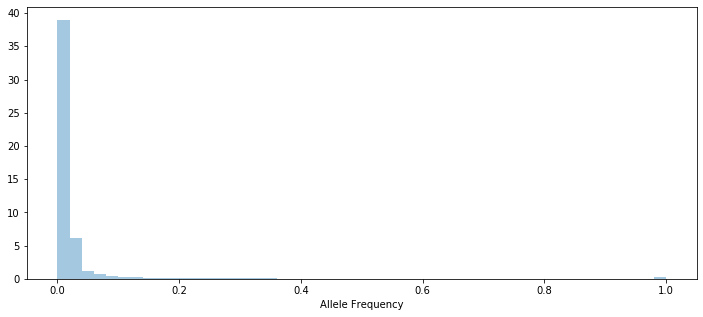

In [36]:
graph.figure(figsize=(12,5))
sns.distplot(variants['AF'], kde=False, norm_hist=True)
graph.xlabel('Allele Frequency')
graph.show()

In [37]:
variants = variants[variants['QUAL'] > 50]
# variants = variants[variants['chr-int'] !=17]
variants = variants[variants['chr-int'] !=18]

# chrom18data = variants[variants['chr-int'] == 18]

In [38]:
display(variants.head(7))

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,ANN,FORMAT,AF,...,MQ,QD,FS,SOR,MQRankSum,ReadPosRankSum,genes,effect,chr-int,cal_af
5,1.1,733,.,A,G,1279.96,PASS,EFF=synonymous_variant(LOW|SILENT|ctT/ctC|p.Leu518Leu/c.1554T>C|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|G),.,0.029000,...,60.0,8.42,2.922,0.992,0.056,-0.034,GB42164,synonymous_variant,1,3.0
6,1.1,757,.,C,T,777.30,PASS,EFF=synonymous_variant(LOW|SILENT|acG/acA|p.Thr510Thr/c.1530G>A|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|T),.,0.009804,...,60.0,9.48,1.801,0.501,-0.718,0.736,GB42164,synonymous_variant,1,1.0
7,1.1,778,.,G,A,316.25,PASS,EFF=synonymous_variant(LOW|SILENT|ttC/ttT|p.Phe503Phe/c.1509C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),.,0.009804,...,60.0,5.36,2.220,1.018,0.274,0.337,GB42164,synonymous_variant,1,1.0
8,1.1,802,.,C,T,156.41,PASS,EFF=synonymous_variant(LOW|SILENT|gaG/gaA|p.Glu495Glu/c.1485G>A|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|T),.,0.009804,...,60.0,7.82,0.000,0.693,0.340,-0.567,GB42164,synonymous_variant,1,1.0
9,1.1,805,.,G,A,1106.79,PASS,EFF=synonymous_variant(LOW|SILENT|gcC/gcT|p.Ala494Ala/c.1482C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),.,0.020000,...,60.0,8.32,5.259,1.093,0.389,0.844,GB42164,synonymous_variant,1,2.0
10,1.1,826,.,G,A,1761.37,PASS,EFF=synonymous_variant(LOW|SILENT|ctC/ctT|p.Leu487Leu/c.1461C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),.,0.009804,...,60.0,22.58,0.000,0.976,NaN,NaN,GB42164,synonymous_variant,1,1.0
11,1.1,829,.,G,A,761.53,PASS,EFF=synonymous_variant(LOW|SILENT|aaC/aaT|p.Asn486Asn/c.1458C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),.,0.029000,...,60.0,9.07,0.000,0.750,0.155,0.736,GB42164,synonymous_variant,1,3.0


## SNPs only (to get depth and quality cut-off)

In [39]:
snps = variants[variants['AC'] != 0]
print(len(snps))

6977149


# Graphs for THesis oral defense

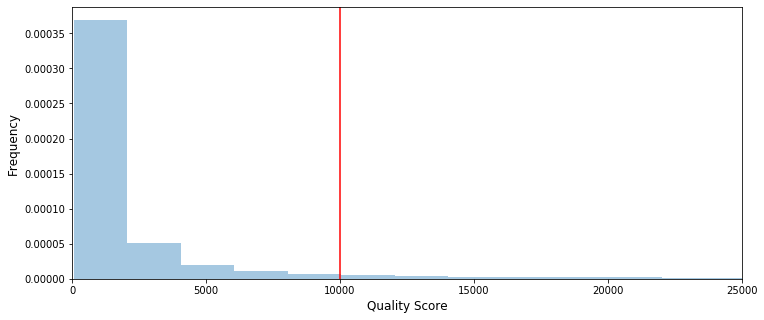

In [17]:
graph.figure(figsize=(12,5))
sns.distplot(snps['QUAL'], kde=False, norm_hist=True)
graph.xlim(0, 25000)
graph.axvline(10000, color='red')
graph.xlabel('Quality Score', fontsize=12)
graph.ylabel('Frequency', fontsize=12)
graph.show()

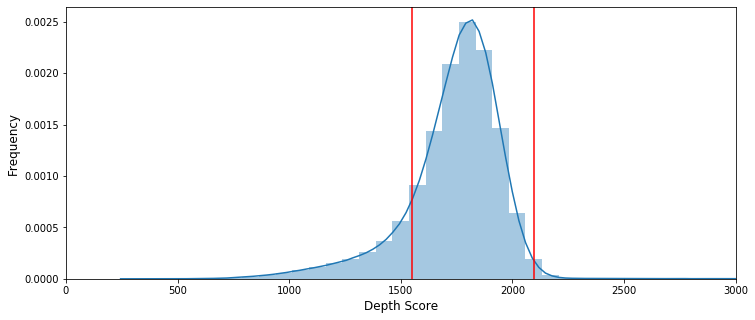

In [18]:
graph.figure(figsize=(12,5))
sns.distplot(snps.query('DP < 4000')['DP'], kde=True, norm_hist=True)
graph.xlim(0, 3000)
graph.axvline(1550, color='red')
graph.axvline(2097, color='red')
graph.xlabel('Depth Score', fontsize=12)
graph.ylabel('Frequency', fontsize=12)
graph.show()

### Depth

In [40]:
Q1_snps = snps.query('DP < 4000')['DP'].quantile(0.25)
Q3_snps = snps.query('DP < 4000')['DP'].quantile(0.75)
IQR_snps = Q3_snps - Q1_snps

lower_dp_snps = Q1_snps -(1.5*IQR_snps)
upper_dp_snps = Q3_snps + (1.5*IQR_snps)
print(Q1_snps, Q3_snps,lower_dp_snps, upper_dp_snps)

1645.0 1875.0 1300.0 2220.0


In [41]:
q1 = snps['DP'].quantile(0.25)

In [42]:
depth_elbow = elbow_detection(snps.query('DP < 4000')['DP'])
print(f'Elbow depth = {depth_elbow}')

Elbow depth = 2097


In [43]:
print(f"High depth = {len(snps.query('DP > 2205')['DP'])}")
print(f"Low depth = {len(snps.query('DP < 1329')['DP'])}")
print(f"High depth elbow = {len(snps.query('DP > 2093')['DP'])}")

High depth = 26751
Low depth = 380551
High depth elbow = 80381


### Quality

In [44]:
quality_elbow = elbow_detection(snps.query('QUAL < 60000')['QUAL'])
print(f'Elbow quality = {quality_elbow}')

Elbow quality = 2988.220000000001


In [45]:
print(f"High Quality = {len(snps.query('QUAL > 2989')['QUAL'])}")

High Quality = 1390334


In [46]:
print(lower_dp_snps, depth_elbow)

1300.0 2097


In [47]:
print(f"Crude mutation rate = {len(variants[variants['AC'] != 0]) / len(variants)}")

Crude mutation rate = 0.37797244029224764


In [48]:
variants = variants[variants['DP'] > lower_dp_snps]
variants = variants[variants['DP'] < depth_elbow]
variants = variants[variants['QUAL'] < 10000]

In [49]:
print(len(variants))

15652480


In [50]:
final_snps = variants[variants['AC'] != 0]
print(len(final_snps))

6003948


In [51]:
variants.head(10)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,ANN,FORMAT,AF,...,MQ,QD,FS,SOR,MQRankSum,ReadPosRankSum,genes,effect,chr-int,cal_af
6,1.1,757,.,C,T,777.30,PASS,EFF=synonymous_variant(LOW|SILENT|acG/acA|p.Thr510Thr/c.1530G>A|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|T),.,0.009804,...,60.0,9.48,1.801,0.501,-0.718,0.736,GB42164,synonymous_variant,1,1.0
7,1.1,778,.,G,A,316.25,PASS,EFF=synonymous_variant(LOW|SILENT|ttC/ttT|p.Phe503Phe/c.1509C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),.,0.009804,...,60.0,5.36,2.220,1.018,0.274,0.337,GB42164,synonymous_variant,1,1.0
9,1.1,805,.,G,A,1106.79,PASS,EFF=synonymous_variant(LOW|SILENT|gcC/gcT|p.Ala494Ala/c.1482C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),.,0.020000,...,60.0,8.32,5.259,1.093,0.389,0.844,GB42164,synonymous_variant,1,2.0
10,1.1,826,.,G,A,1761.37,PASS,EFF=synonymous_variant(LOW|SILENT|ctC/ctT|p.Leu487Leu/c.1461C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),.,0.009804,...,60.0,22.58,0.000,0.976,NaN,NaN,GB42164,synonymous_variant,1,1.0
11,1.1,829,.,G,A,761.53,PASS,EFF=synonymous_variant(LOW|SILENT|aaC/aaT|p.Asn486Asn/c.1458C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),.,0.029000,...,60.0,9.07,0.000,0.750,0.155,0.736,GB42164,synonymous_variant,1,3.0
12,1.1,838,.,C,A,2699.82,PASS,EFF=synonymous_variant(LOW|SILENT|gcG/gcT|p.Ala483Ala/c.1449G>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),.,0.049000,...,60.0,12.27,0.000,0.685,-0.248,1.580,GB42164,synonymous_variant,1,5.0
15,1.1,940,.,C,T,1875.33,PASS,EFF=synonymous_variant(LOW|SILENT|ggG/ggA|p.Gly449Gly/c.1347G>A|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|T),.,0.029000,...,60.0,14.1,2.391,0.606,0.785,1.690,GB42164,synonymous_variant,1,3.0
16,1.1,973,.,G,A,5370.34,PASS,EFF=splice_region_variant+intron_variant(LOW|||c.1318-4C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|7|A),.,0.127000,...,60.0,9.78,3.199,0.510,0.649,0.297,GB42164,splice_region_variant+intron_variant,1,13.0
17,1.1,997,.,A,T,4839.62,PASS,EFF=intron_variant(MODIFIER|||c.1318-28T>A|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|7|T),.,0.049000,...,60.0,18.19,27.034,0.521,-0.147,0.478,GB42164,intron_variant,1,5.0
18,1.1,1000,.,G,A,4842.73,PASS,EFF=intron_variant(MODIFIER|||c.1318-31C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|7|A),.,0.049000,...,60.0,18.7,25.676,0.507,0.134,0.376,GB42164,intron_variant,1,5.0


In [52]:
# Get only synonymous sites and save in a dataframe
synonymous_snps = variants[variants['effect'].str.contains('synonymous_variant')]
synonymous_snps['codons'] = synonymous_snps['ANN'].apply(lambda x: x.split('(')[1]).apply(lambda x:x.split('|')[2])
synonymous_snps['OG-codon'] = synonymous_snps['codons'].apply(lambda x: x.split('/')[0])
synonymous_snps['new-codon'] = synonymous_snps['codons'].apply(lambda x: x.split('/')[1])
synonymous_snps.drop(columns=['ID', 'FORMAT'], inplace=True)

/home/arshad/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/arshad/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/arshad/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [53]:
synonymous_snps.head()

,CHROM,POS,REF,ALT,QUAL,FILTER,ANN,AF,AC,AN,...,SOR,MQRankSum,ReadPosRankSum,genes,effect,chr-int,cal_af,codons,OG-codon,new-codon
6,1.1,757,C,T,777.30,PASS,EFF=synonymous_variant(LOW|SILENT|acG/acA|p.Thr510Thr/c.1530G>A|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|T),0.009804,1.0,102.0,...,0.501,-0.718,0.736,GB42164,synonymous_variant,1,1.0,acG/acA,acG,acA
7,1.1,778,G,A,316.25,PASS,EFF=synonymous_variant(LOW|SILENT|ttC/ttT|p.Phe503Phe/c.1509C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),0.009804,1.0,102.0,...,1.018,0.274,0.337,GB42164,synonymous_variant,1,1.0,ttC/ttT,ttC,ttT
9,1.1,805,G,A,1106.79,PASS,EFF=synonymous_variant(LOW|SILENT|gcC/gcT|p.Ala494Ala/c.1482C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),0.020000,2.0,102.0,...,1.093,0.389,0.844,GB42164,synonymous_variant,1,2.0,gcC/gcT,gcC,gcT
10,1.1,826,G,A,1761.37,PASS,EFF=synonymous_variant(LOW|SILENT|ctC/ctT|p.Leu487Leu/c.1461C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),0.009804,1.0,102.0,...,0.976,NaN,NaN,GB42164,synonymous_variant,1,1.0,ctC/ctT,ctC,ctT
11,1.1,829,G,A,761.53,PASS,EFF=synonymous_variant(LOW|SILENT|aaC/aaT|p.Asn486Asn/c.1458C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),0.029000,3.0,102.0,...,0.750,0.155,0.736,GB42164,synonymous_variant,1,3.0,aaC/aaT,aaC,aaT


In [54]:
len(synonymous_snps)

610029

In [55]:
# synonymous_snps.to_csv('/data3/arshad_PNAS_data/newvcfs/Apis_brock_analysis_and_extras/my_synonymous_snps.csv', index=False)

In [56]:
# Get 4-fold synonymous!

four_fold = synonymous_snps.loc[synonymous_snps['OG-codon'].isin(lowercase_synonymous_list)]
# four_fold['genes-split'] = four_fold['ANN'].apply(
#     lambda x: x.split('(')[1]).apply(lambda x:x.split('|')[8]).apply(lambda x:x.split('-')[0])
four_fold.head()

,CHROM,POS,REF,ALT,QUAL,FILTER,ANN,AF,AC,AN,...,SOR,MQRankSum,ReadPosRankSum,genes,effect,chr-int,cal_af,codons,OG-codon,new-codon
6,1.1,757,C,T,777.30,PASS,EFF=synonymous_variant(LOW|SILENT|acG/acA|p.Thr510Thr/c.1530G>A|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|T),0.009804,1.0,102.0,...,0.501,-0.718,0.736,GB42164,synonymous_variant,1,1.0,acG/acA,acG,acA
9,1.1,805,G,A,1106.79,PASS,EFF=synonymous_variant(LOW|SILENT|gcC/gcT|p.Ala494Ala/c.1482C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),0.020000,2.0,102.0,...,1.093,0.389,0.844,GB42164,synonymous_variant,1,2.0,gcC/gcT,gcC,gcT
10,1.1,826,G,A,1761.37,PASS,EFF=synonymous_variant(LOW|SILENT|ctC/ctT|p.Leu487Leu/c.1461C>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),0.009804,1.0,102.0,...,0.976,NaN,NaN,GB42164,synonymous_variant,1,1.0,ctC/ctT,ctC,ctT
12,1.1,838,C,A,2699.82,PASS,EFF=synonymous_variant(LOW|SILENT|gcG/gcT|p.Ala483Ala/c.1449G>T|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|A),0.049000,5.0,102.0,...,0.685,-0.248,1.580,GB42164,synonymous_variant,1,5.0,gcG/gcT,gcG,gcT
15,1.1,940,C,T,1875.33,PASS,EFF=synonymous_variant(LOW|SILENT|ggG/ggA|p.Gly449Gly/c.1347G>A|564|EXON_1.1_378_436|protein_coding|CODING|GB42164-RA|8|T),0.029000,3.0,102.0,...,0.606,0.785,1.690,GB42164,synonymous_variant,1,3.0,ggG/ggA,ggG,ggA


# Caste

In [ ]:
# Four-fold for queen and worker (and non-deg)

queen_four_fold = four_fold.loc[four_fold['genes'].isin(queen_genes)]
worker_four_fold = four_fold.loc[four_fold['genes'].isin(worker_genes)]
drone_four_fold = four_fold.loc[four_fold['genes'].isin(drone_genes)]
# unbiased_four_fold = four_fold.loc[four_fold['genes'].isin(worker_queen_genes)]

# non_deg_four_fold = four_fold.loc[four_fold['genes'].isin(non_deg_genes)]

In [ ]:
# Caste dfs

queen_df = variants.loc[variants['genes'].isin(queen_genes)]
worker_df = variants.loc[variants['genes'].isin(worker_genes)]
drone_df = variants.loc[variants['genes'].isin(drone_genes)]
# unbiased_df = variants.loc[variants['genes'].isin(worker_queen_genes)]

# non_deg_df = variants.loc[variants['genes'].isin(non_deg_genes)]

In [ ]:
print(len(worker_df))
print(len(queen_df))
print(len(drone_df))
# print(len(unbiased_df))

# Bootstrapping part

This is where bootstrapping starts. Code is still under construction

## Updated code for parallel
#### Aug 1

Harshil helped me with the issue of the same list of genes being sent to n_cores by adding it to the function itself.

In [ ]:
%%time
parallel = Parallel(n_jobs=40)

parallel((delayed(sfs_test)(i, np.random.choice(non_deg_genes, len(non_deg_genes))) for i in trange(10000)))

# Whole genome

1. intron = variants[variants['effect'].str.contains('intron_variant')]
2. intergenic = variants[variants['effect'] == 'intergenic_region']
3. intragenic = variants[variants['effect'] == 'intragenic_variant']
4. three_prime_UTR = variants[variants['effect'].str.contains('3_prime_UTR')]
5. five_prime_UTR = variants[variants['effect'].str.contains('5_prime_UTR')]

In [57]:
all_genes = variants['genes'].unique()
len(all_genes)

10662

In [58]:
len(four_fold[four_fold['genes'].isin(all_genes)])

312480

In [59]:
pre_df = variants[variants['effect'].str.contains('missense_variant', na=False)]
interest_subset = pre_df.loc[pre_df['genes'].isin(all_genes)]
print(len(interest_subset), len(pre_df))

1440119 1440119


In [60]:
# BUSCO genes 3 way blast

busco_3_way_best_blast_file = pd.read_csv('/home/arshad/best_blast_apis_bombus_polistes_busco.csv')
display(busco_3_way_best_blast_file.head())

busco_genes = list(busco_3_way_best_blast_file['apis_name'])
print(len(busco_genes))

,apis_name,polistes_name,apis_v_bombus,polistes_v_bombus
0,GB45049,PdomGENEr1.2-11858,XP_012237459.1,XP_012237459.1
1,GB43404,PdomGENEr1.2-09635,XP_012245373.1,XP_012245373.1
2,GB51985,PdomGENEr1.2-10160,XP_012248011.1,XP_012248011.1
3,GB53320,PdomGENEr1.2-01597,XP_012245309.1,XP_012245309.1
4,GB51774,PdomGENEr1.2-06747,XP_012237072.1,XP_012237072.1


3753


In [61]:
variants = variants[['genes', 'AN', 'cal_af', 'effect']]
four_fold = four_fold[['genes', 'AN', 'cal_af', 'effect']]

display(variants.head())
display(four_fold.head())

,genes,AN,cal_af,effect
6,GB42164,102.0,1.0,synonymous_variant
7,GB42164,102.0,1.0,synonymous_variant
9,GB42164,102.0,2.0,synonymous_variant
10,GB42164,102.0,1.0,synonymous_variant
11,GB42164,102.0,3.0,synonymous_variant


,genes,AN,cal_af,effect
6,GB42164,102.0,1.0,synonymous_variant
9,GB42164,102.0,2.0,synonymous_variant
10,GB42164,102.0,1.0,synonymous_variant
12,GB42164,102.0,5.0,synonymous_variant
15,GB42164,102.0,3.0,synonymous_variant


In [62]:
# for UTR regions ['effect'].str.contains('')

regions_of_genome = ['missense_variant', '3_prime_UTR', '5_prime_UTR', 'intron_variant', 'intergenic_region']

for category in regions_of_genome:
    print(f"'{category}'")

'missense_variant'
'3_prime_UTR'
'5_prime_UTR'
'intron_variant'
'intergenic_region'


In [ ]:
DOES NOT WORK!

! rm -r /home/arshad/apis-worker-gene-afs
! rm -r /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis
! rm -r /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis
! rm -r /home/arshad/dfe-alpha-release-2.16/configs/apis

! mkdir /home/arshad/apis-worker-gene-afs
! mkdir /home/arshad/apis-worker-gene-afs/bootstrapping
! mkdir /home/arshad/apis-worker-gene-afs/bootstrapping/sfs
! mkdir /home/arshad/apis-worker-gene-afs/bootstrapping/dfe-estimates-worker
! mkdir /home/arshad/dfe-alpha-release-2.16/configs/apis
! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis
! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis 

def sfs_whole(i, gene_list):
#     gene_list = worker_genes.copy()
    subset_data = variants.loc[variants['genes'].isin(gene_list)]
    
    syn_gene_worker = four_fold.loc[four_fold['genes'].isin(gene_list)]
    gene_missense_worker = subset_data[subset_data['effect'].str.contains('missense_variant')]
    
    gene_dataframes = [gene_missense_worker, syn_gene_worker]
    gene_afs_names = ['intron', 'four_fold']
    
    afs = []
    for data, name in zip(gene_dataframes, gene_afs_names):
#         indices = np.arange(0, gene_intron_worker['AN'].max() + 1, 1)
        indices = np.arange(0, 103, 1)
        df = pd.DataFrame(data['cal_af'].value_counts().reindex(index=indices, fill_value='0').sort_index())
        df.columns = [name]
        afs.append(df)
        
    afs = pd.concat(afs, axis='columns')
    afs = afs.T
#     display(afs.head())
    
    afs.to_csv(f'/home/arshad/apis-worker-gene-afs/bootstrapping/folded-apis-worker-run-{i}.csv')
    afs.to_csv(f'/home/arshad/apis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', sep=' ', 
               index=False, header=False)
    
    # Make sfs.txt file for dfe-alpha file
    
    with open(f'/home/arshad/apis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', 'r+') as sfs_file:
        file_data = sfs_file.read()
        sfs_file.seek(0, 0)
        sfs_file.write("1\n".rstrip('\r\n') + '\n')
        sfs_file.write("102\n".rstrip('\r\n') + '\n')
        sfs_file.write(file_data)
        sfs_file.write("#apis-All-intron")
        sfs_file.close()
    
#     Config 1 file

    ! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-1.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/apis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{i}\n") 
        sfs_file.write("site_class 0\n")
        sfs_file.write("fold       1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("search_n2       1\n")
        sfs_file.write("#n2     1000\n")
        sfs_file.write("t2_variable     1\n")
        sfs_file.write("t2              1000\n")
        sfs_file.close()

  # Config 2 file
    ! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-2.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/apis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{i}/\n") 
        sfs_file.write(f"est_dfe_demography_results_file   /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{i}/est_dfe.out\n") 
        sfs_file.write("site_class 1\n")
        sfs_file.write("fold 1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("mean_s_variable 1\n")
        sfs_file.write("mean_s -0.001\n")
        sfs_file.write("beta_variable 1\n")
        sfs_file.write("beta 0.005\n")
        sfs_file.close()

    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-1.txt
    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-2.txt
    ! /home/arshad/dfe-alpha-release-2.16/prop_muts_in_s_ranges -c /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{i}/est_dfe.out -o /home/arshad/apis-worker-gene-afs/bootstrapping/dfe-estimates-worker/run-{i}-estimates.txt

In [65]:
! rm -r /home/arshad/apis-worker-gene-afs
! rm -r /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis
! rm -r /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis
! rm -r /home/arshad/dfe-alpha-release-2.16/configs/apis

! mkdir /home/arshad/apis-worker-gene-afs
! mkdir /home/arshad/apis-worker-gene-afs/bootstrapping
! mkdir /home/arshad/apis-worker-gene-afs/bootstrapping/sfs
! mkdir /home/arshad/apis-worker-gene-afs/bootstrapping/dfe-estimates-worker
! mkdir /home/arshad/dfe-alpha-release-2.16/configs/apis
! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis
! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis 

def sfs_whole(i, gene_list):
#     gene_list = worker_genes.copy()
    subset_data = variants.loc[variants['genes'].isin(gene_list)]
    
    syn_gene_worker = four_fold.loc[four_fold['genes'].isin(gene_list)]
    gene_intergenic_worker = subset_data[subset_data['effect'].str.contains('missense_variant')]
    
    gene_dataframes = [gene_intergenic_worker, syn_gene_worker]
    gene_afs_names = ['intergenic', 'four_fold']
    
    afs = []
    for data, name in zip(gene_dataframes, gene_afs_names):
        indices = np.arange(0, gene_intergenic_worker['AN'].max() + 1, 1)
        df = pd.DataFrame(data['cal_af'].value_counts().reindex(index=indices, fill_value='0').sort_index())
        df.columns = [name]
        afs.append(df)
        
    afs = pd.concat(afs, axis='columns')
    afs = afs.T
#     display(afs.head())
    
    afs.to_csv(f'/home/arshad/apis-worker-gene-afs/bootstrapping/folded-apis-worker-run-{i}.csv')
    afs.to_csv(f'/home/arshad/apis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', sep=' ', index=False, header=False)
    
    # Make sfs.txt file for dfe-alpha file
    
    with open(f'/home/arshad/apis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', 'r+') as sfs_file:
        file_data = sfs_file.read()
        sfs_file.seek(0, 0)
        sfs_file.write("1\n".rstrip('\r\n') + '\n')
        sfs_file.write("20\n".rstrip('\r\n') + '\n')
        sfs_file.write(file_data)
        sfs_file.write("#apis-All")
        sfs_file.close()
    
#     Config 1 file

    ! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-1.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/apis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{i}\n") 
        sfs_file.write("site_class 0\n")
        sfs_file.write("fold       1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("search_n2       1\n")
        sfs_file.write("#n2     1000\n")
        sfs_file.write("t2_variable     1\n")
        sfs_file.write("t2              1000\n")
        sfs_file.close()

  # Config 2 file
    ! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-2.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/apis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{i}/\n") 
        sfs_file.write(f"est_dfe_demography_results_file   /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{i}/est_dfe.out\n") 
        sfs_file.write("site_class 1\n")
        sfs_file.write("fold 1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("mean_s_variable 1\n")
        sfs_file.write("mean_s -0.001\n")
        sfs_file.write("beta_variable 1\n")
        sfs_file.write("beta 0.005\n")
        sfs_file.close()

    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-1.txt
    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-2.txt
    ! /home/arshad/dfe-alpha-release-2.16/prop_muts_in_s_ranges -c /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{i}/est_dfe.out -o /home/arshad/apis-worker-gene-afs/bootstrapping/dfe-estimates-worker/run-{i}-estimates.txt

In [66]:
for i in range(3):
    sfs_whole(i, all_genes)

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
prop_muts_in_s_ranges.c: version 1.02
Output file expected
Opened file /home/arshad/apis-worker-gene-afs/bootstrapping/dfe-estimates-worker/run-0-estimates.txt for write, overwrite mode.
n2 98.090000
es -1.278996
beta 0.760300
mean_ns 125.456718
lower 0.000000 upper 1.000000 area 0.022306
lower 1.000000 upper 10.000000 area 0.103170
lower 10.000000 upper 100.000000 area 0.454546
lower 100.000000 upper -99.000000 area 0.419978
Total area 1.000000
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
prop_muts_in_s_ranges.c: version 1.02
Output file expected
Opened file /home/arshad/apis-worker-gene-afs/bootstrapping/dfe-estimates-worker/run-1-estimates.txt for write, overwrite mode.
n2 98.090000
es -1.278996
beta 0.760300
mean_ns 125.456718
lower 0.000000 upper 1.000000 area 0.022306
lower 1.000000 upper 10.0000

In [114]:
%%time
Parallel(n_jobs=30)(delayed(sfs_whole)(i, np.random.choice(chinese_bottom_queen_genes, 
                                                           len(chinese_bottom_queen_genes))) for i in trange(5000))


  0%|          | 1/5000 [00:06<9:04:51,  6.54s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


  1%|          | 60/5000 [00:11<6:19:04,  4.60s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  1%|          | 61/5000 [00:11<4:27:57,  3.26s/it]

nohup: ignoring input and appending output to 'nohup.out'



  1%|▏         | 65/5000 [00:11<3:08:02,  2.29s/it]

nohup: ignoring input and appending output to 'nohup.out'



  1%|▏         | 67/5000 [00:12<2:13:03,  1.62s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  1%|▏         | 69/5000 [00:12<1:35:09,  1.16s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  1%|▏         | 73/5000 [00:12<1:07:20,  1.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  2%|▏         | 75/5000 [00:12<48:43,  1.68it/s]  

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  2%|▏         | 79/5000 [00:12<35:13,  2.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  2%|▏         | 82/5000 [00:12<25:33,  3.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  2%|▏         | 87/5000 [00:12<18:41,  4.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


  2%|▏         | 90/5000 [00:16<40:19,  2.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  2%|▏         | 92/5000 [00:16<34:00,  2.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  2%|▏         | 94/5000 [00:16<25:57,  3.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  2%|▏         | 96/5000 [00:17<22:24,  3.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  2%|▏         | 101/5000 [00:17<16:37,  4.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  2%|▏         | 108/5000 [00:17<10:04,  8.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  2%|▏         | 111/5000 [00:17<08:28,  9.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  2%|▏         | 117/5000 [00:18<06:41, 12.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


  2%|▏         | 120/5000 [00:21<32:29,  2.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  2%|▏         | 122/5000 [00:21<26:22,  3.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  2%|▎         | 125/5000 [00:22<19:35,  4.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 127/5000 [00:22<17:36,  4.61it/s]

nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 129/5000 [00:22<13:32,  5.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 131/5000 [00:22<11:24,  7.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 134/5000 [00:22<09:36,  8.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 138/5000 [00:22<07:38, 10.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 143/5000 [00:23<06:26, 12.56it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 146/5000 [00:23<06:04, 13.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 148/5000 [00:23<06:37, 12.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


  3%|▎         | 150/5000 [00:26<37:48,  2.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 152/5000 [00:26<31:59,  2.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 153/5000 [00:26<27:35,  2.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 154/5000 [00:27<25:46,  3.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 156/5000 [00:27<19:19,  4.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 160/5000 [00:27<14:10,  5.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 162/5000 [00:27<11:48,  6.83it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 165/5000 [00:27<09:06,  8.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 168/5000 [00:27<07:34, 10.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 171/5000 [00:28<06:51, 11.74it/s]

nohup: ignoring input and appending output to 'nohup.out'



  3%|▎         | 174/5000 [00:28<06:40, 12.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▎         | 176/5000 [00:28<09:08,  8.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▎         | 178/5000 [00:28<07:44, 10.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


  4%|▎         | 180/5000 [00:31<34:42,  2.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


  4%|▎         | 182/5000 [00:32<33:43,  2.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▎         | 184/5000 [00:32<26:48,  2.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▎         | 186/5000 [00:32<21:07,  3.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 188/5000 [00:32<16:58,  4.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 193/5000 [00:32<12:43,  6.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 198/5000 [00:32<09:28,  8.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 201/5000 [00:33<07:40, 10.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 204/5000 [00:33<08:02,  9.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 206/5000 [00:33<09:18,  8.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 208/5000 [00:33<09:45,  8.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


  4%|▍         | 210/5000 [00:36<33:50,  2.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 211/5000 [00:36<39:37,  2.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 212/5000 [00:37<32:27,  2.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 213/5000 [00:37<25:24,  3.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 214/5000 [00:37<20:54,  3.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 216/5000 [00:37<16:03,  4.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 219/5000 [00:37<12:40,  6.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 223/5000 [00:37<10:08,  7.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  4%|▍         | 225/5000 [00:37<08:27,  9.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▍         | 227/5000 [00:38<07:24, 10.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▍         | 230/5000 [00:38<06:05, 13.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▍         | 233/5000 [00:38<05:12, 15.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▍         | 236/5000 [00:38<05:19, 14.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▍         | 238/5000 [00:39<09:35,  8.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


  5%|▍         | 240/5000 [00:41<30:34,  2.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


  5%|▍         | 242/5000 [00:42<33:57,  2.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▍         | 243/5000 [00:42<29:03,  2.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▍         | 247/5000 [00:42<21:33,  3.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▌         | 250/5000 [00:42<16:04,  4.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▌         | 253/5000 [00:42<12:49,  6.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▌         | 255/5000 [00:43<12:16,  6.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▌         | 257/5000 [00:43<09:48,  8.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▌         | 260/5000 [00:43<07:46, 10.15it/s]

nohup: ignoring input and appending output to 'nohup.out'



  5%|▌         | 263/5000 [00:43<06:22, 12.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▌         | 266/5000 [00:43<07:28, 10.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▌         | 268/5000 [00:44<08:28,  9.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


  5%|▌         | 270/5000 [00:46<28:28,  2.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▌         | 271/5000 [00:46<41:56,  1.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  5%|▌         | 272/5000 [00:47<33:32,  2.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▌         | 275/5000 [00:47<25:18,  3.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▌         | 277/5000 [00:47<18:55,  4.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▌         | 279/5000 [00:47<17:56,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▌         | 283/5000 [00:48<14:17,  5.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▌         | 286/5000 [00:48<10:57,  7.17it/s]

nohup: ignoring input and appending output to 'nohup.out'



  6%|▌         | 291/5000 [00:48<08:09,  9.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▌         | 294/5000 [00:48<07:56,  9.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▌         | 297/5000 [00:49<10:18,  7.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▌         | 299/5000 [00:49<13:46,  5.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


  6%|▌         | 301/5000 [00:52<36:54,  2.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▌         | 303/5000 [00:52<27:56,  2.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▌         | 304/5000 [00:52<22:10,  3.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▌         | 305/5000 [00:52<19:24,  4.03it/s]

nohup: ignoring input and appending output to 'nohup.out'



  6%|▌         | 309/5000 [00:52<14:10,  5.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▌         | 311/5000 [00:52<12:28,  6.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▋         | 313/5000 [00:53<10:31,  7.43it/s]

nohup: ignoring input and appending output to 'nohup.out'



  6%|▋         | 315/5000 [00:53<08:37,  9.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▋         | 317/5000 [00:53<08:55,  8.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▋         | 319/5000 [00:53<08:12,  9.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▋         | 323/5000 [00:53<07:04, 11.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  6%|▋         | 325/5000 [00:54<06:43, 11.59it/s]

nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 327/5000 [00:54<11:12,  6.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 329/5000 [00:55<17:11,  4.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 330/5000 [00:55<24:43,  3.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


  7%|▋         | 331/5000 [00:56<38:11,  2.04it/s]

nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 333/5000 [00:56<28:25,  2.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 334/5000 [00:57<24:46,  3.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 335/5000 [00:57<21:35,  3.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 336/5000 [00:57<18:55,  4.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 338/5000 [00:57<17:03,  4.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 340/5000 [00:58<14:55,  5.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 342/5000 [00:58<11:42,  6.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 345/5000 [00:58<09:27,  8.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 347/5000 [00:58<08:57,  8.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 349/5000 [00:58<08:31,  9.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 352/5000 [00:59<07:53,  9.82it/s]

nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 356/5000 [00:59<07:24, 10.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 358/5000 [00:59<10:48,  7.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 359/5000 [01:00<30:47,  2.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 360/5000 [01:01<33:08,  2.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 361/5000 [01:01<29:01,  2.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 363/5000 [01:01<24:13,  3.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 364/5000 [01:02<28:11,  2.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 365/5000 [01:02<24:30,  3.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 367/5000 [01:02<20:53,  3.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  7%|▋         | 373/5000 [01:03<15:45,  4.89it/s]

nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 375/5000 [01:03<12:12,  6.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 377/5000 [01:03<12:01,  6.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 380/5000 [01:03<09:55,  7.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 382/5000 [01:03<08:29,  9.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 384/5000 [01:04<08:16,  9.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 386/5000 [01:04<09:16,  8.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 388/5000 [01:04<11:15,  6.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


  8%|▊         | 389/5000 [01:06<46:32,  1.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


  8%|▊         | 393/5000 [01:07<36:47,  2.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 395/5000 [01:07<30:12,  2.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 398/5000 [01:08<23:36,  3.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 402/5000 [01:08<17:08,  4.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 404/5000 [01:08<14:15,  5.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 406/5000 [01:08<11:24,  6.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 408/5000 [01:08<11:05,  6.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 410/5000 [01:09<11:45,  6.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 413/5000 [01:09<10:50,  7.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 415/5000 [01:09<10:26,  7.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 418/5000 [01:10<15:37,  4.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 419/5000 [01:11<22:42,  3.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 420/5000 [01:11<20:36,  3.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 421/5000 [01:11<20:11,  3.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 422/5000 [01:11<20:21,  3.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 423/5000 [01:12<16:48,  4.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 424/5000 [01:12<20:40,  3.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  8%|▊         | 425/5000 [01:12<19:02,  4.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▊         | 427/5000 [01:13<17:21,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▊         | 432/5000 [01:13<12:45,  5.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▊         | 434/5000 [01:13<10:32,  7.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▊         | 436/5000 [01:13<11:06,  6.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 438/5000 [01:13<10:10,  7.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 441/5000 [01:14<09:24,  8.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 443/5000 [01:14<08:35,  8.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 445/5000 [01:14<08:33,  8.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 448/5000 [01:16<17:14,  4.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 449/5000 [01:16<17:54,  4.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 450/5000 [01:16<20:09,  3.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 451/5000 [01:16<17:57,  4.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 452/5000 [01:17<20:28,  3.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 453/5000 [01:17<26:03,  2.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 455/5000 [01:17<20:49,  3.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 456/5000 [01:18<17:49,  4.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 459/5000 [01:18<13:20,  5.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 461/5000 [01:18<11:10,  6.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 463/5000 [01:18<09:30,  7.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 465/5000 [01:18<07:55,  9.53it/s]

nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 467/5000 [01:18<07:11, 10.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 469/5000 [01:18<08:03,  9.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



  9%|▉         | 472/5000 [01:19<07:17, 10.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|▉         | 475/5000 [01:19<07:52,  9.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 10%|▉         | 478/5000 [01:21<18:55,  3.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|▉         | 479/5000 [01:21<17:30,  4.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|▉         | 480/5000 [01:21<16:45,  4.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|▉         | 482/5000 [01:21<13:19,  5.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|▉         | 483/5000 [01:22<28:17,  2.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|▉         | 486/5000 [01:22<21:12,  3.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|▉         | 487/5000 [01:23<17:26,  4.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|▉         | 490/5000 [01:23<13:41,  5.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|▉         | 494/5000 [01:23<10:42,  7.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|▉         | 496/5000 [01:23<09:24,  7.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|▉         | 498/5000 [01:23<09:34,  7.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 500/5000 [01:23<08:07,  9.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 502/5000 [01:24<08:52,  8.45it/s]

nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 504/5000 [01:24<07:36,  9.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 506/5000 [01:24<09:39,  7.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 508/5000 [01:25<19:56,  3.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 509/5000 [01:26<33:10,  2.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 510/5000 [01:26<27:30,  2.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 512/5000 [01:27<20:39,  3.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 513/5000 [01:27<18:10,  4.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 514/5000 [01:27<16:07,  4.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 515/5000 [01:27<15:27,  4.84it/s]

nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 516/5000 [01:27<13:08,  5.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 517/5000 [01:27<13:12,  5.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 519/5000 [01:28<10:52,  6.87it/s]

nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 521/5000 [01:28<09:00,  8.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 523/5000 [01:28<07:40,  9.72it/s]

nohup: ignoring input and appending output to 'nohup.out'



 10%|█         | 525/5000 [01:28<06:45, 11.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 527/5000 [01:28<08:38,  8.62it/s]

nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 529/5000 [01:29<09:10,  8.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 531/5000 [01:29<08:08,  9.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 533/5000 [01:29<07:01, 10.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 535/5000 [01:30<12:49,  5.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 537/5000 [01:30<16:28,  4.52it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 538/5000 [01:30<17:04,  4.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 11%|█         | 539/5000 [01:31<29:55,  2.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 541/5000 [01:31<22:52,  3.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 542/5000 [01:32<26:16,  2.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 544/5000 [01:32<19:34,  3.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 546/5000 [01:32<16:55,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 547/5000 [01:33<16:51,  4.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 552/5000 [01:33<12:34,  5.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 554/5000 [01:33<12:24,  5.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 556/5000 [01:33<12:13,  6.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 558/5000 [01:34<11:08,  6.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█         | 561/5000 [01:34<10:02,  7.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█▏        | 564/5000 [01:34<08:42,  8.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█▏        | 566/5000 [01:35<11:54,  6.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█▏        | 567/5000 [01:35<18:20,  4.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█▏        | 568/5000 [01:36<23:33,  3.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█▏        | 569/5000 [01:36<34:09,  2.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█▏        | 570/5000 [01:37<32:17,  2.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█▏        | 572/5000 [01:37<24:58,  2.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 11%|█▏        | 574/5000 [01:37<19:27,  3.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 575/5000 [01:37<17:26,  4.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 576/5000 [01:38<17:20,  4.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 577/5000 [01:38<15:45,  4.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 580/5000 [01:38<12:27,  5.91it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 584/5000 [01:38<09:44,  7.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 586/5000 [01:38<09:34,  7.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 589/5000 [01:39<08:09,  9.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 591/5000 [01:39<08:54,  8.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 593/5000 [01:39<09:44,  7.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 595/5000 [01:39<10:26,  7.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 596/5000 [01:40<18:55,  3.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 597/5000 [01:41<27:56,  2.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 599/5000 [01:41<26:16,  2.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 600/5000 [01:42<26:59,  2.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 602/5000 [01:42<23:46,  3.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 605/5000 [01:42<19:02,  3.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 606/5000 [01:43<19:46,  3.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 608/5000 [01:43<16:38,  4.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 613/5000 [01:43<12:07,  6.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 615/5000 [01:43<09:57,  7.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 617/5000 [01:43<08:08,  8.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 620/5000 [01:44<07:26,  9.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 622/5000 [01:44<10:09,  7.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 12%|█▏        | 624/5000 [01:45<13:18,  5.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 626/5000 [01:45<18:13,  4.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 627/5000 [01:46<18:46,  3.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 628/5000 [01:46<22:40,  3.21it/s]

nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 629/5000 [01:46<19:21,  3.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 630/5000 [01:47<24:16,  3.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 632/5000 [01:47<19:30,  3.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 634/5000 [01:47<16:07,  4.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 636/5000 [01:48<15:16,  4.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 638/5000 [01:48<11:29,  6.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 639/5000 [01:48<10:20,  7.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 640/5000 [01:48<10:22,  7.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 644/5000 [01:48<07:55,  9.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 646/5000 [01:48<06:54, 10.50it/s]

nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 651/5000 [01:48<05:21, 13.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 654/5000 [01:49<10:09,  7.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 13%|█▎        | 656/5000 [01:51<22:41,  3.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 658/5000 [01:51<20:51,  3.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 660/5000 [01:52<20:21,  3.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 663/5000 [01:52<15:25,  4.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 665/5000 [01:52<16:37,  4.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 667/5000 [01:53<13:10,  5.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 669/5000 [01:53<13:54,  5.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 670/5000 [01:53<12:24,  5.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 13%|█▎        | 672/5000 [01:53<09:58,  7.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▎        | 677/5000 [01:53<07:42,  9.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▎        | 679/5000 [01:54<09:20,  7.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▎        | 681/5000 [01:54<10:56,  6.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▎        | 683/5000 [01:55<10:43,  6.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▎        | 685/5000 [01:55<11:55,  6.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▎        | 686/5000 [01:56<23:15,  3.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▎        | 687/5000 [01:56<27:16,  2.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 689/5000 [01:56<22:44,  3.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 691/5000 [01:57<21:03,  3.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 692/5000 [01:57<19:15,  3.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 693/5000 [01:57<15:58,  4.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 696/5000 [01:58<13:06,  5.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 697/5000 [01:58<14:28,  4.95it/s]

nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 698/5000 [01:58<12:40,  5.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 699/5000 [01:58<11:14,  6.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 702/5000 [01:58<08:39,  8.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 704/5000 [01:58<07:29,  9.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 706/5000 [01:58<07:48,  9.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 708/5000 [01:59<06:55, 10.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 710/5000 [01:59<08:31,  8.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 712/5000 [02:00<13:48,  5.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 714/5000 [02:00<11:59,  5.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 715/5000 [02:00<10:51,  6.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 716/5000 [02:01<19:01,  3.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 717/5000 [02:01<28:51,  2.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 719/5000 [02:02<23:14,  3.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 720/5000 [02:02<19:12,  3.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 722/5000 [02:02<15:15,  4.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 724/5000 [02:02<13:07,  5.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 14%|█▍        | 725/5000 [02:02<15:14,  4.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▍        | 726/5000 [02:03<14:47,  4.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▍        | 729/5000 [02:03<12:37,  5.64it/s]

nohup: ignoring input and appending output to 'nohup.out'



 15%|█▍        | 731/5000 [02:03<10:28,  6.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▍        | 732/5000 [02:03<09:43,  7.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▍        | 736/5000 [02:03<08:24,  8.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▍        | 738/5000 [02:04<07:01, 10.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▍        | 740/5000 [02:04<07:02, 10.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▍        | 742/5000 [02:04<12:07,  5.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▍        | 743/5000 [02:05<13:35,  5.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▍        | 745/5000 [02:05<13:49,  5.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▍        | 746/5000 [02:06<26:55,  2.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▍        | 747/5000 [02:06<26:52,  2.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▍        | 748/5000 [02:06<21:35,  3.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▍        | 749/5000 [02:07<18:22,  3.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▌        | 751/5000 [02:07<15:27,  4.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▌        | 753/5000 [02:07<12:09,  5.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▌        | 754/5000 [02:07<12:21,  5.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▌        | 755/5000 [02:07<14:22,  4.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▌        | 757/5000 [02:08<12:04,  5.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▌        | 759/5000 [02:08<10:19,  6.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▌        | 760/5000 [02:08<12:42,  5.56it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▌        | 764/5000 [02:08<08:05,  8.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▌        | 766/5000 [02:08<08:08,  8.66it/s]

nohup: ignoring input and appending output to 'nohup.out'



 15%|█▌        | 768/5000 [02:09<06:50, 10.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▌        | 770/5000 [02:09<07:34,  9.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▌        | 772/5000 [02:09<10:11,  6.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▌        | 773/5000 [02:10<15:52,  4.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 15%|█▌        | 774/5000 [02:10<24:07,  2.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 775/5000 [02:10<19:53,  3.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 776/5000 [02:11<18:17,  3.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 777/5000 [02:11<28:22,  2.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 779/5000 [02:12<21:47,  3.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 780/5000 [02:12<20:06,  3.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 782/5000 [02:12<15:15,  4.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 783/5000 [02:12<15:38,  4.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 784/5000 [02:12<13:07,  5.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 787/5000 [02:12<10:03,  6.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 789/5000 [02:13<12:14,  5.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 791/5000 [02:13<10:03,  6.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 793/5000 [02:13<10:13,  6.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 795/5000 [02:14<08:46,  7.98it/s]

nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 797/5000 [02:14<09:06,  7.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 798/5000 [02:14<13:14,  5.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 801/5000 [02:14<10:17,  6.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 803/5000 [02:14<08:28,  8.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 16%|█▌        | 805/5000 [02:16<18:33,  3.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 806/5000 [02:16<25:52,  2.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 807/5000 [02:17<25:13,  2.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 808/5000 [02:17<20:16,  3.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▌        | 811/5000 [02:17<16:39,  4.19it/s]

nohup: ignoring input and appending output to 'nohup.out'



 16%|█▋        | 813/5000 [02:17<12:42,  5.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▋        | 815/5000 [02:17<10:29,  6.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▋        | 817/5000 [02:18<12:05,  5.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▋        | 818/5000 [02:18<10:53,  6.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▋        | 821/5000 [02:18<08:40,  8.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▋        | 823/5000 [02:18<09:11,  7.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 16%|█▋        | 825/5000 [02:19<10:24,  6.69it/s]

nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 828/5000 [02:19<09:01,  7.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 829/5000 [02:19<10:27,  6.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 831/5000 [02:19<09:16,  7.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 832/5000 [02:20<13:00,  5.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 833/5000 [02:20<12:53,  5.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 834/5000 [02:21<25:19,  2.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 836/5000 [02:22<28:05,  2.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 839/5000 [02:22<21:30,  3.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 841/5000 [02:22<18:46,  3.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 843/5000 [02:22<14:23,  4.81it/s]

nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 844/5000 [02:23<14:47,  4.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 845/5000 [02:23<14:14,  4.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 847/5000 [02:23<11:26,  6.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 850/5000 [02:23<09:01,  7.66it/s]

nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 852/5000 [02:23<07:23,  9.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 854/5000 [02:23<07:19,  9.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 856/5000 [02:24<07:08,  9.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 858/5000 [02:24<13:17,  5.19it/s]

nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 860/5000 [02:24<10:36,  6.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 862/5000 [02:25<13:26,  5.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 863/5000 [02:25<14:34,  4.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 864/5000 [02:26<16:49,  4.10it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 865/5000 [02:26<15:34,  4.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 866/5000 [02:26<20:40,  3.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 867/5000 [02:27<26:53,  2.56it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 870/5000 [02:27<20:50,  3.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 872/5000 [02:27<17:07,  4.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 873/5000 [02:28<14:44,  4.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 17%|█▋        | 874/5000 [02:28<13:42,  5.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 876/5000 [02:28<10:55,  6.29it/s]

nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 877/5000 [02:28<11:05,  6.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 878/5000 [02:28<11:09,  6.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 879/5000 [02:28<10:36,  6.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 882/5000 [02:28<08:15,  8.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 884/5000 [02:29<09:00,  7.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 888/5000 [02:29<10:05,  6.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 890/5000 [02:30<09:20,  7.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 892/5000 [02:30<12:11,  5.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 893/5000 [02:30<13:03,  5.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 894/5000 [02:31<14:44,  4.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 895/5000 [02:31<14:40,  4.66it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 896/5000 [02:31<13:03,  5.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 897/5000 [02:32<26:03,  2.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 900/5000 [02:32<19:43,  3.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 902/5000 [02:32<15:30,  4.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 903/5000 [02:32<13:05,  5.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 905/5000 [02:33<10:52,  6.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 906/5000 [02:33<11:51,  5.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 907/5000 [02:33<14:39,  4.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 909/5000 [02:33<11:44,  5.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 911/5000 [02:33<10:03,  6.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 913/5000 [02:34<10:20,  6.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 914/5000 [02:34<10:57,  6.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 916/5000 [02:34<11:31,  5.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 918/5000 [02:34<09:05,  7.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 921/5000 [02:35<07:04,  9.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 923/5000 [02:36<16:32,  4.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 18%|█▊        | 925/5000 [02:36<14:45,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▊        | 927/5000 [02:37<18:31,  3.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▊        | 928/5000 [02:37<17:32,  3.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▊        | 932/5000 [02:37<12:59,  5.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▊        | 934/5000 [02:38<14:05,  4.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▊        | 936/5000 [02:38<11:10,  6.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 938/5000 [02:38<09:35,  7.06it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 940/5000 [02:38<09:54,  6.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 942/5000 [02:38<08:52,  7.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 944/5000 [02:39<12:15,  5.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 945/5000 [02:39<12:01,  5.62it/s]

nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 946/5000 [02:39<10:38,  6.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 947/5000 [02:39<10:38,  6.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 950/5000 [02:40<09:58,  6.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 951/5000 [02:40<11:42,  5.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 952/5000 [02:40<10:37,  6.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 954/5000 [02:41<11:18,  5.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 955/5000 [02:41<16:17,  4.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 957/5000 [02:42<19:58,  3.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 959/5000 [02:42<16:01,  4.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 962/5000 [02:42<12:19,  5.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 965/5000 [02:42<10:14,  6.56it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 967/5000 [02:43<11:23,  5.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 969/5000 [02:43<09:04,  7.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 971/5000 [02:43<07:35,  8.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 19%|█▉        | 973/5000 [02:44<11:45,  5.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 975/5000 [02:44<12:58,  5.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 976/5000 [02:44<11:56,  5.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 978/5000 [02:45<09:55,  6.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 979/5000 [02:45<09:19,  7.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 980/5000 [02:45<11:44,  5.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 981/5000 [02:45<11:03,  6.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 982/5000 [02:45<13:01,  5.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 983/5000 [02:46<13:41,  4.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 984/5000 [02:46<15:19,  4.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 985/5000 [02:46<15:52,  4.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 986/5000 [02:46<15:17,  4.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 987/5000 [02:47<17:40,  3.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 988/5000 [02:47<17:31,  3.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 990/5000 [02:47<14:22,  4.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 991/5000 [02:47<12:34,  5.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 994/5000 [02:48<11:49,  5.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|█▉        | 995/5000 [02:48<12:39,  5.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1000/5000 [02:48<09:55,  6.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1001/5000 [02:48<12:10,  5.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1002/5000 [02:49<10:43,  6.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1004/5000 [02:49<12:32,  5.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1006/5000 [02:49<09:53,  6.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1008/5000 [02:49<10:05,  6.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1011/5000 [02:50<09:39,  6.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1012/5000 [02:50<15:03,  4.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1013/5000 [02:50<12:59,  5.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1014/5000 [02:51<21:54,  3.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1015/5000 [02:51<24:02,  2.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1016/5000 [02:52<19:56,  3.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1018/5000 [02:52<17:50,  3.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1019/5000 [02:52<15:25,  4.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1021/5000 [02:52<12:09,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1023/5000 [02:52<10:07,  6.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 20%|██        | 1025/5000 [02:53<08:40,  7.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1027/5000 [02:53<07:50,  8.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1029/5000 [02:53<07:04,  9.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1031/5000 [02:53<07:38,  8.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1033/5000 [02:54<08:53,  7.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1034/5000 [02:54<15:02,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1036/5000 [02:54<12:28,  5.29it/s]

nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1039/5000 [02:54<09:39,  6.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1041/5000 [02:55<11:49,  5.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1042/5000 [02:55<12:56,  5.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1043/5000 [02:55<12:35,  5.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1044/5000 [02:56<22:19,  2.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1045/5000 [02:56<21:19,  3.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1047/5000 [02:57<20:29,  3.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1049/5000 [02:57<16:34,  3.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1051/5000 [02:57<14:17,  4.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1054/5000 [02:57<10:56,  6.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1056/5000 [02:58<10:18,  6.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1058/5000 [02:58<09:53,  6.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██        | 1062/5000 [02:58<08:28,  7.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██▏       | 1064/5000 [02:59<08:50,  7.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██▏       | 1066/5000 [02:59<11:41,  5.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██▏       | 1068/5000 [03:00<11:23,  5.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██▏       | 1069/5000 [03:00<16:14,  4.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██▏       | 1071/5000 [03:00<14:26,  4.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██▏       | 1073/5000 [03:00<11:25,  5.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 21%|██▏       | 1074/5000 [03:01<16:43,  3.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1075/5000 [03:01<16:14,  4.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1076/5000 [03:01<18:59,  3.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1077/5000 [03:02<17:51,  3.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1078/5000 [03:02<17:46,  3.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1079/5000 [03:02<17:29,  3.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1081/5000 [03:02<13:41,  4.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1083/5000 [03:03<11:36,  5.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1085/5000 [03:03<09:14,  7.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1087/5000 [03:03<08:24,  7.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1089/5000 [03:03<08:02,  8.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1091/5000 [03:03<08:05,  8.05it/s]

nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1093/5000 [03:04<08:05,  8.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1094/5000 [03:04<08:39,  7.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1095/5000 [03:04<09:11,  7.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1098/5000 [03:05<12:18,  5.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1099/5000 [03:05<13:18,  4.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1100/5000 [03:05<11:58,  5.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1103/5000 [03:06<10:40,  6.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1104/5000 [03:06<23:12,  2.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1105/5000 [03:07<20:33,  3.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1108/5000 [03:07<15:21,  4.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1109/5000 [03:07<18:54,  3.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1113/5000 [03:07<13:56,  4.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1115/5000 [03:08<11:49,  5.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1117/5000 [03:08<10:38,  6.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1119/5000 [03:08<11:18,  5.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1120/5000 [03:08<10:48,  5.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1121/5000 [03:08<09:57,  6.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 22%|██▏       | 1123/5000 [03:09<09:12,  7.02it/s]

nohup: ignoring input and appending output to 'nohup.out'



 22%|██▎       | 1125/5000 [03:09<07:36,  8.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1127/5000 [03:09<12:02,  5.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1128/5000 [03:10<13:13,  4.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1129/5000 [03:10<15:39,  4.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1131/5000 [03:10<14:07,  4.56it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1132/5000 [03:11<13:14,  4.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1133/5000 [03:11<11:49,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1134/5000 [03:11<20:06,  3.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1135/5000 [03:12<18:27,  3.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1136/5000 [03:12<19:00,  3.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1138/5000 [03:12<14:50,  4.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1140/5000 [03:12<11:40,  5.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1143/5000 [03:12<10:22,  6.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1145/5000 [03:13<09:54,  6.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1147/5000 [03:13<09:03,  7.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1150/5000 [03:13<08:00,  8.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1152/5000 [03:14<10:04,  6.36it/s]

nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1154/5000 [03:14<08:47,  7.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1155/5000 [03:14<10:17,  6.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1157/5000 [03:14<09:28,  6.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1158/5000 [03:14<08:56,  7.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1159/5000 [03:15<11:23,  5.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1160/5000 [03:15<10:57,  5.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1161/5000 [03:15<18:45,  3.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1163/5000 [03:16<15:05,  4.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1164/5000 [03:16<17:17,  3.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1165/5000 [03:17<26:07,  2.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1169/5000 [03:17<19:14,  3.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1170/5000 [03:17<17:33,  3.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1172/5000 [03:17<13:15,  4.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 23%|██▎       | 1174/5000 [03:18<12:38,  5.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▎       | 1176/5000 [03:18<12:23,  5.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▎       | 1177/5000 [03:18<11:37,  5.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▎       | 1178/5000 [03:18<11:40,  5.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▎       | 1181/5000 [03:19<09:16,  6.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▎       | 1183/5000 [03:19<08:34,  7.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▎       | 1184/5000 [03:19<13:10,  4.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▎       | 1185/5000 [03:20<16:49,  3.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▎       | 1186/5000 [03:20<14:49,  4.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1188/5000 [03:20<12:12,  5.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1190/5000 [03:20<10:27,  6.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1191/5000 [03:20<11:06,  5.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1192/5000 [03:21<13:11,  4.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1193/5000 [03:21<14:38,  4.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1194/5000 [03:21<12:48,  4.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1195/5000 [03:22<19:45,  3.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1197/5000 [03:22<18:59,  3.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1198/5000 [03:22<16:17,  3.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1200/5000 [03:22<12:40,  4.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1202/5000 [03:22<09:55,  6.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1205/5000 [03:23<07:45,  8.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1207/5000 [03:23<11:47,  5.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1209/5000 [03:23<10:12,  6.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1212/5000 [03:24<07:53,  8.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1214/5000 [03:24<10:25,  6.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1216/5000 [03:25<12:32,  5.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1217/5000 [03:25<10:54,  5.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1218/5000 [03:25<09:43,  6.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1221/5000 [03:25<09:16,  6.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1222/5000 [03:26<13:47,  4.56it/s]

nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1223/5000 [03:26<13:19,  4.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1224/5000 [03:26<14:07,  4.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 24%|██▍       | 1225/5000 [03:26<16:05,  3.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▍       | 1226/5000 [03:27<16:41,  3.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▍       | 1228/5000 [03:27<17:39,  3.56it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▍       | 1230/5000 [03:28<13:30,  4.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 25%|██▍       | 1232/5000 [03:28<10:49,  5.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▍       | 1236/5000 [03:28<08:26,  7.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▍       | 1238/5000 [03:28<08:15,  7.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▍       | 1240/5000 [03:28<07:51,  7.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▍       | 1242/5000 [03:28<07:03,  8.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▍       | 1244/5000 [03:30<14:54,  4.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▍       | 1245/5000 [03:30<13:03,  4.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▍       | 1247/5000 [03:30<11:58,  5.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▍       | 1248/5000 [03:30<12:09,  5.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▍       | 1249/5000 [03:30<14:19,  4.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▌       | 1251/5000 [03:31<11:28,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▌       | 1253/5000 [03:31<12:04,  5.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▌       | 1254/5000 [03:31<12:34,  4.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▌       | 1256/5000 [03:32<11:29,  5.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▌       | 1257/5000 [03:32<10:06,  6.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▌       | 1258/5000 [03:32<15:55,  3.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▌       | 1260/5000 [03:32<13:54,  4.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▌       | 1262/5000 [03:33<12:05,  5.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▌       | 1265/5000 [03:33<09:22,  6.64it/s]

nohup: ignoring input and appending output to 'nohup.out'



 25%|██▌       | 1267/5000 [03:33<07:51,  7.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▌       | 1269/5000 [03:33<08:07,  7.66it/s]

nohup: ignoring input and appending output to 'nohup.out'



 25%|██▌       | 1271/5000 [03:33<06:46,  9.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▌       | 1273/5000 [03:34<10:12,  6.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 25%|██▌       | 1274/5000 [03:35<21:20,  2.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1275/5000 [03:35<20:06,  3.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1277/5000 [03:35<16:45,  3.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1279/5000 [03:35<12:48,  4.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1280/5000 [03:36<10:56,  5.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1282/5000 [03:36<09:44,  6.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1283/5000 [03:36<11:47,  5.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1284/5000 [03:36<13:19,  4.65it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1286/5000 [03:36<10:20,  5.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1288/5000 [03:37<11:43,  5.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1289/5000 [03:37<11:41,  5.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1290/5000 [03:37<14:44,  4.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1291/5000 [03:38<13:59,  4.42it/s]

nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1292/5000 [03:38<11:52,  5.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1293/5000 [03:38<11:11,  5.52it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 26%|██▌       | 1295/5000 [03:38<08:57,  6.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1296/5000 [03:38<08:51,  6.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1299/5000 [03:38<07:41,  8.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1302/5000 [03:39<07:01,  8.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1304/5000 [03:40<15:09,  4.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1305/5000 [03:40<13:24,  4.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1307/5000 [03:40<11:07,  5.53it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1308/5000 [03:40<13:35,  4.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1310/5000 [03:41<11:01,  5.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▌       | 1311/5000 [03:41<10:28,  5.87it/s]

nohup: ignoring input and appending output to 'nohup.out'



 26%|██▋       | 1313/5000 [03:41<09:09,  6.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▋       | 1314/5000 [03:41<11:57,  5.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▋       | 1315/5000 [03:41<11:26,  5.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▋       | 1318/5000 [03:42<10:51,  5.65it/s]

nohup: ignoring input and appending output to 'nohup.out'



 26%|██▋       | 1320/5000 [03:42<09:55,  6.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▋       | 1321/5000 [03:42<11:58,  5.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▋       | 1322/5000 [03:43<14:03,  4.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▋       | 1324/5000 [03:43<11:57,  5.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 26%|██▋       | 1325/5000 [03:43<11:16,  5.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1327/5000 [03:43<10:12,  6.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1328/5000 [03:43<09:37,  6.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1330/5000 [03:44<08:09,  7.49it/s]

nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1331/5000 [03:44<07:50,  7.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1332/5000 [03:44<08:35,  7.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1333/5000 [03:44<10:07,  6.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1334/5000 [03:45<13:30,  4.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1335/5000 [03:45<18:09,  3.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1336/5000 [03:45<15:01,  4.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1338/5000 [03:45<12:36,  4.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1339/5000 [03:46<18:29,  3.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1342/5000 [03:46<13:55,  4.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1343/5000 [03:46<14:35,  4.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1346/5000 [03:46<11:07,  5.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1348/5000 [03:47<10:07,  6.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1350/5000 [03:47<09:33,  6.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1351/5000 [03:47<12:17,  4.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1353/5000 [03:48<11:28,  5.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1354/5000 [03:48<11:25,  5.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1355/5000 [03:48<17:16,  3.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1358/5000 [03:48<13:04,  4.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1360/5000 [03:49<11:01,  5.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1361/5000 [03:49<14:33,  4.17it/s]

nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1363/5000 [03:49<12:07,  5.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1364/5000 [03:50<12:54,  4.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1365/5000 [03:50<16:46,  3.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1366/5000 [03:50<14:56,  4.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1367/5000 [03:50<12:44,  4.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1369/5000 [03:51<11:37,  5.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1370/5000 [03:51<13:37,  4.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1373/5000 [03:51<10:58,  5.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 27%|██▋       | 1374/5000 [03:51<10:11,  5.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1375/5000 [03:51<11:43,  5.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1376/5000 [03:52<12:18,  4.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1378/5000 [03:52<10:31,  5.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1380/5000 [03:52<09:09,  6.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1382/5000 [03:52<08:49,  6.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1384/5000 [03:53<13:11,  4.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1385/5000 [03:53<14:03,  4.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1386/5000 [03:54<11:41,  5.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1388/5000 [03:54<09:09,  6.57it/s]

nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1391/5000 [03:54<07:01,  8.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1393/5000 [03:54<07:51,  7.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1395/5000 [03:55<11:13,  5.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1396/5000 [03:55<16:04,  3.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1397/5000 [03:55<14:36,  4.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1399/5000 [03:56<12:02,  4.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1402/5000 [03:56<09:59,  6.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1403/5000 [03:56<10:39,  5.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1404/5000 [03:56<09:53,  6.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1405/5000 [03:56<11:04,  5.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1407/5000 [03:57<11:24,  5.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1408/5000 [03:57<11:21,  5.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1410/5000 [03:57<11:32,  5.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1411/5000 [03:58<12:57,  4.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1413/5000 [03:58<10:05,  5.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1414/5000 [03:58<15:24,  3.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1415/5000 [03:59<16:22,  3.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1417/5000 [03:59<13:19,  4.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1419/5000 [03:59<10:35,  5.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1421/5000 [03:59<08:28,  7.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1423/5000 [03:59<06:55,  8.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 28%|██▊       | 1425/5000 [04:00<11:17,  5.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▊       | 1427/5000 [04:00<10:24,  5.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▊       | 1428/5000 [04:00<11:01,  5.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▊       | 1429/5000 [04:01<15:07,  3.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▊       | 1433/5000 [04:01<12:36,  4.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▊       | 1434/5000 [04:01<11:37,  5.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▊       | 1437/5000 [04:02<09:50,  6.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1438/5000 [04:02<10:23,  5.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1439/5000 [04:02<12:42,  4.67it/s]

nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1440/5000 [04:02<10:51,  5.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1441/5000 [04:03<17:04,  3.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1442/5000 [04:03<14:49,  4.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1444/5000 [04:03<12:42,  4.66it/s]

nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1445/5000 [04:03<10:51,  5.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1446/5000 [04:03<10:38,  5.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1447/5000 [04:04<09:40,  6.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1448/5000 [04:04<09:57,  5.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1449/5000 [04:04<09:06,  6.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1451/5000 [04:04<07:57,  7.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1454/5000 [04:04<07:43,  7.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1455/5000 [04:05<10:16,  5.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1456/5000 [04:05<11:02,  5.35it/s]

nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1457/5000 [04:05<09:57,  5.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1458/5000 [04:05<09:41,  6.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1460/5000 [04:06<13:28,  4.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1462/5000 [04:06<10:23,  5.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1464/5000 [04:06<10:24,  5.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1465/5000 [04:07<10:43,  5.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1466/5000 [04:07<10:08,  5.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1468/5000 [04:07<08:12,  7.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1470/5000 [04:08<11:46,  5.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1471/5000 [04:08<11:36,  5.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 29%|██▉       | 1473/5000 [04:08<09:57,  5.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1475/5000 [04:08<08:24,  6.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1476/5000 [04:08<11:38,  5.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1478/5000 [04:09<09:42,  6.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1479/5000 [04:09<11:21,  5.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1481/5000 [04:09<09:17,  6.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1483/5000 [04:09<09:56,  5.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1485/5000 [04:10<08:31,  6.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1486/5000 [04:10<08:55,  6.56it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1487/5000 [04:10<13:07,  4.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1489/5000 [04:10<11:33,  5.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1490/5000 [04:11<10:18,  5.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1491/5000 [04:11<14:10,  4.12it/s]

nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1492/5000 [04:11<11:44,  4.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1493/5000 [04:11<12:03,  4.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1496/5000 [04:12<10:46,  5.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|██▉       | 1499/5000 [04:12<08:11,  7.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 30%|███       | 1501/5000 [04:13<16:14,  3.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|███       | 1504/5000 [04:13<12:28,  4.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|███       | 1507/5000 [04:14<10:39,  5.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|███       | 1509/5000 [04:14<09:13,  6.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|███       | 1511/5000 [04:14<11:25,  5.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|███       | 1513/5000 [04:15<10:11,  5.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|███       | 1516/5000 [04:15<08:18,  6.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|███       | 1518/5000 [04:15<10:55,  5.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|███       | 1519/5000 [04:16<12:28,  4.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|███       | 1520/5000 [04:16<12:17,  4.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|███       | 1521/5000 [04:16<12:29,  4.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|███       | 1522/5000 [04:16<11:19,  5.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 30%|███       | 1523/5000 [04:16<11:28,  5.05it/s]

nohup: ignoring input and appending output to 'nohup.out'



 30%|███       | 1525/5000 [04:17<08:55,  6.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1526/5000 [04:17<10:44,  5.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1528/5000 [04:17<08:55,  6.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1529/5000 [04:17<08:37,  6.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1530/5000 [04:18<18:54,  3.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1532/5000 [04:18<15:36,  3.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1533/5000 [04:18<13:13,  4.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1534/5000 [04:18<12:49,  4.50it/s]

nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1537/5000 [04:19<09:33,  6.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1539/5000 [04:19<08:15,  6.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1541/5000 [04:19<09:47,  5.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1544/5000 [04:20<08:46,  6.56it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1546/5000 [04:20<09:16,  6.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1547/5000 [04:20<09:28,  6.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1548/5000 [04:20<08:24,  6.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1549/5000 [04:20<11:24,  5.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1551/5000 [04:21<13:29,  4.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1552/5000 [04:21<13:46,  4.17it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1554/5000 [04:21<10:32,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1556/5000 [04:22<11:08,  5.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1558/5000 [04:22<10:29,  5.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1559/5000 [04:22<11:38,  4.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1561/5000 [04:23<10:56,  5.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███       | 1562/5000 [04:23<12:26,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███▏      | 1564/5000 [04:23<10:36,  5.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███▏      | 1567/5000 [04:24<08:50,  6.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███▏      | 1570/5000 [04:24<07:35,  7.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███▏      | 1571/5000 [04:24<08:28,  6.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███▏      | 1572/5000 [04:24<09:54,  5.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 31%|███▏      | 1573/5000 [04:25<15:27,  3.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1576/5000 [04:25<12:39,  4.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1579/5000 [04:25<09:28,  6.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 32%|███▏      | 1581/5000 [04:26<16:46,  3.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1584/5000 [04:27<13:00,  4.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1586/5000 [04:27<11:31,  4.94it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1587/5000 [04:27<09:56,  5.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1588/5000 [04:27<13:23,  4.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1589/5000 [04:28<12:20,  4.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1591/5000 [04:28<10:33,  5.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1593/5000 [04:28<10:40,  5.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1595/5000 [04:29<10:58,  5.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1598/5000 [04:29<09:33,  5.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1599/5000 [04:29<10:21,  5.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1600/5000 [04:29<09:08,  6.20it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1602/5000 [04:29<07:17,  7.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1604/5000 [04:30<07:35,  7.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1605/5000 [04:30<12:13,  4.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1606/5000 [04:30<12:19,  4.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1608/5000 [04:30<09:33,  5.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1610/5000 [04:31<10:39,  5.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1611/5000 [04:31<10:17,  5.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1612/5000 [04:32<16:36,  3.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1613/5000 [04:32<16:22,  3.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1616/5000 [04:32<12:34,  4.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1619/5000 [04:32<10:28,  5.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1620/5000 [04:33<12:42,  4.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1622/5000 [04:33<09:58,  5.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1623/5000 [04:33<09:00,  6.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 32%|███▏      | 1624/5000 [04:33<15:33,  3.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1627/5000 [04:34<11:43,  4.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1629/5000 [04:34<11:12,  5.02it/s]

nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1630/5000 [04:34<09:59,  5.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1631/5000 [04:34<09:10,  6.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1632/5000 [04:34<10:18,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1634/5000 [04:35<08:37,  6.51it/s]

nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1635/5000 [04:35<08:04,  6.94it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1636/5000 [04:35<15:56,  3.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1637/5000 [04:35<13:58,  4.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1641/5000 [04:36<11:37,  4.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1642/5000 [04:37<18:22,  3.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1643/5000 [04:37<14:41,  3.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1644/5000 [04:37<12:07,  4.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1646/5000 [04:37<10:15,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1648/5000 [04:37<08:19,  6.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1649/5000 [04:37<11:21,  4.92it/s]

nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1651/5000 [04:38<09:05,  6.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1652/5000 [04:38<08:25,  6.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1653/5000 [04:38<08:39,  6.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1654/5000 [04:38<10:32,  5.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1655/5000 [04:38<09:59,  5.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1656/5000 [04:38<09:32,  5.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1657/5000 [04:39<10:18,  5.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1658/5000 [04:39<10:17,  5.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1660/5000 [04:39<09:06,  6.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1662/5000 [04:39<07:17,  7.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1664/5000 [04:39<07:49,  7.11it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1665/5000 [04:40<07:23,  7.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1666/5000 [04:40<15:09,  3.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1668/5000 [04:40<13:01,  4.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1669/5000 [04:41<13:59,  3.97it/s]

nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1671/5000 [04:41<11:00,  5.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1672/5000 [04:41<15:56,  3.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 33%|███▎      | 1673/5000 [04:42<13:41,  4.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▎      | 1675/5000 [04:42<10:51,  5.10it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'



 34%|███▎      | 1677/5000 [04:42<10:10,  5.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▎      | 1678/5000 [04:42<09:49,  5.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▎      | 1680/5000 [04:42<08:41,  6.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▎      | 1681/5000 [04:43<09:51,  5.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▎      | 1682/5000 [04:43<11:10,  4.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▎      | 1684/5000 [04:43<11:07,  4.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▎      | 1686/5000 [04:43<08:54,  6.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▎      | 1687/5000 [04:44<07:59,  6.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1688/5000 [04:44<12:08,  4.55it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1691/5000 [04:44<09:22,  5.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1693/5000 [04:44<07:48,  7.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1695/5000 [04:45<09:04,  6.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1697/5000 [04:45<10:14,  5.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1698/5000 [04:45<10:31,  5.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1699/5000 [04:46<12:50,  4.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1701/5000 [04:46<11:57,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1702/5000 [04:46<11:22,  4.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1704/5000 [04:46<09:20,  5.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1705/5000 [04:47<08:32,  6.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1707/5000 [04:47<11:56,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1709/5000 [04:48<10:45,  5.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1711/5000 [04:48<10:07,  5.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1713/5000 [04:48<07:55,  6.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1715/5000 [04:48<07:08,  7.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1717/5000 [04:49<09:21,  5.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1719/5000 [04:49<08:08,  6.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1721/5000 [04:49<06:52,  7.94it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 34%|███▍      | 1723/5000 [04:49<08:04,  6.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▍      | 1726/5000 [04:50<07:02,  7.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▍      | 1727/5000 [04:50<12:18,  4.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▍      | 1729/5000 [04:51<13:39,  3.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▍      | 1730/5000 [04:51<11:40,  4.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▍      | 1732/5000 [04:51<09:14,  5.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▍      | 1735/5000 [04:51<08:17,  6.57it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▍      | 1736/5000 [04:52<10:42,  5.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▍      | 1737/5000 [04:52<18:14,  2.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▍      | 1738/5000 [04:53<16:30,  3.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▍      | 1740/5000 [04:53<13:04,  4.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▍      | 1742/5000 [04:53<12:06,  4.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▍      | 1745/5000 [04:54<10:40,  5.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▍      | 1747/5000 [04:54<08:24,  6.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▍      | 1749/5000 [04:54<07:01,  7.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▌      | 1751/5000 [04:54<06:47,  7.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▌      | 1755/5000 [04:55<07:38,  7.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▌      | 1757/5000 [04:55<06:22,  8.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▌      | 1759/5000 [04:55<08:49,  6.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▌      | 1760/5000 [04:56<13:43,  3.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▌      | 1763/5000 [04:56<10:53,  4.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▌      | 1765/5000 [04:56<09:32,  5.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 35%|███▌      | 1767/5000 [04:58<17:00,  3.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▌      | 1769/5000 [04:58<13:42,  3.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▌      | 1772/5000 [04:58<10:21,  5.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 35%|███▌      | 1774/5000 [04:58<09:43,  5.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1776/5000 [04:59<10:13,  5.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1777/5000 [04:59<09:47,  5.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1780/5000 [04:59<08:00,  6.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1781/5000 [04:59<07:48,  6.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1784/5000 [05:00<08:01,  6.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1786/5000 [05:00<06:30,  8.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1788/5000 [05:00<07:47,  6.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1789/5000 [05:00<09:34,  5.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1790/5000 [05:01<09:03,  5.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1791/5000 [05:01<09:48,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1792/5000 [05:01<09:27,  5.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1793/5000 [05:01<11:17,  4.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1795/5000 [05:01<09:17,  5.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1796/5000 [05:02<12:33,  4.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1797/5000 [05:02<10:49,  4.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1798/5000 [05:02<12:05,  4.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1799/5000 [05:02<11:05,  4.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1800/5000 [05:03<14:35,  3.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1802/5000 [05:03<12:07,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1803/5000 [05:03<11:38,  4.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1804/5000 [05:04<15:29,  3.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1806/5000 [05:04<12:52,  4.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1807/5000 [05:04<10:52,  4.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1809/5000 [05:04<08:37,  6.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▌      | 1811/5000 [05:04<07:06,  7.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▋      | 1814/5000 [05:05<05:46,  9.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▋      | 1816/5000 [05:05<05:07, 10.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▋      | 1818/5000 [05:05<05:09, 10.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▋      | 1820/5000 [05:05<07:28,  7.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▋      | 1822/5000 [05:06<08:26,  6.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▋      | 1823/5000 [05:06<12:53,  4.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 36%|███▋      | 1825/5000 [05:06<10:40,  4.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1826/5000 [05:07<16:53,  3.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1827/5000 [05:07<16:45,  3.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1828/5000 [05:07<13:34,  3.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1829/5000 [05:08<11:20,  4.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1831/5000 [05:08<11:57,  4.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1833/5000 [05:08<10:25,  5.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1834/5000 [05:09<14:29,  3.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1836/5000 [05:09<12:18,  4.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1840/5000 [05:09<09:10,  5.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1843/5000 [05:09<07:24,  7.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1845/5000 [05:10<06:23,  8.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1847/5000 [05:10<05:37,  9.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1849/5000 [05:10<05:48,  9.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1851/5000 [05:10<07:03,  7.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1852/5000 [05:11<12:50,  4.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1854/5000 [05:11<11:41,  4.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1856/5000 [05:12<15:49,  3.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1858/5000 [05:12<12:18,  4.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1860/5000 [05:13<10:49,  4.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1861/5000 [05:13<15:24,  3.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1863/5000 [05:13<13:55,  3.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1865/5000 [05:14<11:38,  4.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1868/5000 [05:14<09:25,  5.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1870/5000 [05:14<08:26,  6.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1871/5000 [05:14<07:59,  6.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 37%|███▋      | 1873/5000 [05:14<06:47,  7.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1875/5000 [05:15<05:47,  9.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1877/5000 [05:15<05:38,  9.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1879/5000 [05:15<05:58,  8.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1880/5000 [05:15<09:06,  5.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1882/5000 [05:16<08:42,  5.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1884/5000 [05:16<10:14,  5.07it/s]

nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1885/5000 [05:16<09:29,  5.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1886/5000 [05:17<12:13,  4.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 38%|███▊      | 1888/5000 [05:17<10:31,  4.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1889/5000 [05:17<12:44,  4.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1891/5000 [05:18<14:19,  3.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1894/5000 [05:18<11:52,  4.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1896/5000 [05:19<11:36,  4.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1899/5000 [05:19<08:45,  5.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1901/5000 [05:19<08:44,  5.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1904/5000 [05:19<06:44,  7.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1906/5000 [05:20<06:25,  8.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1908/5000 [05:20<06:04,  8.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1910/5000 [05:20<05:51,  8.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1912/5000 [05:20<06:56,  7.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1914/5000 [05:21<09:37,  5.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1915/5000 [05:21<12:44,  4.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1916/5000 [05:22<12:11,  4.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1917/5000 [05:22<11:45,  4.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1918/5000 [05:22<10:42,  4.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1919/5000 [05:22<10:21,  4.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1921/5000 [05:23<12:42,  4.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1924/5000 [05:23<10:43,  4.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 38%|███▊      | 1925/5000 [05:23<10:54,  4.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▊      | 1927/5000 [05:24<09:56,  5.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▊      | 1929/5000 [05:24<08:45,  5.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▊      | 1932/5000 [05:24<06:54,  7.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▊      | 1934/5000 [05:24<07:30,  6.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▊      | 1936/5000 [05:25<06:45,  7.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1938/5000 [05:25<07:03,  7.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1940/5000 [05:25<06:01,  8.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1942/5000 [05:25<05:18,  9.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1944/5000 [05:26<09:58,  5.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1946/5000 [05:26<08:26,  6.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1948/5000 [05:27<09:39,  5.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1949/5000 [05:27<15:32,  3.27it/s]

nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1951/5000 [05:27<11:42,  4.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1952/5000 [05:28<13:58,  3.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1953/5000 [05:28<13:26,  3.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1954/5000 [05:28<11:33,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1956/5000 [05:29<12:49,  3.95it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1958/5000 [05:29<09:50,  5.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1960/5000 [05:29<08:14,  6.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1962/5000 [05:29<07:21,  6.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1963/5000 [05:30<09:03,  5.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1964/5000 [05:30<08:03,  6.28it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 39%|███▉      | 1967/5000 [05:30<06:22,  7.94it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1969/5000 [05:30<05:29,  9.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1971/5000 [05:30<05:41,  8.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 39%|███▉      | 1974/5000 [05:31<06:15,  8.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1975/5000 [05:31<11:40,  4.32it/s]

nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1976/5000 [05:31<10:03,  5.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1977/5000 [05:32<12:21,  4.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1979/5000 [05:32<10:58,  4.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1980/5000 [05:33<16:42,  3.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1981/5000 [05:33<13:57,  3.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1982/5000 [05:33<11:35,  4.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1983/5000 [05:33<11:03,  4.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1984/5000 [05:33<10:12,  4.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1986/5000 [05:34<10:13,  4.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1987/5000 [05:34<09:05,  5.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1989/5000 [05:34<07:26,  6.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1991/5000 [05:34<08:12,  6.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1992/5000 [05:35<10:03,  4.98it/s]

nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1993/5000 [05:35<09:47,  5.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1994/5000 [05:35<10:14,  4.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1997/5000 [05:35<07:43,  6.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|███▉      | 1999/5000 [05:35<06:34,  7.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|████      | 2003/5000 [05:35<05:03,  9.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|████      | 2005/5000 [05:36<11:27,  4.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|████      | 2007/5000 [05:37<09:01,  5.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 40%|████      | 2010/5000 [05:38<12:41,  3.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|████      | 2012/5000 [05:38<10:33,  4.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|████      | 2013/5000 [05:38<10:51,  4.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|████      | 2016/5000 [05:39<08:49,  5.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|████      | 2018/5000 [05:39<08:35,  5.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|████      | 2019/5000 [05:39<09:06,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|████      | 2022/5000 [05:39<07:03,  7.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|████      | 2024/5000 [05:40<08:58,  5.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 40%|████      | 2025/5000 [05:40<09:33,  5.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2027/5000 [05:40<07:30,  6.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2030/5000 [05:40<06:44,  7.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2032/5000 [05:40<05:31,  8.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2034/5000 [05:41<06:19,  7.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2036/5000 [05:41<06:35,  7.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2037/5000 [05:41<07:25,  6.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2038/5000 [05:42<08:25,  5.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2039/5000 [05:42<08:21,  5.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2040/5000 [05:43<20:55,  2.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2043/5000 [05:43<15:33,  3.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2044/5000 [05:43<17:25,  2.83it/s]

nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2045/5000 [05:43<13:43,  3.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2046/5000 [05:44<13:24,  3.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2049/5000 [05:44<10:21,  4.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2051/5000 [05:44<08:57,  5.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2052/5000 [05:44<08:03,  6.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2055/5000 [05:44<06:30,  7.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2057/5000 [05:45<09:30,  5.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2058/5000 [05:45<08:34,  5.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2059/5000 [05:45<07:43,  6.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████      | 2062/5000 [05:46<06:44,  7.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████▏     | 2064/5000 [05:46<07:05,  6.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████▏     | 2067/5000 [05:46<07:13,  6.76it/s]

nohup: ignoring input and appending output to 'nohup.out'



 41%|████▏     | 2069/5000 [05:47<06:11,  7.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████▏     | 2070/5000 [05:47<13:48,  3.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████▏     | 2071/5000 [05:48<15:22,  3.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████▏     | 2072/5000 [05:48<15:54,  3.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 41%|████▏     | 2074/5000 [05:48<13:19,  3.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2076/5000 [05:48<11:09,  4.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2078/5000 [05:49<09:34,  5.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2079/5000 [05:49<11:25,  4.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2080/5000 [05:49<11:09,  4.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2082/5000 [05:49<09:08,  5.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2085/5000 [05:50<07:17,  6.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2087/5000 [05:50<06:20,  7.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2089/5000 [05:50<05:54,  8.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2091/5000 [05:50<06:42,  7.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2094/5000 [05:51<06:25,  7.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2095/5000 [05:51<06:34,  7.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2096/5000 [05:51<06:18,  7.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2097/5000 [05:51<08:42,  5.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2098/5000 [05:51<08:52,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2099/5000 [05:52<12:18,  3.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2100/5000 [05:52<12:55,  3.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2101/5000 [05:53<15:50,  3.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2102/5000 [05:53<13:08,  3.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2103/5000 [05:53<12:47,  3.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2105/5000 [05:53<11:33,  4.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2107/5000 [05:54<09:35,  5.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2108/5000 [05:54<12:45,  3.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2109/5000 [05:54<12:54,  3.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2112/5000 [05:54<09:53,  4.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2113/5000 [05:55<08:36,  5.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2115/5000 [05:55<07:10,  6.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2118/5000 [05:55<05:40,  8.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2120/5000 [05:55<07:00,  6.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2122/5000 [05:56<06:19,  7.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 42%|████▏     | 2124/5000 [05:56<05:22,  8.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2126/5000 [05:56<04:47,  9.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2128/5000 [05:57<08:52,  5.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2129/5000 [05:57<10:17,  4.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2131/5000 [05:58<14:25,  3.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2132/5000 [05:58<11:40,  4.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2134/5000 [05:58<10:42,  4.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2138/5000 [05:59<08:59,  5.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2139/5000 [05:59<12:53,  3.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2140/5000 [05:59<10:46,  4.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2144/5000 [06:00<08:34,  5.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2145/5000 [06:00<09:55,  4.79it/s]

nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2146/5000 [06:00<09:56,  4.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2147/5000 [06:00<08:37,  5.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2150/5000 [06:00<06:51,  6.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2153/5000 [06:01<05:26,  8.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2155/5000 [06:01<06:01,  7.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2157/5000 [06:01<05:29,  8.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2159/5000 [06:02<08:28,  5.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2160/5000 [06:02<11:52,  3.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2161/5000 [06:03<15:50,  2.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2162/5000 [06:03<14:49,  3.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2163/5000 [06:03<12:15,  3.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2164/5000 [06:03<10:46,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2166/5000 [06:03<09:08,  5.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2167/5000 [06:04<12:03,  3.92it/s]

nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2168/5000 [06:04<10:00,  4.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2169/5000 [06:04<08:36,  5.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2172/5000 [06:04<06:42,  7.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 43%|████▎     | 2174/5000 [06:05<07:07,  6.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▎     | 2175/5000 [06:05<07:52,  5.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▎     | 2176/5000 [06:05<08:32,  5.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▎     | 2177/5000 [06:05<10:22,  4.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▎     | 2179/5000 [06:05<08:03,  5.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▎     | 2182/5000 [06:06<06:26,  7.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▎     | 2184/5000 [06:06<06:07,  7.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▎     | 2186/5000 [06:06<05:48,  8.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2188/5000 [06:07<07:42,  6.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2189/5000 [06:07<08:07,  5.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2190/5000 [06:07<13:27,  3.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2191/5000 [06:08<14:46,  3.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2192/5000 [06:08<16:04,  2.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2194/5000 [06:08<12:35,  3.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2196/5000 [06:08<10:06,  4.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2198/5000 [06:09<07:58,  5.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2199/5000 [06:09<08:42,  5.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2200/5000 [06:09<09:20,  5.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2201/5000 [06:09<08:18,  5.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2202/5000 [06:09<08:24,  5.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2203/5000 [06:09<07:33,  6.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2204/5000 [06:10<08:13,  5.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2206/5000 [06:10<06:45,  6.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2207/5000 [06:10<06:41,  6.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2209/5000 [06:10<06:41,  6.95it/s]

nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2211/5000 [06:10<05:44,  8.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2212/5000 [06:11<06:25,  7.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2215/5000 [06:11<06:07,  7.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2216/5000 [06:11<06:32,  7.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2218/5000 [06:11<07:18,  6.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2219/5000 [06:12<10:40,  4.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2220/5000 [06:12<11:17,  4.11it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2222/5000 [06:13<13:57,  3.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2224/5000 [06:13<11:34,  4.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 44%|████▍     | 2225/5000 [06:13<10:55,  4.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▍     | 2228/5000 [06:14<08:51,  5.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▍     | 2229/5000 [06:14<09:05,  5.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▍     | 2230/5000 [06:14<12:04,  3.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▍     | 2231/5000 [06:14<10:07,  4.56it/s]

nohup: ignoring input and appending output to 'nohup.out'



 45%|████▍     | 2235/5000 [06:15<07:35,  6.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▍     | 2237/5000 [06:15<06:41,  6.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▍     | 2240/5000 [06:15<06:52,  6.69it/s]

nohup: ignoring input and appending output to 'nohup.out'



 45%|████▍     | 2243/5000 [06:15<05:29,  8.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▍     | 2245/5000 [06:16<06:38,  6.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▍     | 2247/5000 [06:16<06:14,  7.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▍     | 2248/5000 [06:16<06:53,  6.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▍     | 2249/5000 [06:17<13:03,  3.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▌     | 2251/5000 [06:17<13:09,  3.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▌     | 2253/5000 [06:18<11:24,  4.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▌     | 2254/5000 [06:18<15:59,  2.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▌     | 2255/5000 [06:19<14:31,  3.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▌     | 2258/5000 [06:19<11:02,  4.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▌     | 2259/5000 [06:19<10:04,  4.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▌     | 2261/5000 [06:19<08:35,  5.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▌     | 2263/5000 [06:20<08:09,  5.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▌     | 2266/5000 [06:20<06:36,  6.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▌     | 2267/5000 [06:20<06:36,  6.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▌     | 2270/5000 [06:20<06:31,  6.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▌     | 2272/5000 [06:20<05:20,  8.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 45%|████▌     | 2274/5000 [06:21<04:35,  9.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2276/5000 [06:21<05:13,  8.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2278/5000 [06:21<06:38,  6.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2279/5000 [06:21<07:43,  5.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2280/5000 [06:22<10:09,  4.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2281/5000 [06:22<13:09,  3.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2282/5000 [06:22<11:56,  3.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2283/5000 [06:23<13:47,  3.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2284/5000 [06:23<16:58,  2.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 46%|████▌     | 2286/5000 [06:24<13:22,  3.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2289/5000 [06:24<10:28,  4.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2292/5000 [06:24<07:59,  5.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2294/5000 [06:24<08:30,  5.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2295/5000 [06:25<09:12,  4.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2296/5000 [06:25<08:40,  5.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2298/5000 [06:25<07:04,  6.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2301/5000 [06:25<05:30,  8.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2303/5000 [06:25<05:07,  8.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2305/5000 [06:25<04:26, 10.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 46%|████▌     | 2307/5000 [06:26<05:58,  7.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2309/5000 [06:26<08:11,  5.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2311/5000 [06:27<10:38,  4.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▌     | 2312/5000 [06:28<14:30,  3.09it/s]

nohup: ignoring input and appending output to 'nohup.out'



 46%|████▋     | 2313/5000 [06:28<11:45,  3.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▋     | 2314/5000 [06:28<09:44,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▋     | 2315/5000 [06:28<10:35,  4.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▋     | 2318/5000 [06:29<08:38,  5.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▋     | 2319/5000 [06:29<09:43,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▋     | 2321/5000 [06:29<09:15,  4.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▋     | 2324/5000 [06:29<07:38,  5.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 46%|████▋     | 2325/5000 [06:30<08:16,  5.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2328/5000 [06:30<06:36,  6.74it/s]

nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2329/5000 [06:30<07:36,  5.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2330/5000 [06:30<06:53,  6.45it/s]

nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2331/5000 [06:30<06:42,  6.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2332/5000 [06:30<06:22,  6.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2335/5000 [06:31<05:19,  8.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2337/5000 [06:31<05:04,  8.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2339/5000 [06:31<05:37,  7.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2340/5000 [06:31<08:01,  5.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2341/5000 [06:32<09:16,  4.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 47%|████▋     | 2342/5000 [06:33<21:34,  2.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2343/5000 [06:33<16:54,  2.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2347/5000 [06:33<13:10,  3.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2348/5000 [06:34<10:55,  4.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2350/5000 [06:34<09:35,  4.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2351/5000 [06:34<09:05,  4.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2353/5000 [06:34<08:05,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2355/5000 [06:35<07:14,  6.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2356/5000 [06:35<07:20,  6.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2360/5000 [06:35<06:16,  7.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2361/5000 [06:35<06:30,  6.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2364/5000 [06:35<05:10,  8.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2366/5000 [06:35<04:35,  9.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2368/5000 [06:36<06:30,  6.74it/s]

nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2369/5000 [06:36<07:10,  6.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2370/5000 [06:37<12:17,  3.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2372/5000 [06:38<13:56,  3.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2373/5000 [06:38<11:59,  3.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 47%|████▋     | 2374/5000 [06:38<11:02,  3.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2375/5000 [06:38<09:17,  4.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2377/5000 [06:39<10:13,  4.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2380/5000 [06:39<08:00,  5.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2381/5000 [06:39<09:29,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2383/5000 [06:39<07:37,  5.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2384/5000 [06:39<07:38,  5.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2386/5000 [06:40<06:31,  6.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2388/5000 [06:40<05:53,  7.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2390/5000 [06:40<04:59,  8.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2394/5000 [06:40<04:39,  9.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2396/5000 [06:41<05:44,  7.56it/s]

nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2398/5000 [06:41<04:55,  8.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2400/5000 [06:42<07:54,  5.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2401/5000 [06:42<10:49,  4.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2402/5000 [06:42<13:06,  3.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2404/5000 [06:43<12:04,  3.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2405/5000 [06:43<11:01,  3.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2407/5000 [06:44<11:33,  3.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2409/5000 [06:44<10:33,  4.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2413/5000 [06:44<07:44,  5.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2415/5000 [06:44<07:26,  5.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2417/5000 [06:45<05:56,  7.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2420/5000 [06:45<05:09,  8.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2422/5000 [06:45<05:55,  7.25it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 48%|████▊     | 2425/5000 [06:46<06:12,  6.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▊     | 2428/5000 [06:46<05:35,  7.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▊     | 2430/5000 [06:46<05:31,  7.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▊     | 2431/5000 [06:47<17:04,  2.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▊     | 2432/5000 [06:47<13:58,  3.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▊     | 2434/5000 [06:48<12:12,  3.50it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▊     | 2435/5000 [06:48<09:55,  4.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▊     | 2436/5000 [06:48<10:10,  4.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▊     | 2437/5000 [06:48<11:11,  3.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 49%|████▉     | 2439/5000 [06:49<10:43,  3.98it/s]

nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2440/5000 [06:49<08:47,  4.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2443/5000 [06:49<06:52,  6.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2445/5000 [06:49<06:26,  6.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2447/5000 [06:50<06:04,  7.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2449/5000 [06:50<05:01,  8.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2451/5000 [06:50<04:26,  9.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2453/5000 [06:50<05:21,  7.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2456/5000 [06:51<05:40,  7.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2457/5000 [06:51<06:02,  7.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2460/5000 [06:51<05:26,  7.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2461/5000 [06:52<10:23,  4.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2462/5000 [06:52<16:16,  2.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2463/5000 [06:53<14:30,  2.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2465/5000 [06:53<11:38,  3.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2467/5000 [06:53<11:17,  3.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2469/5000 [06:53<08:45,  4.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2471/5000 [06:54<06:55,  6.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 49%|████▉     | 2473/5000 [06:54<08:30,  4.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|████▉     | 2475/5000 [06:55<08:06,  5.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|████▉     | 2476/5000 [06:55<07:00,  6.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|████▉     | 2478/5000 [06:55<05:37,  7.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|████▉     | 2480/5000 [06:55<05:36,  7.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|████▉     | 2482/5000 [06:55<05:12,  8.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|████▉     | 2486/5000 [06:56<04:39,  9.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|████▉     | 2488/5000 [06:56<04:35,  9.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|████▉     | 2490/5000 [06:56<04:43,  8.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|████▉     | 2491/5000 [06:56<09:31,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|████▉     | 2492/5000 [06:57<17:41,  2.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|████▉     | 2493/5000 [06:58<14:20,  2.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|████▉     | 2495/5000 [06:58<10:44,  3.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|████▉     | 2497/5000 [06:58<09:16,  4.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|████▉     | 2499/5000 [06:58<09:26,  4.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|█████     | 2500/5000 [06:59<10:34,  3.94it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|█████     | 2503/5000 [06:59<08:38,  4.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|█████     | 2505/5000 [06:59<08:53,  4.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|█████     | 2507/5000 [07:00<07:05,  5.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|█████     | 2508/5000 [07:00<07:40,  5.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|█████     | 2509/5000 [07:00<06:44,  6.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|█████     | 2510/5000 [07:00<06:08,  6.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|█████     | 2511/5000 [07:00<06:31,  6.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|█████     | 2513/5000 [07:00<06:18,  6.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 50%|█████     | 2517/5000 [07:01<05:04,  8.15it/s]

nohup: ignoring input and appending output to 'nohup.out'



 50%|█████     | 2520/5000 [07:01<04:14,  9.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 50%|█████     | 2522/5000 [07:02<12:08,  3.40it/s]

nohup: ignoring input and appending output to 'nohup.out'



 50%|█████     | 2524/5000 [07:02<09:13,  4.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2526/5000 [07:03<08:38,  4.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2529/5000 [07:04<09:14,  4.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2530/5000 [07:04<08:37,  4.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2532/5000 [07:04<06:44,  6.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2534/5000 [07:04<06:40,  6.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2535/5000 [07:05<11:23,  3.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2538/5000 [07:05<08:24,  4.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2540/5000 [07:05<06:31,  6.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2542/5000 [07:05<05:44,  7.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2544/5000 [07:05<05:15,  7.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2546/5000 [07:06<05:04,  8.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2548/5000 [07:06<04:43,  8.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2551/5000 [07:06<04:16,  9.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 51%|█████     | 2553/5000 [07:07<10:49,  3.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2555/5000 [07:08<08:49,  4.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2557/5000 [07:08<08:44,  4.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2558/5000 [07:08<10:59,  3.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2560/5000 [07:08<08:34,  4.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████     | 2561/5000 [07:09<10:06,  4.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████▏    | 2563/5000 [07:09<08:08,  4.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████▏    | 2565/5000 [07:09<08:20,  4.87it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████▏    | 2566/5000 [07:10<08:10,  4.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████▏    | 2568/5000 [07:10<06:30,  6.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████▏    | 2571/5000 [07:10<05:58,  6.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 51%|█████▏    | 2574/5000 [07:10<04:38,  8.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2576/5000 [07:11<05:33,  7.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2579/5000 [07:11<05:03,  7.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2581/5000 [07:11<04:16,  9.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 52%|█████▏    | 2583/5000 [07:12<10:09,  3.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2585/5000 [07:12<08:15,  4.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2586/5000 [07:12<07:08,  5.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2587/5000 [07:13<11:20,  3.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2588/5000 [07:13<11:15,  3.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2590/5000 [07:14<09:13,  4.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2591/5000 [07:14<13:07,  3.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2592/5000 [07:14<10:25,  3.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2595/5000 [07:14<07:56,  5.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2597/5000 [07:14<06:19,  6.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2599/5000 [07:15<05:14,  7.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2601/5000 [07:15<05:01,  7.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2603/5000 [07:15<04:48,  8.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2605/5000 [07:15<05:12,  7.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2606/5000 [07:15<05:10,  7.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2607/5000 [07:16<06:07,  6.51it/s]

nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2609/5000 [07:16<05:23,  7.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2610/5000 [07:16<05:21,  7.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2611/5000 [07:16<05:01,  7.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2613/5000 [07:17<07:54,  5.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2615/5000 [07:17<07:50,  5.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2616/5000 [07:18<09:41,  4.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2617/5000 [07:18<14:39,  2.71it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2618/5000 [07:18<12:17,  3.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2620/5000 [07:19<10:18,  3.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2621/5000 [07:19<09:01,  4.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2622/5000 [07:19<09:25,  4.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▏    | 2623/5000 [07:19<07:52,  5.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 52%|█████▎    | 2625/5000 [07:20<07:23,  5.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2626/5000 [07:20<07:08,  5.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2627/5000 [07:20<07:03,  5.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2631/5000 [07:20<05:19,  7.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2633/5000 [07:20<05:00,  7.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2635/5000 [07:20<04:18,  9.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2638/5000 [07:21<03:45, 10.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2640/5000 [07:21<04:30,  8.74it/s]

nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2642/5000 [07:21<03:47, 10.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2644/5000 [07:22<07:54,  4.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 53%|█████▎    | 2646/5000 [07:23<11:04,  3.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2647/5000 [07:23<13:43,  2.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2649/5000 [07:24<10:48,  3.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2651/5000 [07:24<08:39,  4.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 53%|█████▎    | 2652/5000 [07:24<09:26,  4.14it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2653/5000 [07:24<08:08,  4.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2654/5000 [07:25<10:02,  3.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2655/5000 [07:25<08:20,  4.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2657/5000 [07:25<06:45,  5.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2658/5000 [07:25<06:50,  5.71it/s]

nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2660/5000 [07:25<05:22,  7.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2662/5000 [07:25<04:22,  8.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2665/5000 [07:25<03:38, 10.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2668/5000 [07:26<03:14, 11.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2670/5000 [07:26<03:59,  9.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2672/5000 [07:26<03:28, 11.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 53%|█████▎    | 2674/5000 [07:27<07:27,  5.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 54%|█████▎    | 2676/5000 [07:28<12:51,  3.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▎    | 2679/5000 [07:28<10:27,  3.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▎    | 2680/5000 [07:29<08:52,  4.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▎    | 2682/5000 [07:29<07:28,  5.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▎    | 2683/5000 [07:29<08:03,  4.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▎    | 2684/5000 [07:29<07:56,  4.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▎    | 2685/5000 [07:29<07:17,  5.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▎    | 2686/5000 [07:30<07:08,  5.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2688/5000 [07:30<05:41,  6.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2689/5000 [07:30<07:51,  4.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2691/5000 [07:30<06:10,  6.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2693/5000 [07:30<05:47,  6.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2695/5000 [07:31<04:39,  8.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2699/5000 [07:31<03:35, 10.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2701/5000 [07:31<03:52,  9.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2703/5000 [07:31<04:41,  8.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2705/5000 [07:31<04:35,  8.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 54%|█████▍    | 2707/5000 [07:33<12:42,  3.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2710/5000 [07:34<10:53,  3.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2712/5000 [07:34<08:17,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2714/5000 [07:34<08:18,  4.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2716/5000 [07:34<07:04,  5.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2717/5000 [07:35<07:21,  5.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2718/5000 [07:35<10:59,  3.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 54%|█████▍    | 2721/5000 [07:35<08:06,  4.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▍    | 2725/5000 [07:35<06:20,  5.98it/s]

nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▍    | 2728/5000 [07:36<04:52,  7.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▍    | 2730/5000 [07:36<04:21,  8.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▍    | 2732/5000 [07:36<03:52,  9.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▍    | 2734/5000 [07:36<05:39,  6.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 55%|█████▍    | 2736/5000 [07:38<11:16,  3.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▍    | 2737/5000 [07:38<10:02,  3.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▍    | 2738/5000 [07:38<08:14,  4.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▍    | 2740/5000 [07:39<09:23,  4.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▍    | 2741/5000 [07:39<07:57,  4.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▍    | 2743/5000 [07:39<07:10,  5.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▍    | 2744/5000 [07:39<07:10,  5.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▍    | 2746/5000 [07:40<06:19,  5.94it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▍    | 2747/5000 [07:40<06:51,  5.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▍    | 2748/5000 [07:40<07:40,  4.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▌    | 2751/5000 [07:40<05:52,  6.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▌    | 2753/5000 [07:40<04:51,  7.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▌    | 2755/5000 [07:40<04:03,  9.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▌    | 2757/5000 [07:41<04:06,  9.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▌    | 2759/5000 [07:41<04:37,  8.07it/s]

nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▌    | 2762/5000 [07:41<03:36, 10.32it/s]

nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▌    | 2764/5000 [07:41<03:16, 11.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 55%|█████▌    | 2766/5000 [07:43<10:53,  3.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▌    | 2768/5000 [07:43<08:25,  4.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▌    | 2770/5000 [07:43<08:38,  4.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▌    | 2771/5000 [07:44<10:48,  3.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▌    | 2772/5000 [07:44<08:49,  4.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 55%|█████▌    | 2774/5000 [07:44<07:16,  5.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2775/5000 [07:44<08:54,  4.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2776/5000 [07:45<08:40,  4.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2778/5000 [07:45<07:16,  5.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2781/5000 [07:45<05:46,  6.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2784/5000 [07:45<04:55,  7.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2786/5000 [07:46<04:45,  7.75it/s]

nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2788/5000 [07:46<04:01,  9.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2790/5000 [07:46<03:40, 10.02it/s]

nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2792/5000 [07:46<03:19, 11.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2794/5000 [07:46<04:58,  7.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2796/5000 [07:47<08:31,  4.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2798/5000 [07:48<08:26,  4.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2799/5000 [07:48<08:44,  4.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2801/5000 [07:49<10:14,  3.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2802/5000 [07:49<08:33,  4.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2803/5000 [07:49<08:30,  4.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2807/5000 [07:49<06:25,  5.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2809/5000 [07:50<06:45,  5.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2810/5000 [07:50<06:43,  5.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▌    | 2811/5000 [07:50<06:13,  5.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▋    | 2813/5000 [07:50<05:02,  7.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▋    | 2815/5000 [07:50<04:24,  8.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▋    | 2817/5000 [07:51<04:46,  7.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▋    | 2819/5000 [07:51<04:23,  8.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▋    | 2821/5000 [07:51<03:43,  9.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▋    | 2823/5000 [07:51<04:39,  7.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 56%|█████▋    | 2825/5000 [07:52<05:47,  6.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2826/5000 [07:52<08:09,  4.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2827/5000 [07:52<07:09,  5.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2828/5000 [07:53<07:34,  4.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2829/5000 [07:53<14:42,  2.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2830/5000 [07:54<12:11,  2.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2832/5000 [07:54<09:17,  3.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2833/5000 [07:54<08:44,  4.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2835/5000 [07:54<07:06,  5.07it/s]

nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2838/5000 [07:54<05:46,  6.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2839/5000 [07:55<07:06,  5.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2840/5000 [07:55<08:11,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2842/5000 [07:55<06:24,  5.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2844/5000 [07:55<05:20,  6.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2846/5000 [07:55<04:26,  8.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2848/5000 [07:56<05:51,  6.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2852/5000 [07:56<04:49,  7.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2854/5000 [07:57<05:53,  6.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2855/5000 [07:57<07:24,  4.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2857/5000 [07:57<05:47,  6.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 57%|█████▋    | 2859/5000 [07:58<09:51,  3.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2860/5000 [07:58<10:48,  3.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2861/5000 [07:59<09:45,  3.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2863/5000 [07:59<07:56,  4.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2864/5000 [07:59<07:25,  4.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2867/5000 [07:59<05:56,  5.98it/s]

nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2868/5000 [07:59<05:50,  6.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2869/5000 [08:00<05:48,  6.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2871/5000 [08:00<05:26,  6.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▋    | 2873/5000 [08:00<04:54,  7.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 57%|█████▊    | 2875/5000 [08:00<04:24,  8.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2878/5000 [08:01<06:05,  5.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2881/5000 [08:01<04:55,  7.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2883/5000 [08:01<04:29,  7.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2884/5000 [08:02<06:28,  5.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2886/5000 [08:02<05:33,  6.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2887/5000 [08:02<07:39,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2888/5000 [08:02<06:48,  5.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2889/5000 [08:03<06:35,  5.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 58%|█████▊    | 2890/5000 [08:04<14:26,  2.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2892/5000 [08:04<10:56,  3.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2893/5000 [08:04<09:34,  3.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2895/5000 [08:04<07:51,  4.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2897/5000 [08:04<06:14,  5.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2899/5000 [08:04<05:28,  6.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2900/5000 [08:05<06:41,  5.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2901/5000 [08:05<06:20,  5.52it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 58%|█████▊    | 2903/5000 [08:05<05:05,  6.87it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2904/5000 [08:05<05:41,  6.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2906/5000 [08:05<04:36,  7.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2908/5000 [08:06<05:10,  6.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2910/5000 [08:06<04:31,  7.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2911/5000 [08:06<07:37,  4.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2914/5000 [08:07<07:03,  4.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2915/5000 [08:07<06:36,  5.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2917/5000 [08:07<05:54,  5.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2918/5000 [08:08<07:38,  4.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 58%|█████▊    | 2920/5000 [08:09<10:47,  3.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2921/5000 [08:09<09:45,  3.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 58%|█████▊    | 2924/5000 [08:09<07:32,  4.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▊    | 2926/5000 [08:09<05:55,  5.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▊    | 2928/5000 [08:09<05:24,  6.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▊    | 2930/5000 [08:10<04:30,  7.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▊    | 2932/5000 [08:10<04:49,  7.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▊    | 2934/5000 [08:10<05:18,  6.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▊    | 2937/5000 [08:11<04:50,  7.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2938/5000 [08:11<04:50,  7.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2940/5000 [08:11<06:05,  5.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2941/5000 [08:11<06:14,  5.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2943/5000 [08:12<05:03,  6.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2945/5000 [08:12<05:21,  6.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2947/5000 [08:12<05:16,  6.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2949/5000 [08:13<06:49,  5.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2950/5000 [08:13<09:34,  3.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2951/5000 [08:14<09:01,  3.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2953/5000 [08:14<07:52,  4.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2954/5000 [08:14<06:45,  5.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2957/5000 [08:14<05:40,  6.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2959/5000 [08:14<05:01,  6.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2962/5000 [08:15<04:14,  8.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2963/5000 [08:15<04:12,  8.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2964/5000 [08:15<09:59,  3.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2968/5000 [08:16<07:27,  4.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2970/5000 [08:16<07:48,  4.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2971/5000 [08:16<08:13,  4.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2972/5000 [08:17<07:57,  4.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 59%|█████▉    | 2974/5000 [08:17<06:26,  5.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|█████▉    | 2975/5000 [08:17<07:10,  4.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|█████▉    | 2979/5000 [08:18<06:38,  5.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|█████▉    | 2980/5000 [08:18<10:21,  3.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|█████▉    | 2981/5000 [08:18<08:31,  3.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|█████▉    | 2982/5000 [08:19<07:32,  4.46it/s]

nohup: ignoring input and appending output to 'nohup.out'



 60%|█████▉    | 2984/5000 [08:19<05:48,  5.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|█████▉    | 2985/5000 [08:19<05:53,  5.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|█████▉    | 2988/5000 [08:19<04:53,  6.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|█████▉    | 2989/5000 [08:19<05:13,  6.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|█████▉    | 2992/5000 [08:20<04:28,  7.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|█████▉    | 2994/5000 [08:20<07:38,  4.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|█████▉    | 2996/5000 [08:21<06:12,  5.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|█████▉    | 2998/5000 [08:21<04:56,  6.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|██████    | 3001/5000 [08:21<04:37,  7.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|██████    | 3003/5000 [08:21<05:05,  6.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|██████    | 3004/5000 [08:22<05:34,  5.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|██████    | 3005/5000 [08:22<05:47,  5.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|██████    | 3006/5000 [08:22<06:21,  5.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|██████    | 3007/5000 [08:23<08:33,  3.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|██████    | 3009/5000 [08:23<08:33,  3.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|██████    | 3011/5000 [08:23<07:16,  4.56it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|██████    | 3014/5000 [08:23<05:25,  6.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|██████    | 3016/5000 [08:24<05:34,  5.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|██████    | 3018/5000 [08:24<04:57,  6.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|██████    | 3020/5000 [08:24<04:24,  7.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|██████    | 3022/5000 [08:25<05:02,  6.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 60%|██████    | 3024/5000 [08:25<06:54,  4.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3026/5000 [08:26<06:20,  5.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3027/5000 [08:26<06:32,  5.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3029/5000 [08:26<05:12,  6.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3030/5000 [08:26<05:04,  6.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3032/5000 [08:26<05:28,  6.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3033/5000 [08:27<04:57,  6.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3035/5000 [08:27<04:24,  7.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3036/5000 [08:27<05:48,  5.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3037/5000 [08:28<09:22,  3.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3039/5000 [08:28<07:50,  4.17it/s]

nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3040/5000 [08:28<06:39,  4.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3041/5000 [08:28<07:49,  4.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3042/5000 [08:28<06:53,  4.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3043/5000 [08:28<05:49,  5.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3047/5000 [08:29<04:24,  7.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3049/5000 [08:29<04:57,  6.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3051/5000 [08:29<04:04,  7.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3053/5000 [08:30<05:36,  5.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3054/5000 [08:30<05:45,  5.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3056/5000 [08:31<07:54,  4.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3057/5000 [08:31<07:24,  4.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3058/5000 [08:31<06:10,  5.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████    | 3061/5000 [08:31<04:59,  6.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████▏   | 3063/5000 [08:32<05:18,  6.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████▏   | 3066/5000 [08:32<05:26,  5.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████▏   | 3067/5000 [08:32<04:55,  6.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████▏   | 3068/5000 [08:32<05:30,  5.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████▏   | 3070/5000 [08:33<04:29,  7.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████▏   | 3071/5000 [08:33<07:54,  4.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████▏   | 3073/5000 [08:33<06:33,  4.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 61%|██████▏   | 3074/5000 [08:33<06:27,  4.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3076/5000 [08:34<05:11,  6.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3079/5000 [08:34<03:59,  8.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3081/5000 [08:34<05:08,  6.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3083/5000 [08:35<05:30,  5.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3084/5000 [08:35<09:03,  3.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3087/5000 [08:36<08:07,  3.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3089/5000 [08:36<07:03,  4.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3091/5000 [08:36<06:25,  4.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3092/5000 [08:36<06:06,  5.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3093/5000 [08:37<05:18,  5.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3094/5000 [08:37<06:41,  4.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3097/5000 [08:37<05:12,  6.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3098/5000 [08:37<04:59,  6.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3100/5000 [08:38<06:03,  5.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3102/5000 [08:38<05:00,  6.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3103/5000 [08:38<06:58,  4.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3105/5000 [08:38<05:28,  5.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3107/5000 [08:39<04:19,  7.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3109/5000 [08:39<04:50,  6.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3111/5000 [08:39<05:07,  6.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3112/5000 [08:39<04:59,  6.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3113/5000 [08:40<04:43,  6.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3115/5000 [08:40<05:43,  5.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3116/5000 [08:40<05:37,  5.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3118/5000 [08:40<04:59,  6.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3119/5000 [08:41<08:57,  3.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3121/5000 [08:41<07:12,  4.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▏   | 3124/5000 [08:42<06:03,  5.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 62%|██████▎   | 3125/5000 [08:42<06:18,  4.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3128/5000 [08:42<05:05,  6.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3129/5000 [08:42<07:11,  4.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3130/5000 [08:43<06:56,  4.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3131/5000 [08:43<06:09,  5.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3132/5000 [08:43<07:26,  4.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3133/5000 [08:43<06:57,  4.47it/s]

nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3136/5000 [08:43<05:15,  5.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3138/5000 [08:44<05:14,  5.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3140/5000 [08:44<04:47,  6.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3141/5000 [08:44<06:14,  4.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3142/5000 [08:44<06:13,  4.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3143/5000 [08:45<07:11,  4.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3146/5000 [08:45<06:17,  4.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3148/5000 [08:45<05:00,  6.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3149/5000 [08:46<08:45,  3.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3150/5000 [08:46<07:39,  4.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3152/5000 [08:46<06:31,  4.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3155/5000 [08:47<05:28,  5.62it/s]

nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3156/5000 [08:47<05:03,  6.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3157/5000 [08:47<06:15,  4.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3160/5000 [08:48<05:55,  5.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3161/5000 [08:48<05:33,  5.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3162/5000 [08:48<08:50,  3.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3163/5000 [08:48<07:55,  3.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3166/5000 [08:49<05:57,  5.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3170/5000 [08:49<04:45,  6.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3172/5000 [08:49<05:48,  5.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3173/5000 [08:49<05:05,  5.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 63%|██████▎   | 3174/5000 [08:50<08:11,  3.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▎   | 3177/5000 [08:50<06:36,  4.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▎   | 3178/5000 [08:50<06:18,  4.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▎   | 3180/5000 [08:51<06:34,  4.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▎   | 3181/5000 [08:51<06:16,  4.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▎   | 3183/5000 [08:51<04:59,  6.07it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▎   | 3184/5000 [08:51<05:31,  5.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▎   | 3186/5000 [08:52<04:46,  6.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▎   | 3187/5000 [08:52<04:56,  6.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3188/5000 [08:52<05:27,  5.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3190/5000 [08:52<05:08,  5.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3191/5000 [08:53<06:04,  4.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3192/5000 [08:53<05:55,  5.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3193/5000 [08:54<10:12,  2.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3195/5000 [08:54<07:39,  3.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3198/5000 [08:54<05:42,  5.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3200/5000 [08:54<05:13,  5.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3202/5000 [08:54<05:13,  5.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3203/5000 [08:55<05:10,  5.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3204/5000 [08:55<05:51,  5.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3205/5000 [08:55<05:33,  5.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3208/5000 [08:55<04:26,  6.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3209/5000 [08:56<06:55,  4.31it/s]

nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3210/5000 [08:56<06:36,  4.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3211/5000 [08:56<06:42,  4.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3212/5000 [08:56<06:57,  4.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3214/5000 [08:57<06:17,  4.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3217/5000 [08:57<04:55,  6.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3218/5000 [08:57<05:51,  5.06it/s]

nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3219/5000 [08:57<05:08,  5.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3220/5000 [08:57<05:29,  5.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3221/5000 [08:58<06:02,  4.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3222/5000 [08:58<07:07,  4.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3223/5000 [08:58<06:47,  4.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 64%|██████▍   | 3225/5000 [08:58<05:48,  5.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3226/5000 [08:59<06:09,  4.81it/s]

nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3228/5000 [08:59<04:50,  6.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3229/5000 [08:59<04:44,  6.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3231/5000 [08:59<04:41,  6.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3233/5000 [08:59<04:24,  6.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3234/5000 [09:00<05:00,  5.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3235/5000 [09:00<05:06,  5.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3237/5000 [09:00<04:09,  7.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3238/5000 [09:00<04:09,  7.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3239/5000 [09:00<03:53,  7.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3240/5000 [09:01<08:02,  3.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3241/5000 [09:01<08:54,  3.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3242/5000 [09:01<07:51,  3.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3244/5000 [09:02<06:16,  4.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▍   | 3247/5000 [09:02<05:27,  5.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3250/5000 [09:02<04:48,  6.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3252/5000 [09:03<04:55,  5.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3253/5000 [09:03<04:44,  6.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3254/5000 [09:03<07:58,  3.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 65%|██████▌   | 3256/5000 [09:04<06:43,  4.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3257/5000 [09:04<05:36,  5.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3259/5000 [09:04<04:48,  6.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3260/5000 [09:04<05:15,  5.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3263/5000 [09:04<04:33,  6.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3264/5000 [09:05<07:26,  3.89it/s]

nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3266/5000 [09:05<05:40,  5.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3267/5000 [09:05<05:43,  5.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3269/5000 [09:05<04:48,  6.01it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3270/5000 [09:05<04:15,  6.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3271/5000 [09:06<06:41,  4.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3273/5000 [09:06<06:53,  4.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 65%|██████▌   | 3274/5000 [09:07<06:33,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3275/5000 [09:07<05:49,  4.94it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3277/5000 [09:07<05:13,  5.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3278/5000 [09:07<04:35,  6.26it/s]

nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3281/5000 [09:07<03:30,  8.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3283/5000 [09:08<06:33,  4.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3285/5000 [09:08<05:40,  5.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3286/5000 [09:09<05:46,  4.94it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3288/5000 [09:09<04:44,  6.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3291/5000 [09:09<04:03,  7.02it/s]

nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3292/5000 [09:09<03:43,  7.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3293/5000 [09:09<03:43,  7.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3294/5000 [09:10<04:01,  7.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3295/5000 [09:10<04:42,  6.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3297/5000 [09:10<05:28,  5.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3298/5000 [09:11<06:36,  4.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3299/5000 [09:11<05:42,  4.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3300/5000 [09:11<05:16,  5.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3301/5000 [09:11<06:27,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3302/5000 [09:11<06:02,  4.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3304/5000 [09:12<05:41,  4.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3307/5000 [09:12<04:50,  5.83it/s]

nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3309/5000 [09:12<03:48,  7.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▌   | 3311/5000 [09:12<03:10,  8.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▋   | 3313/5000 [09:13<05:23,  5.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▋   | 3314/5000 [09:13<05:32,  5.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▋   | 3315/5000 [09:13<06:20,  4.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▋   | 3316/5000 [09:14<07:02,  3.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▋   | 3319/5000 [09:14<05:14,  5.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▋   | 3321/5000 [09:14<04:24,  6.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 66%|██████▋   | 3323/5000 [09:14<04:33,  6.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 66%|██████▋   | 3325/5000 [09:15<04:58,  5.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3326/5000 [09:15<05:33,  5.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3328/5000 [09:16<06:32,  4.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3329/5000 [09:16<05:59,  4.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3332/5000 [09:16<04:40,  5.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3333/5000 [09:16<05:06,  5.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3334/5000 [09:17<05:56,  4.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3338/5000 [09:17<04:30,  6.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3340/5000 [09:17<03:43,  7.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3342/5000 [09:17<04:51,  5.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3343/5000 [09:18<07:13,  3.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3344/5000 [09:18<09:08,  3.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3345/5000 [09:19<07:51,  3.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3348/5000 [09:19<05:51,  4.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3351/5000 [09:19<04:31,  6.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3353/5000 [09:19<04:39,  5.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3355/5000 [09:20<06:35,  4.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3357/5000 [09:20<05:21,  5.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3358/5000 [09:21<08:43,  3.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3359/5000 [09:21<07:08,  3.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3362/5000 [09:21<05:19,  5.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3366/5000 [09:21<04:27,  6.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3368/5000 [09:22<03:39,  7.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3370/5000 [09:22<04:33,  5.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3372/5000 [09:22<04:08,  6.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3373/5000 [09:23<07:54,  3.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 67%|██████▋   | 3374/5000 [09:23<08:10,  3.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3375/5000 [09:23<06:47,  3.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3376/5000 [09:24<06:23,  4.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3377/5000 [09:24<05:37,  4.80it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3379/5000 [09:24<04:30,  5.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3381/5000 [09:24<04:29,  6.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 68%|██████▊   | 3385/5000 [09:25<05:09,  5.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3387/5000 [09:25<04:36,  5.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3389/5000 [09:26<03:50,  7.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3390/5000 [09:26<04:14,  6.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3391/5000 [09:26<03:46,  7.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3393/5000 [09:26<03:26,  7.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3397/5000 [09:27<03:20,  8.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3399/5000 [09:27<02:55,  9.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3401/5000 [09:27<04:08,  6.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3402/5000 [09:28<06:22,  4.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3404/5000 [09:28<05:41,  4.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3405/5000 [09:28<06:21,  4.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3406/5000 [09:29<07:34,  3.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3409/5000 [09:29<05:38,  4.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3411/5000 [09:29<04:34,  5.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3413/5000 [09:29<04:23,  6.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3414/5000 [09:29<04:16,  6.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3415/5000 [09:30<07:04,  3.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3417/5000 [09:30<06:17,  4.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3418/5000 [09:31<06:19,  4.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3420/5000 [09:31<04:53,  5.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3423/5000 [09:31<05:07,  5.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 68%|██████▊   | 3424/5000 [09:31<04:39,  5.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▊   | 3426/5000 [09:32<03:47,  6.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▊   | 3428/5000 [09:32<03:41,  7.10it/s]

nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▊   | 3429/5000 [09:32<03:40,  7.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▊   | 3430/5000 [09:32<03:24,  7.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▊   | 3431/5000 [09:32<05:01,  5.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▊   | 3432/5000 [09:33<06:14,  4.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▊   | 3435/5000 [09:33<05:24,  4.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▊   | 3436/5000 [09:34<07:53,  3.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3438/5000 [09:34<06:06,  4.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3441/5000 [09:34<04:58,  5.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3443/5000 [09:34<04:12,  6.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3444/5000 [09:34<03:58,  6.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3445/5000 [09:35<03:56,  6.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3446/5000 [09:35<07:26,  3.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3448/5000 [09:35<05:59,  4.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3451/5000 [09:36<05:06,  5.05it/s]

nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3452/5000 [09:36<04:58,  5.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3453/5000 [09:36<06:44,  3.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3456/5000 [09:37<05:15,  4.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3457/5000 [09:37<06:38,  3.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3460/5000 [09:37<05:33,  4.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3462/5000 [09:37<04:37,  5.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3463/5000 [09:38<04:55,  5.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3465/5000 [09:38<03:52,  6.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3467/5000 [09:39<05:53,  4.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3469/5000 [09:39<05:04,  5.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 69%|██████▉   | 3470/5000 [09:39<05:11,  4.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3475/5000 [09:39<04:08,  6.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3476/5000 [09:40<05:57,  4.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3477/5000 [09:40<05:03,  5.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3478/5000 [09:40<04:46,  5.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3480/5000 [09:41<04:53,  5.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3482/5000 [09:41<04:40,  5.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3483/5000 [09:41<05:54,  4.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3485/5000 [09:41<04:47,  5.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3486/5000 [09:42<05:43,  4.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3487/5000 [09:42<05:26,  4.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3489/5000 [09:42<04:50,  5.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3491/5000 [09:42<04:06,  6.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3494/5000 [09:43<03:34,  7.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3495/5000 [09:43<03:47,  6.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3496/5000 [09:43<07:10,  3.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3497/5000 [09:44<06:57,  3.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|██████▉   | 3499/5000 [09:44<05:32,  4.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3500/5000 [09:44<04:47,  5.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3503/5000 [09:44<03:40,  6.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3505/5000 [09:44<03:21,  7.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3507/5000 [09:45<03:50,  6.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3508/5000 [09:45<04:31,  5.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3510/5000 [09:45<04:42,  5.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3511/5000 [09:46<06:15,  3.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3513/5000 [09:46<05:49,  4.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3514/5000 [09:46<05:40,  4.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3515/5000 [09:47<05:39,  4.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3516/5000 [09:47<05:42,  4.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3520/5000 [09:47<04:24,  5.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3522/5000 [09:47<04:10,  5.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3523/5000 [09:48<04:51,  5.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 70%|███████   | 3525/5000 [09:48<03:50,  6.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3526/5000 [09:48<04:37,  5.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3527/5000 [09:49<07:11,  3.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3528/5000 [09:49<05:55,  4.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3530/5000 [09:49<04:46,  5.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3531/5000 [09:49<04:31,  5.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3533/5000 [09:49<03:35,  6.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3535/5000 [09:49<03:01,  8.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3537/5000 [09:50<03:16,  7.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3539/5000 [09:50<04:03,  5.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3540/5000 [09:50<04:10,  5.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3541/5000 [09:51<05:47,  4.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3542/5000 [09:51<07:02,  3.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3543/5000 [09:51<05:50,  4.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3545/5000 [09:51<04:33,  5.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3546/5000 [09:52<04:51,  4.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3547/5000 [09:52<05:23,  4.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3550/5000 [09:52<04:03,  5.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3552/5000 [09:52<03:33,  6.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3554/5000 [09:53<04:09,  5.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3556/5000 [09:53<03:33,  6.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3557/5000 [09:53<07:20,  3.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3558/5000 [09:54<06:15,  3.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████   | 3559/5000 [09:54<05:36,  4.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████▏  | 3563/5000 [09:54<04:23,  5.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████▏  | 3564/5000 [09:54<04:40,  5.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████▏  | 3567/5000 [09:54<03:32,  6.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████▏  | 3569/5000 [09:55<05:05,  4.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████▏  | 3571/5000 [09:56<05:50,  4.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 71%|███████▏  | 3574/5000 [09:56<04:43,  5.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3575/5000 [09:56<04:05,  5.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3576/5000 [09:56<04:48,  4.94it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3577/5000 [09:57<04:13,  5.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3578/5000 [09:57<04:31,  5.24it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3580/5000 [09:57<03:31,  6.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3582/5000 [09:57<03:41,  6.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3583/5000 [09:57<03:22,  6.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3584/5000 [09:58<05:17,  4.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3586/5000 [09:58<04:58,  4.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3588/5000 [09:58<04:10,  5.64it/s]

nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3589/5000 [09:58<03:55,  6.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3590/5000 [09:59<04:09,  5.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3591/5000 [09:59<04:51,  4.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3595/5000 [09:59<03:36,  6.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3597/5000 [09:59<03:29,  6.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3599/5000 [10:00<04:56,  4.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3600/5000 [10:00<04:57,  4.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3601/5000 [10:01<05:48,  4.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3602/5000 [10:01<06:59,  3.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3605/5000 [10:01<05:45,  4.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3610/5000 [10:02<04:25,  5.24it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3611/5000 [10:02<04:49,  4.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3613/5000 [10:02<04:36,  5.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3614/5000 [10:03<06:08,  3.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3615/5000 [10:03<05:02,  4.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3617/5000 [10:03<04:16,  5.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 72%|███████▏  | 3619/5000 [10:03<04:16,  5.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3620/5000 [10:04<04:10,  5.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3622/5000 [10:04<03:29,  6.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▏  | 3624/5000 [10:04<03:31,  6.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 72%|███████▎  | 3625/5000 [10:04<03:27,  6.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3626/5000 [10:04<03:28,  6.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3628/5000 [10:05<03:53,  5.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3629/5000 [10:05<05:32,  4.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3631/5000 [10:05<04:31,  5.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3632/5000 [10:06<06:01,  3.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3633/5000 [10:06<05:18,  4.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3635/5000 [10:06<04:25,  5.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3637/5000 [10:06<03:54,  5.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3638/5000 [10:07<04:36,  4.93it/s]

nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3641/5000 [10:07<03:26,  6.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3643/5000 [10:07<03:58,  5.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3645/5000 [10:08<03:43,  6.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3648/5000 [10:08<04:02,  5.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3649/5000 [10:09<05:23,  4.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3652/5000 [10:09<04:05,  5.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3654/5000 [10:09<03:26,  6.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3656/5000 [10:10<04:39,  4.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3658/5000 [10:10<04:50,  4.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3659/5000 [10:10<04:10,  5.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3661/5000 [10:10<04:04,  5.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3662/5000 [10:11<04:06,  5.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3663/5000 [10:11<04:01,  5.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3664/5000 [10:11<04:05,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3666/5000 [10:11<03:36,  6.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3668/5000 [10:11<03:06,  7.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3670/5000 [10:12<02:53,  7.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3671/5000 [10:12<03:39,  6.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 73%|███████▎  | 3673/5000 [10:12<02:59,  7.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▎  | 3675/5000 [10:12<03:15,  6.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▎  | 3677/5000 [10:13<03:10,  6.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▎  | 3678/5000 [10:13<03:41,  5.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▎  | 3679/5000 [10:13<04:38,  4.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▎  | 3680/5000 [10:13<05:23,  4.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▎  | 3681/5000 [10:14<04:56,  4.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▎  | 3683/5000 [10:14<04:17,  5.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▎  | 3684/5000 [10:14<03:45,  5.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▎  | 3686/5000 [10:14<04:02,  5.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▎  | 3687/5000 [10:15<04:27,  4.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3688/5000 [10:15<04:23,  4.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3689/5000 [10:15<04:23,  4.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3691/5000 [10:16<04:23,  4.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3692/5000 [10:16<04:27,  4.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3693/5000 [10:16<04:10,  5.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3695/5000 [10:16<03:56,  5.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3698/5000 [10:16<03:07,  6.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3700/5000 [10:17<02:42,  8.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3702/5000 [10:17<03:16,  6.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3703/5000 [10:17<04:02,  5.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3705/5000 [10:17<03:09,  6.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3707/5000 [10:18<03:26,  6.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3709/5000 [10:18<03:31,  6.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3710/5000 [10:18<04:27,  4.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3711/5000 [10:19<04:37,  4.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3714/5000 [10:19<03:31,  6.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3716/5000 [10:20<05:17,  4.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3717/5000 [10:20<04:38,  4.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3718/5000 [10:20<04:48,  4.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3720/5000 [10:20<04:04,  5.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3721/5000 [10:20<04:11,  5.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 74%|███████▍  | 3722/5000 [10:21<04:45,  4.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3726/5000 [10:21<03:53,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3728/5000 [10:21<03:24,  6.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3729/5000 [10:21<03:09,  6.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3731/5000 [10:22<02:57,  7.16it/s]

nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3732/5000 [10:22<02:46,  7.64it/s]

nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3733/5000 [10:22<03:53,  5.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3734/5000 [10:22<04:05,  5.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3736/5000 [10:22<03:15,  6.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3737/5000 [10:23<03:05,  6.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3739/5000 [10:23<02:45,  7.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3740/5000 [10:23<06:12,  3.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3743/5000 [10:24<04:44,  4.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3744/5000 [10:24<04:00,  5.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3745/5000 [10:25<08:08,  2.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3747/5000 [10:25<06:07,  3.41it/s]

nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3748/5000 [10:25<05:16,  3.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▍  | 3749/5000 [10:25<04:55,  4.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▌  | 3751/5000 [10:25<04:01,  5.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▌  | 3753/5000 [10:26<03:55,  5.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▌  | 3757/5000 [10:26<03:39,  5.65it/s]

nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▌  | 3760/5000 [10:26<02:50,  7.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▌  | 3762/5000 [10:27<04:20,  4.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▌  | 3765/5000 [10:27<03:32,  5.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▌  | 3768/5000 [10:28<02:57,  6.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 75%|███████▌  | 3770/5000 [10:28<03:55,  5.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▌  | 3771/5000 [10:28<03:55,  5.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▌  | 3773/5000 [10:29<03:15,  6.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 75%|███████▌  | 3774/5000 [10:29<04:56,  4.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3775/5000 [10:29<06:22,  3.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3776/5000 [10:30<05:24,  3.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3779/5000 [10:30<04:12,  4.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3780/5000 [10:30<04:50,  4.20it/s]

nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3783/5000 [10:30<03:44,  5.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3784/5000 [10:31<04:24,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3785/5000 [10:31<03:42,  5.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3787/5000 [10:31<03:21,  6.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3788/5000 [10:31<03:04,  6.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3789/5000 [10:31<03:43,  5.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3791/5000 [10:32<03:20,  6.02it/s]

nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3792/5000 [10:32<03:36,  5.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3793/5000 [10:32<04:04,  4.94it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3796/5000 [10:32<03:39,  5.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3797/5000 [10:33<03:53,  5.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3799/5000 [10:33<04:24,  4.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3802/5000 [10:34<03:38,  5.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3804/5000 [10:34<03:05,  6.44it/s]

nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3805/5000 [10:34<03:15,  6.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3806/5000 [10:34<04:20,  4.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3807/5000 [10:35<05:18,  3.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3809/5000 [10:35<04:14,  4.68it/s]

nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3810/5000 [10:35<03:41,  5.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▌  | 3811/5000 [10:35<04:15,  4.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▋  | 3813/5000 [10:35<03:20,  5.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▋  | 3814/5000 [10:36<04:04,  4.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▋  | 3816/5000 [10:36<03:41,  5.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▋  | 3819/5000 [10:36<03:27,  5.69it/s]

nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▋  | 3821/5000 [10:37<02:58,  6.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▋  | 3822/5000 [10:37<03:26,  5.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▋  | 3823/5000 [10:37<03:17,  5.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 76%|███████▋  | 3824/5000 [10:37<03:12,  6.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3826/5000 [10:37<03:20,  5.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3828/5000 [10:38<03:38,  5.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3829/5000 [10:38<03:35,  5.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3830/5000 [10:38<04:41,  4.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3834/5000 [10:39<03:37,  5.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3835/5000 [10:39<03:46,  5.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3836/5000 [10:39<03:49,  5.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3837/5000 [10:39<03:56,  4.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3838/5000 [10:39<03:26,  5.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3840/5000 [10:40<03:25,  5.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3842/5000 [10:40<03:08,  6.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3844/5000 [10:41<03:35,  5.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3845/5000 [10:41<03:23,  5.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3847/5000 [10:41<02:47,  6.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3848/5000 [10:41<03:04,  6.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3849/5000 [10:41<02:48,  6.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3850/5000 [10:41<03:29,  5.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3853/5000 [10:42<03:13,  5.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3855/5000 [10:42<03:10,  6.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3856/5000 [10:42<03:07,  6.09it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3857/5000 [10:43<05:19,  3.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3858/5000 [10:43<04:29,  4.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3859/5000 [10:43<03:55,  4.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3861/5000 [10:43<03:13,  5.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3862/5000 [10:44<04:16,  4.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3863/5000 [10:44<03:37,  5.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3864/5000 [10:44<03:14,  5.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3865/5000 [10:44<03:29,  5.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3868/5000 [10:44<02:47,  6.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3869/5000 [10:44<03:06,  6.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3872/5000 [10:45<02:59,  6.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3873/5000 [10:45<04:09,  4.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 77%|███████▋  | 3874/5000 [10:45<03:58,  4.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3875/5000 [10:46<03:51,  4.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3877/5000 [10:46<03:27,  5.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3878/5000 [10:46<03:34,  5.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3880/5000 [10:46<02:51,  6.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3882/5000 [10:46<02:25,  7.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3884/5000 [10:47<02:46,  6.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3885/5000 [10:47<04:02,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3886/5000 [10:47<03:28,  5.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3887/5000 [10:47<03:25,  5.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3888/5000 [10:48<04:24,  4.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3889/5000 [10:48<04:31,  4.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3891/5000 [10:48<03:41,  5.00it/s]

nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3892/5000 [10:48<03:13,  5.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3893/5000 [10:49<04:45,  3.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3895/5000 [10:49<03:40,  5.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3896/5000 [10:49<03:32,  5.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3898/5000 [10:49<03:01,  6.06it/s]

nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3900/5000 [10:49<02:23,  7.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3902/5000 [10:50<02:47,  6.56it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3903/5000 [10:50<03:32,  5.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3905/5000 [10:50<03:19,  5.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3906/5000 [10:51<03:02,  5.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3907/5000 [10:51<03:30,  5.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3909/5000 [10:51<02:55,  6.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3910/5000 [10:51<02:35,  7.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3911/5000 [10:51<03:04,  5.89it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3912/5000 [10:52<04:28,  4.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3916/5000 [10:52<02:57,  6.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3918/5000 [10:53<03:12,  5.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3919/5000 [10:53<03:53,  4.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3920/5000 [10:53<04:13,  4.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3922/5000 [10:53<03:15,  5.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3923/5000 [10:53<03:17,  5.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3924/5000 [10:54<03:18,  5.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 78%|███████▊  | 3925/5000 [10:54<03:11,  5.61it/s]

nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▊  | 3926/5000 [10:54<02:51,  6.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▊  | 3927/5000 [10:54<02:40,  6.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▊  | 3928/5000 [10:54<03:27,  5.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▊  | 3931/5000 [10:55<02:46,  6.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▊  | 3932/5000 [10:55<02:44,  6.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▊  | 3934/5000 [10:55<02:39,  6.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▊  | 3935/5000 [10:56<05:30,  3.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▊  | 3936/5000 [10:56<05:15,  3.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3938/5000 [10:56<04:00,  4.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3941/5000 [10:56<03:12,  5.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3942/5000 [10:57<05:05,  3.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3944/5000 [10:57<03:52,  4.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3946/5000 [10:57<03:26,  5.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3948/5000 [10:58<03:23,  5.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3949/5000 [10:58<03:36,  4.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 79%|███████▉  | 3951/5000 [10:58<02:54,  6.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3953/5000 [10:58<02:56,  5.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3955/5000 [10:59<02:39,  6.56it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3956/5000 [10:59<03:52,  4.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3958/5000 [10:59<03:18,  5.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3961/5000 [11:00<02:47,  6.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 79%|███████▉  | 3963/5000 [11:00<02:28,  6.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3965/5000 [11:00<03:45,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3967/5000 [11:01<03:24,  5.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3968/5000 [11:01<02:59,  5.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3969/5000 [11:01<03:05,  5.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3970/5000 [11:01<02:53,  5.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3972/5000 [11:02<03:08,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 79%|███████▉  | 3973/5000 [11:02<03:02,  5.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|███████▉  | 3975/5000 [11:02<03:25,  5.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|███████▉  | 3978/5000 [11:03<02:46,  6.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|███████▉  | 3979/5000 [11:03<02:50,  5.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|███████▉  | 3980/5000 [11:03<03:31,  4.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|███████▉  | 3983/5000 [11:03<02:43,  6.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|███████▉  | 3984/5000 [11:04<04:15,  3.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|███████▉  | 3987/5000 [11:04<03:19,  5.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|███████▉  | 3989/5000 [11:04<02:53,  5.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|███████▉  | 3992/5000 [11:04<02:17,  7.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|███████▉  | 3994/5000 [11:05<03:32,  4.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|███████▉  | 3996/5000 [11:06<03:35,  4.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|███████▉  | 3997/5000 [11:06<04:31,  3.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|███████▉  | 3999/5000 [11:06<03:37,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4001/5000 [11:06<03:04,  5.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4002/5000 [11:07<03:34,  4.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4004/5000 [11:07<03:02,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4005/5000 [11:07<03:31,  4.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4007/5000 [11:08<03:30,  4.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4009/5000 [11:08<02:44,  6.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4010/5000 [11:08<04:00,  4.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4012/5000 [11:08<03:05,  5.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4014/5000 [11:08<02:50,  5.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4016/5000 [11:09<02:25,  6.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4019/5000 [11:09<02:05,  7.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4021/5000 [11:09<02:17,  7.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4022/5000 [11:09<02:25,  6.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4024/5000 [11:10<02:53,  5.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 80%|████████  | 4025/5000 [11:10<03:22,  4.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4027/5000 [11:11<04:04,  3.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4029/5000 [11:11<03:18,  4.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4030/5000 [11:11<03:12,  5.03it/s]

nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4032/5000 [11:11<02:33,  6.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4033/5000 [11:12<02:29,  6.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4034/5000 [11:12<02:27,  6.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4035/5000 [11:12<02:44,  5.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4036/5000 [11:12<02:32,  6.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4037/5000 [11:12<02:22,  6.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4038/5000 [11:13<04:20,  3.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4040/5000 [11:13<03:28,  4.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4041/5000 [11:13<03:51,  4.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4044/5000 [11:13<02:52,  5.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4046/5000 [11:14<02:35,  6.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4050/5000 [11:14<02:13,  7.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4052/5000 [11:14<02:14,  7.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4054/5000 [11:15<03:09,  4.99it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4055/5000 [11:15<03:35,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4056/5000 [11:15<03:25,  4.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4057/5000 [11:16<03:29,  4.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4058/5000 [11:16<03:23,  4.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4059/5000 [11:16<03:38,  4.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4060/5000 [11:16<03:14,  4.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████  | 4062/5000 [11:16<02:57,  5.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████▏ | 4063/5000 [11:17<02:35,  6.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████▏ | 4065/5000 [11:17<02:26,  6.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████▏ | 4066/5000 [11:17<03:32,  4.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████▏ | 4067/5000 [11:17<03:23,  4.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████▏ | 4068/5000 [11:18<03:13,  4.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████▏ | 4069/5000 [11:18<02:43,  5.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████▏ | 4071/5000 [11:18<02:21,  6.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 81%|████████▏ | 4073/5000 [11:18<02:03,  7.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4076/5000 [11:18<01:52,  8.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4078/5000 [11:19<01:52,  8.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4081/5000 [11:19<01:52,  8.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4082/5000 [11:19<02:39,  5.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4084/5000 [11:19<02:08,  7.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4085/5000 [11:20<05:04,  3.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4087/5000 [11:20<04:02,  3.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4088/5000 [11:21<03:46,  4.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4089/5000 [11:21<04:11,  3.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4092/5000 [11:21<03:17,  4.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4093/5000 [11:21<03:05,  4.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4094/5000 [11:22<04:04,  3.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4095/5000 [11:22<03:19,  4.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4097/5000 [11:22<02:38,  5.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4098/5000 [11:22<03:49,  3.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4100/5000 [11:23<02:57,  5.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4102/5000 [11:23<02:25,  6.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4104/5000 [11:23<02:08,  6.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4106/5000 [11:23<02:03,  7.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4107/5000 [11:23<02:20,  6.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4109/5000 [11:24<02:20,  6.36it/s]

nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4111/5000 [11:24<02:00,  7.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4112/5000 [11:24<02:49,  5.25it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4115/5000 [11:25<02:48,  5.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4116/5000 [11:25<02:39,  5.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4117/5000 [11:26<04:20,  3.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4118/5000 [11:26<03:48,  3.87it/s]

nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4119/5000 [11:26<03:22,  4.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4120/5000 [11:26<03:08,  4.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4122/5000 [11:26<02:55,  5.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4123/5000 [11:27<03:08,  4.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 82%|████████▏ | 4124/5000 [11:27<02:44,  5.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4126/5000 [11:27<02:26,  5.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4127/5000 [11:27<02:09,  6.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4128/5000 [11:27<02:27,  5.92it/s]

nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4129/5000 [11:27<02:12,  6.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4130/5000 [11:28<02:07,  6.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4132/5000 [11:28<01:45,  8.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4134/5000 [11:28<01:44,  8.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4135/5000 [11:28<03:18,  4.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4138/5000 [11:29<02:45,  5.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4140/5000 [11:29<02:14,  6.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4142/5000 [11:29<02:29,  5.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4144/5000 [11:30<02:18,  6.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4146/5000 [11:30<03:13,  4.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4148/5000 [11:31<02:58,  4.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4149/5000 [11:31<02:37,  5.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4150/5000 [11:31<03:10,  4.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4151/5000 [11:31<02:47,  5.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4152/5000 [11:31<02:22,  5.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4154/5000 [11:32<02:06,  6.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4155/5000 [11:32<02:24,  5.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4157/5000 [11:32<02:05,  6.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4159/5000 [11:32<02:01,  6.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4161/5000 [11:33<02:12,  6.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4162/5000 [11:33<02:16,  6.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4164/5000 [11:33<02:11,  6.36it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4165/5000 [11:33<01:58,  7.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4167/5000 [11:33<01:46,  7.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4168/5000 [11:34<02:15,  6.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4171/5000 [11:34<01:50,  7.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4172/5000 [11:34<02:37,  5.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4173/5000 [11:34<02:24,  5.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 83%|████████▎ | 4174/5000 [11:34<02:17,  6.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▎ | 4175/5000 [11:35<02:13,  6.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▎ | 4176/5000 [11:35<03:50,  3.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▎ | 4178/5000 [11:36<03:47,  3.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▎ | 4180/5000 [11:36<03:24,  4.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▎ | 4182/5000 [11:36<02:37,  5.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▎ | 4183/5000 [11:36<02:15,  6.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▎ | 4184/5000 [11:36<02:17,  5.94it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▎ | 4186/5000 [11:37<02:07,  6.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▎ | 4187/5000 [11:37<02:06,  6.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4188/5000 [11:37<02:01,  6.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4190/5000 [11:37<01:45,  7.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4191/5000 [11:38<03:07,  4.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4194/5000 [11:38<02:33,  5.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4195/5000 [11:38<02:28,  5.43it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4196/5000 [11:38<02:09,  6.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4198/5000 [11:38<01:57,  6.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4200/5000 [11:39<01:39,  8.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4202/5000 [11:39<01:41,  7.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4203/5000 [11:39<02:17,  5.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4205/5000 [11:39<02:07,  6.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4206/5000 [11:40<04:28,  2.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4207/5000 [11:40<03:53,  3.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4209/5000 [11:41<03:11,  4.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4211/5000 [11:41<02:51,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4212/5000 [11:41<02:51,  4.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4215/5000 [11:41<02:15,  5.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4216/5000 [11:41<02:21,  5.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4218/5000 [11:42<02:02,  6.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4219/5000 [11:42<01:58,  6.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4220/5000 [11:42<03:05,  4.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4222/5000 [11:42<02:30,  5.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4223/5000 [11:43<03:05,  4.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4224/5000 [11:43<02:45,  4.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 84%|████████▍ | 4225/5000 [11:43<02:32,  5.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4227/5000 [11:43<02:14,  5.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4231/5000 [11:44<01:45,  7.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4233/5000 [11:44<01:41,  7.57it/s]

nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4234/5000 [11:44<01:40,  7.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4235/5000 [11:44<02:38,  4.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4236/5000 [11:45<05:10,  2.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4238/5000 [11:45<03:50,  3.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4240/5000 [11:46<03:22,  3.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4243/5000 [11:46<02:39,  4.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4244/5000 [11:46<02:20,  5.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4245/5000 [11:46<02:09,  5.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4246/5000 [11:46<02:04,  6.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4247/5000 [11:47<02:27,  5.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4248/5000 [11:47<02:14,  5.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▍ | 4249/5000 [11:47<02:14,  5.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▌ | 4251/5000 [11:47<02:09,  5.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▌ | 4252/5000 [11:48<02:54,  4.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▌ | 4255/5000 [11:48<02:14,  5.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▌ | 4256/5000 [11:48<02:24,  5.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▌ | 4257/5000 [11:48<02:57,  4.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▌ | 4260/5000 [11:48<02:14,  5.51it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▌ | 4262/5000 [11:49<02:01,  6.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▌ | 4264/5000 [11:49<02:01,  6.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▌ | 4265/5000 [11:49<02:01,  6.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▌ | 4266/5000 [11:50<04:20,  2.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▌ | 4267/5000 [11:50<04:02,  3.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▌ | 4268/5000 [11:50<03:13,  3.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▌ | 4269/5000 [11:51<02:39,  4.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 85%|████████▌ | 4272/5000 [11:51<02:07,  5.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 86%|████████▌ | 4275/5000 [11:51<01:49,  6.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4276/5000 [11:51<01:50,  6.56it/s]

nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4278/5000 [11:51<01:29,  8.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4280/5000 [11:52<02:22,  5.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4283/5000 [11:53<02:20,  5.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4285/5000 [11:53<01:49,  6.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4287/5000 [11:53<02:11,  5.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4290/5000 [11:53<01:45,  6.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4292/5000 [11:54<01:32,  7.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4294/5000 [11:54<01:49,  6.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4296/5000 [11:55<02:15,  5.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4297/5000 [11:55<02:48,  4.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4298/5000 [11:55<02:37,  4.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4300/5000 [11:55<02:09,  5.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4302/5000 [11:56<02:23,  4.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4304/5000 [11:56<01:50,  6.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4308/5000 [11:56<01:25,  8.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4310/5000 [11:57<02:15,  5.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▌ | 4312/5000 [11:57<01:49,  6.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▋ | 4314/5000 [11:57<02:08,  5.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▋ | 4315/5000 [11:58<02:24,  4.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▋ | 4316/5000 [11:58<02:41,  4.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▋ | 4318/5000 [11:58<02:38,  4.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▋ | 4319/5000 [11:59<02:17,  4.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▋ | 4321/5000 [11:59<01:48,  6.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 86%|████████▋ | 4324/5000 [11:59<01:26,  7.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4326/5000 [12:00<02:07,  5.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4327/5000 [12:00<01:50,  6.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4328/5000 [12:00<02:24,  4.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4329/5000 [12:00<02:16,  4.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4330/5000 [12:00<02:05,  5.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4332/5000 [12:01<01:51,  6.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4334/5000 [12:01<01:39,  6.71it/s]

nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4336/5000 [12:01<01:24,  7.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4337/5000 [12:01<01:33,  7.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4338/5000 [12:01<01:35,  6.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4340/5000 [12:02<01:34,  6.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4342/5000 [12:02<01:37,  6.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4343/5000 [12:02<02:45,  3.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4344/5000 [12:03<03:13,  3.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4345/5000 [12:03<02:40,  4.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4348/5000 [12:03<02:18,  4.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4350/5000 [12:03<01:48,  6.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4351/5000 [12:04<02:01,  5.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4353/5000 [12:04<01:48,  5.95it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4355/5000 [12:04<01:28,  7.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4357/5000 [12:04<01:32,  6.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4358/5000 [12:05<02:26,  4.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4359/5000 [12:05<02:39,  4.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4362/5000 [12:05<02:00,  5.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4364/5000 [12:05<01:52,  5.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4365/5000 [12:06<02:15,  4.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4366/5000 [12:06<02:02,  5.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4367/5000 [12:06<01:45,  6.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4369/5000 [12:06<01:36,  6.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4371/5000 [12:07<01:46,  5.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4373/5000 [12:07<02:09,  4.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 87%|████████▋ | 4374/5000 [12:07<01:56,  5.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4375/5000 [12:08<02:28,  4.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4377/5000 [12:08<02:11,  4.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4378/5000 [12:08<02:01,  5.10it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4381/5000 [12:09<01:41,  6.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4383/5000 [12:09<01:25,  7.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4385/5000 [12:09<01:16,  8.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4387/5000 [12:09<01:35,  6.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4388/5000 [12:10<02:05,  4.87it/s]

nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4389/5000 [12:10<01:46,  5.73it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4391/5000 [12:10<01:34,  6.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4393/5000 [12:10<01:22,  7.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4394/5000 [12:11<02:22,  4.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4396/5000 [12:11<01:50,  5.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4398/5000 [12:11<01:28,  6.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4400/5000 [12:11<01:24,  7.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4402/5000 [12:12<02:00,  4.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4403/5000 [12:12<02:18,  4.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4404/5000 [12:12<01:59,  4.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4405/5000 [12:13<02:53,  3.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4407/5000 [12:13<02:20,  4.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4409/5000 [12:13<01:49,  5.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4410/5000 [12:13<01:59,  4.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4412/5000 [12:13<01:33,  6.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4414/5000 [12:14<01:14,  7.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4416/5000 [12:14<01:23,  7.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4418/5000 [12:15<02:00,  4.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4419/5000 [12:15<02:09,  4.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4421/5000 [12:15<01:40,  5.73it/s]

nohup: ignoring input and appending output to 'nohup.out'



 88%|████████▊ | 4425/5000 [12:15<01:19,  7.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▊ | 4427/5000 [12:16<01:38,  5.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▊ | 4429/5000 [12:16<01:18,  7.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▊ | 4431/5000 [12:17<01:54,  4.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▊ | 4433/5000 [12:17<01:37,  5.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▊ | 4434/5000 [12:17<02:33,  3.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▊ | 4435/5000 [12:18<02:46,  3.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▊ | 4437/5000 [12:18<02:12,  4.24it/s]

nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4438/5000 [12:18<01:49,  5.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4439/5000 [12:18<02:14,  4.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4441/5000 [12:18<01:45,  5.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4443/5000 [12:19<01:34,  5.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4446/5000 [12:19<01:14,  7.43it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4448/5000 [12:19<01:50,  5.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4449/5000 [12:20<02:11,  4.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4454/5000 [12:20<01:35,  5.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4456/5000 [12:20<01:31,  5.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4458/5000 [12:20<01:21,  6.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4460/5000 [12:21<02:00,  4.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4461/5000 [12:21<02:02,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4462/5000 [12:22<01:51,  4.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4463/5000 [12:22<02:01,  4.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4464/5000 [12:22<02:55,  3.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4466/5000 [12:23<02:15,  3.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4467/5000 [12:23<02:31,  3.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4470/5000 [12:23<01:55,  4.59it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4471/5000 [12:23<01:37,  5.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4473/5000 [12:23<01:20,  6.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 89%|████████▉ | 4474/5000 [12:24<01:15,  6.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4475/5000 [12:24<01:38,  5.32it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4476/5000 [12:24<01:28,  5.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4477/5000 [12:24<01:20,  6.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4478/5000 [12:24<01:36,  5.39it/s]

nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4479/5000 [12:25<01:33,  5.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4480/5000 [12:25<01:37,  5.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4482/5000 [12:25<01:17,  6.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4485/5000 [12:25<01:09,  7.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4486/5000 [12:25<01:16,  6.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4488/5000 [12:25<01:02,  8.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4490/5000 [12:26<01:43,  4.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4492/5000 [12:27<01:36,  5.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4493/5000 [12:27<01:35,  5.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4494/5000 [12:27<02:17,  3.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4495/5000 [12:28<02:42,  3.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4496/5000 [12:28<02:12,  3.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4497/5000 [12:28<02:03,  4.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|████████▉ | 4498/5000 [12:28<01:44,  4.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4501/5000 [12:28<01:21,  6.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4503/5000 [12:29<01:16,  6.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4505/5000 [12:29<01:06,  7.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4506/5000 [12:29<01:19,  6.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4508/5000 [12:29<01:16,  6.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4509/5000 [12:29<01:23,  5.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4511/5000 [12:30<01:17,  6.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4512/5000 [12:30<01:20,  6.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4514/5000 [12:30<01:06,  7.31it/s]

nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4515/5000 [12:30<01:04,  7.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4516/5000 [12:31<01:47,  4.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4517/5000 [12:31<01:31,  5.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4519/5000 [12:31<01:16,  6.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4520/5000 [12:31<01:35,  5.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4521/5000 [12:32<02:07,  3.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4523/5000 [12:32<01:43,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4524/5000 [12:32<01:41,  4.67it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 90%|█████████ | 4525/5000 [12:33<02:28,  3.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4526/5000 [12:33<02:03,  3.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4527/5000 [12:33<02:01,  3.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4530/5000 [12:33<01:37,  4.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4533/5000 [12:33<01:16,  6.12it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4535/5000 [12:34<01:05,  7.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4537/5000 [12:34<01:19,  5.85it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4538/5000 [12:34<01:11,  6.47it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4539/5000 [12:34<01:27,  5.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4541/5000 [12:35<01:26,  5.32it/s]

nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4542/5000 [12:35<01:15,  6.06it/s]

nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4543/5000 [12:35<01:08,  6.63it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4544/5000 [12:35<01:02,  7.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4546/5000 [12:35<00:54,  8.31it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4547/5000 [12:36<01:17,  5.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4548/5000 [12:36<01:16,  5.94it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4549/5000 [12:36<01:25,  5.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4551/5000 [12:36<01:23,  5.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4552/5000 [12:37<01:48,  4.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4553/5000 [12:37<01:44,  4.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4554/5000 [12:37<01:29,  4.96it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4555/5000 [12:37<02:01,  3.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4556/5000 [12:38<01:54,  3.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4557/5000 [12:38<01:35,  4.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4560/5000 [12:38<01:12,  6.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████ | 4562/5000 [12:38<01:09,  6.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████▏| 4564/5000 [12:39<01:18,  5.58it/s]

nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████▏| 4565/5000 [12:39<01:13,  5.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████▏| 4566/5000 [12:39<01:08,  6.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████▏| 4569/5000 [12:39<01:02,  6.92it/s]

nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████▏| 4571/5000 [12:39<00:50,  8.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████▏| 4573/5000 [12:40<01:02,  6.88it/s]

nohup: ignoring input and appending output to 'nohup.out'



 91%|█████████▏| 4574/5000 [12:40<01:01,  6.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4575/5000 [12:40<01:20,  5.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4577/5000 [12:41<01:10,  6.02it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4579/5000 [12:41<01:14,  5.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4580/5000 [12:41<01:09,  6.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 92%|█████████▏| 4582/5000 [12:42<01:39,  4.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4584/5000 [12:42<01:30,  4.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4585/5000 [12:42<01:20,  5.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4586/5000 [12:43<01:38,  4.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4589/5000 [12:43<01:18,  5.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4591/5000 [12:43<01:02,  6.59it/s]

nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4593/5000 [12:43<00:49,  8.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4595/5000 [12:44<01:12,  5.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4598/5000 [12:44<00:58,  6.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4600/5000 [12:44<00:53,  7.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4602/5000 [12:45<01:10,  5.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4605/5000 [12:45<00:59,  6.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4607/5000 [12:45<00:53,  7.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4608/5000 [12:46<01:09,  5.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4609/5000 [12:46<01:22,  4.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4610/5000 [12:46<01:35,  4.10it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4612/5000 [12:46<01:15,  5.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4613/5000 [12:47<02:24,  2.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4614/5000 [12:47<02:02,  3.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4616/5000 [12:48<01:40,  3.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4617/5000 [12:48<01:31,  4.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4619/5000 [12:48<01:17,  4.94it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4621/5000 [12:48<01:00,  6.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4622/5000 [12:48<01:23,  4.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 92%|█████████▏| 4624/5000 [12:49<01:07,  5.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4627/5000 [12:49<00:50,  7.36it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4629/5000 [12:49<00:49,  7.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4631/5000 [12:49<00:56,  6.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4633/5000 [12:50<00:54,  6.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4635/5000 [12:50<00:51,  7.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4636/5000 [12:50<01:01,  5.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4637/5000 [12:50<01:07,  5.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4638/5000 [12:50<00:58,  6.15it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4639/5000 [12:51<01:03,  5.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4640/5000 [12:51<01:12,  4.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4641/5000 [12:51<01:07,  5.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4642/5000 [12:51<01:10,  5.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4643/5000 [12:52<01:59,  3.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4645/5000 [12:52<01:30,  3.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4647/5000 [12:52<01:13,  4.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4648/5000 [12:53<01:21,  4.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4649/5000 [12:53<01:15,  4.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4650/5000 [12:53<01:13,  4.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4652/5000 [12:53<01:00,  5.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4653/5000 [12:53<01:03,  5.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4656/5000 [12:53<00:49,  6.92it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4658/5000 [12:54<00:44,  7.61it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4659/5000 [12:54<00:48,  7.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4661/5000 [12:54<00:51,  6.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4662/5000 [12:54<00:47,  7.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4663/5000 [12:54<00:45,  7.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4665/5000 [12:55<00:37,  9.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4667/5000 [12:55<00:54,  6.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4668/5000 [12:55<00:50,  6.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4669/5000 [12:55<00:56,  5.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4671/5000 [12:56<01:08,  4.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4673/5000 [12:56<01:03,  5.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 93%|█████████▎| 4674/5000 [12:57<01:16,  4.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▎| 4675/5000 [12:57<01:31,  3.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▎| 4677/5000 [12:57<01:13,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▎| 4678/5000 [12:57<01:02,  5.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▎| 4680/5000 [12:58<01:02,  5.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▎| 4682/5000 [12:58<00:52,  6.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▎| 4684/5000 [12:58<00:46,  6.73it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▎| 4685/5000 [12:58<00:54,  5.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4688/5000 [12:59<00:42,  7.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4690/5000 [12:59<00:40,  7.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4692/5000 [12:59<00:46,  6.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4694/5000 [12:59<00:40,  7.49it/s]

nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4695/5000 [13:00<00:44,  6.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4696/5000 [13:00<01:03,  4.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4698/5000 [13:00<01:00,  4.98it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4700/5000 [13:01<00:51,  5.83it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4701/5000 [13:01<01:13,  4.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4702/5000 [13:01<01:16,  3.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4703/5000 [13:01<01:13,  4.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4704/5000 [13:02<01:06,  4.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4705/5000 [13:02<01:20,  3.65it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4708/5000 [13:02<01:05,  4.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4709/5000 [13:02<00:58,  5.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4711/5000 [13:03<00:50,  5.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4714/5000 [13:03<00:48,  5.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4716/5000 [13:03<00:45,  6.21it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4718/5000 [13:04<00:39,  7.05it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4719/5000 [13:04<00:39,  7.04it/s]

nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4721/5000 [13:04<00:33,  8.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4722/5000 [13:04<00:32,  8.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4724/5000 [13:04<00:37,  7.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 94%|█████████▍| 4725/5000 [13:05<00:42,  6.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▍| 4726/5000 [13:05<00:54,  5.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▍| 4728/5000 [13:05<00:41,  6.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▍| 4730/5000 [13:06<00:56,  4.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▍| 4732/5000 [13:06<00:50,  5.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▍| 4733/5000 [13:06<01:01,  4.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▍| 4734/5000 [13:07<01:02,  4.26it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▍| 4735/5000 [13:07<01:17,  3.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▍| 4736/5000 [13:07<01:07,  3.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▍| 4738/5000 [13:07<00:57,  4.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▍| 4742/5000 [13:08<00:42,  6.08it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▍| 4744/5000 [13:08<00:42,  6.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▍| 4746/5000 [13:08<00:41,  6.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▍| 4747/5000 [13:08<00:43,  5.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▍| 4748/5000 [13:09<00:45,  5.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▌| 4751/5000 [13:09<00:42,  5.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▌| 4753/5000 [13:09<00:41,  5.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▌| 4756/5000 [13:10<00:34,  6.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▌| 4758/5000 [13:10<00:31,  7.68it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▌| 4759/5000 [13:10<00:43,  5.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▌| 4760/5000 [13:11<00:57,  4.16it/s]

nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▌| 4761/5000 [13:11<00:49,  4.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▌| 4762/5000 [13:11<00:57,  4.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▌| 4764/5000 [13:12<01:02,  3.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▌| 4766/5000 [13:12<00:51,  4.53it/s]

nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▌| 4767/5000 [13:12<00:44,  5.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▌| 4768/5000 [13:12<01:07,  3.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▌| 4771/5000 [13:13<00:49,  4.66it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 95%|█████████▌| 4773/5000 [13:13<00:40,  5.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4775/5000 [13:13<00:35,  6.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4777/5000 [13:13<00:36,  6.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4778/5000 [13:13<00:34,  6.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4780/5000 [13:14<00:32,  6.81it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4781/5000 [13:14<00:31,  6.87it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4782/5000 [13:14<00:39,  5.52it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 96%|█████████▌| 4783/5000 [13:14<00:34,  6.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4786/5000 [13:14<00:28,  7.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4788/5000 [13:15<00:32,  6.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4789/5000 [13:15<00:36,  5.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4790/5000 [13:16<00:54,  3.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4792/5000 [13:16<00:51,  4.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4793/5000 [13:16<00:48,  4.30it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4794/5000 [13:16<00:45,  4.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4795/5000 [13:17<00:49,  4.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4798/5000 [13:17<00:49,  4.06it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4799/5000 [13:18<00:45,  4.44it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4800/5000 [13:18<00:39,  5.09it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4803/5000 [13:18<00:31,  6.23it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4806/5000 [13:18<00:24,  8.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4808/5000 [13:18<00:28,  6.84it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4810/5000 [13:19<00:26,  7.14it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▌| 4811/5000 [13:19<00:39,  4.77it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▋| 4813/5000 [13:19<00:33,  5.50it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▋| 4816/5000 [13:20<00:29,  6.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▋| 4818/5000 [13:20<00:24,  7.49it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▋| 4820/5000 [13:21<00:35,  5.03it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▋| 4821/5000 [13:21<00:30,  5.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▋| 4822/5000 [13:21<00:43,  4.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▋| 4824/5000 [13:21<00:35,  4.89it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 96%|█████████▋| 4825/5000 [13:22<00:42,  4.14it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4827/5000 [13:22<00:36,  4.72it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4828/5000 [13:22<00:40,  4.24it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4829/5000 [13:22<00:36,  4.70it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4832/5000 [13:23<00:29,  5.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4833/5000 [13:23<00:29,  5.75it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4835/5000 [13:23<00:24,  6.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4837/5000 [13:23<00:23,  6.99it/s]

nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4839/5000 [13:23<00:18,  8.54it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4841/5000 [13:24<00:26,  6.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4842/5000 [13:24<00:35,  4.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4844/5000 [13:24<00:29,  5.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4847/5000 [13:25<00:22,  6.78it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4849/5000 [13:25<00:21,  7.11it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4851/5000 [13:25<00:28,  5.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4852/5000 [13:26<00:54,  2.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4854/5000 [13:26<00:42,  3.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4855/5000 [13:27<00:34,  4.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4857/5000 [13:27<00:26,  5.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4858/5000 [13:27<00:31,  4.48it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4860/5000 [13:27<00:27,  5.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4864/5000 [13:28<00:23,  5.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4866/5000 [13:28<00:19,  6.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4869/5000 [13:28<00:18,  6.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4870/5000 [13:29<00:28,  4.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4872/5000 [13:29<00:23,  5.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 97%|█████████▋| 4873/5000 [13:29<00:29,  4.27it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4876/5000 [13:30<00:24,  5.17it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'


 98%|█████████▊| 4878/5000 [13:30<00:19,  6.34it/s]

nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4879/5000 [13:30<00:17,  6.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4881/5000 [13:30<00:21,  5.53it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4882/5000 [13:31<00:43,  2.69it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4883/5000 [13:31<00:40,  2.90it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4885/5000 [13:32<00:30,  3.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4887/5000 [13:32<00:23,  4.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4888/5000 [13:32<00:27,  4.13it/s]

nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4891/5000 [13:32<00:19,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4893/5000 [13:32<00:17,  6.07it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4895/5000 [13:33<00:18,  5.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4898/5000 [13:33<00:15,  6.64it/s]

nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4899/5000 [13:33<00:13,  7.28it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4900/5000 [13:34<00:18,  5.45it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4901/5000 [13:34<00:20,  4.91it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4903/5000 [13:34<00:15,  6.29it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4905/5000 [13:35<00:21,  4.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4906/5000 [13:35<00:19,  4.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4908/5000 [13:35<00:15,  5.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4910/5000 [13:35<00:12,  7.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin


 98%|█████████▊| 4912/5000 [13:36<00:20,  4.19it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4913/5000 [13:36<00:24,  3.58it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4917/5000 [13:37<00:18,  4.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4918/5000 [13:37<00:20,  4.01it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4921/5000 [13:37<00:14,  5.35it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4923/5000 [13:37<00:12,  6.41it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 98%|█████████▊| 4925/5000 [13:38<00:13,  5.64it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▊| 4928/5000 [13:38<00:10,  6.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▊| 4930/5000 [13:38<00:10,  6.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▊| 4932/5000 [13:39<00:13,  4.86it/s]

nohup: ignoring input and appending output to 'nohup.out'


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▊| 4934/5000 [13:39<00:13,  5.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▊| 4935/5000 [13:40<00:14,  4.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4938/5000 [13:40<00:13,  4.74it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4939/5000 [13:40<00:12,  4.82it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4941/5000 [13:41<00:09,  5.93it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4942/5000 [13:41<00:14,  4.00it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4943/5000 [13:41<00:14,  3.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4945/5000 [13:41<00:11,  4.88it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4946/5000 [13:42<00:09,  5.57it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4948/5000 [13:42<00:09,  5.39it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4949/5000 [13:42<00:08,  6.23it/s]

nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4950/5000 [13:42<00:08,  6.04it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4951/5000 [13:42<00:07,  6.22it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4953/5000 [13:43<00:06,  7.60it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4955/5000 [13:43<00:05,  8.46it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4957/5000 [13:43<00:05,  8.55it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4959/5000 [13:43<00:05,  7.94it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4961/5000 [13:43<00:05,  7.71it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4962/5000 [13:44<00:06,  5.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4963/5000 [13:44<00:09,  3.80it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4965/5000 [13:45<00:08,  3.97it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4967/5000 [13:45<00:06,  4.79it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4968/5000 [13:45<00:06,  5.18it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4970/5000 [13:46<00:06,  4.62it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4972/5000 [13:46<00:05,  5.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4973/5000 [13:46<00:05,  5.10it/s]

nohup: ignoring input and appending output to 'nohup.out'



 99%|█████████▉| 4974/5000 [13:46<00:04,  5.76it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|█████████▉| 4975/5000 [13:46<00:04,  5.13it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|█████████▉| 4978/5000 [13:47<00:04,  5.42it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|█████████▉| 4979/5000 [13:47<00:03,  5.38it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|█████████▉| 4980/5000 [13:47<00:03,  5.34it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|█████████▉| 4983/5000 [13:48<00:02,  6.16it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|█████████▉| 4987/5000 [13:48<00:01,  8.20it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|█████████▉| 4989/5000 [13:48<00:01,  5.99it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|█████████▉| 4991/5000 [13:48<00:01,  7.33it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|█████████▉| 4993/5000 [13:49<00:01,  4.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|█████████▉| 4995/5000 [13:49<00:00,  5.37it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|█████████▉| 4996/5000 [13:50<00:00,  5.86it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|█████████▉| 4997/5000 [13:50<00:00,  5.40it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|█████████▉| 4998/5000 [13:50<00:00,  3.63it/s]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'



100%|██████████| 5000/5000 [13:50<00:00,  4.49it/s]


nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
CPU times: user 26 s, sys: 13.7 s, total: 39.6 s
Wall time: 14min


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [115]:
negative_selection = [] # Will be at the complete top of the script

path_folder = '/home/arshad/apis-worker-gene-afs/bootstrapping/dfe-estimates-worker/'

for file in tqdm(os.listdir(path_folder), total=len(path_folder)):
    df = pd.read_csv(f'{path_folder}/{file}', sep=' ', header=None)
    df.columns = ['rand1', 'rand2', 'one', 'rand3', 'rand4', 'ten', 'rand5', 'rand6', 'hundred', 'rand7', 
                  'rand8', 'infinity', 'check']
    df.drop(columns =[column for column in df.columns if 'rand' in column], inplace=True)
    
    negative_selection.append(df)

missense_estimates = pd.concat(negative_selection)
missense_estimates
missense_estimates.to_csv('/home/arshad/apis-queen-chinese-bottom-missense-all-parallel-proper-5kiterations.csv', index=False) #<-----


 78%|███████▊  | 54/69 [00:00<00:00, 263.40it/s]
81it [00:00, 262.98it/s]                        
108it [00:00, 262.77it/s]
134it [00:00, 260.07it/s]
160it [00:00, 258.19it/s]
186it [00:00, 258.11it/s]
212it [00:00, 258.02it/s]
238it [00:00, 256.86it/s]
264it [00:01, 256.72it/s]
291it [00:01, 257.84it/s]
317it [00:01, 256.42it/s]
343it [00:01, 255.70it/s]
369it [00:01, 253.63it/s]
395it [00:01, 255.45it/s]
421it [00:01, 253.01it/s]
447it [00:01, 252.32it/s]
473it [00:01, 252.28it/s]
499it [00:01, 252.36it/s]
525it [00:02, 253.26it/s]
552it [00:02, 256.01it/s]
578it [00:02, 257.08it/s]
604it [00:02, 255.95it/s]
631it [00:02, 257.76it/s]
657it [00:02, 257.16it/s]
683it [00:02, 256.91it/s]
709it [00:02, 257.16it/s]
735it [00:02, 257.70it/s]
761it [00:02, 257.30it/s]
788it [00:03, 258.65it/s]
814it [00:03, 258.53it/s]
840it [00:03, 257.99it/s]
866it [00:03, 229.77it/s]
892it [00:03, 235.84it/s]
917it [00:03, 238.87it/s]
943it [00:03, 244.57it/s]
969it [00:03, 247.45it/s]
996it [00:03, 251

# DFE-Alpha per gene

In [ ]:
! rm -r /home/arshad/apis-queen-gene-afs
! rm -r /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis
! rm -r /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis
! rm -r /home/arshad/dfe-alpha-release-2.16/configs/apis

! mkdir /home/arshad/apis-queen-gene-afs
! mkdir /home/arshad/apis-queen-gene-afs/bootstrapping
! mkdir /home/arshad/apis-queen-gene-afs/bootstrapping/sfs
! mkdir /home/arshad/apis-queen-gene-afs/bootstrapping/dfe-estimates-queen
! mkdir /home/arshad/dfe-alpha-release-2.16/configs/apis
! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis
! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis 

def sfs_per_gene(gene):
    
    gene_queen = queen_df.loc[queen_df['genes'] == gene]
    gene_queen = queen_df.loc[queen_df['genes'] == gene]
    
    if len(gene_queen) < 20:
        pass        
    syn_gene_queen = queen_four_fold.loc[queen_four_fold['genes'] == gene]
    gene_missense_queen = gene_queen[gene_queen['effect'].str.contains('missense_variant')]
    
    gene_dataframes = [gene_missense_queen, syn_gene_queen]
    gene_afs_names = ['missense', 'four_fold']
    
    afs = []
    for data, name in zip(gene_dataframes, gene_afs_names):
        indices = np.arange(0, 103, 1)
        df = pd.DataFrame(data['cal_af'].value_counts().reindex(index=indices, fill_value='0').sort_index())
        df.columns = [name]
        afs.append(df)
        
    afs = pd.concat(afs, axis='columns')
    afs = afs.T
    
    print(afs)
    
    afs.to_csv(f'/home/arshad/apis-queen-gene-afs/bootstrapping/folded-apis-queen-run-{gene}.csv')
    afs.to_csv(f'/home/arshad/apis-queen-gene-afs/bootstrapping/sfs/sfs-run-{gene}.txt', sep=' ', index=False, header=False)
    
    # Make sfs.txt file for dfe-alpha file
    
    with open(f'/home/arshad/apis-queen-gene-afs/bootstrapping/sfs/sfs-run-{gene}.txt', 'r+') as sfs_file:
        file_data = sfs_file.read()
        sfs_file.seek(0, 0)
        sfs_file.write("1\n".rstrip('\r\n') + '\n')
        # Change the number below to this: f"{gene_queen['AN'].max()}
        sfs_file.write("102\n".rstrip('\r\n') + '\n')
        sfs_file.write(file_data)
        sfs_file.write(f"#apis-queen-{gene}")
        sfs_file.close()
    
#     Config 1 file

    ! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{gene}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/apis/config-{gene}-1.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/apis-queen-gene-afs/bootstrapping/sfs/sfs-run-{gene}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{gene}\n") 
        sfs_file.write("site_class 0\n")
        sfs_file.write("fold       1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("search_n2       1\n")
        sfs_file.write("#n2     1000\n")
        sfs_file.write("t2_variable     1\n")
        sfs_file.write("t2              1000\n")
        sfs_file.close()

  # Config 2 file
    ! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{gene}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/apis/config-{gene}-2.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/apis-queen-gene-afs/bootstrapping/sfs/sfs-run-{gene}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{gene}/\n") 
        sfs_file.write(f"est_dfe_demography_results_file   /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{gene}/est_dfe.out\n") 
        sfs_file.write("site_class 1\n")
        sfs_file.write("fold 1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("mean_s_variable 1\n")
        sfs_file.write("mean_s -0.001\n")
        sfs_file.write("beta_variable 1\n")
        sfs_file.write("beta 0.005\n")
        sfs_file.close()

    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/apis/config-{gene}-1.txt
    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/apis/config-{gene}-2.txt
    ! nohup /home/arshad/dfe-alpha-release-2.16/prop_muts_in_s_ranges -c /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{gene}/est_dfe.out -o /home/arshad/apis-queen-gene-afs/bootstrapping/dfe-estimates-queen/run-{gene}-estimates.txt

# DFE Alpha per gene for gamma

In [ ]:
apis_gamma = pd.read_csv('/home/arshad/apis_gamma.csv', header=None)
apis_gamma.rename(columns={0: 'gene', 1: 'gamma_value'}, inplace=True)
display(apis_gamma.head())
print(len(apis_gamma))
display(apis_gamma.tail())

sns.distplot(apis_gamma['gamma_value'], norm_hist=True)
graph.show()

In [ ]:
apis_gamma_genes = apis_gamma['gene'].tolist()
print(len(apis_gamma_genes))

apis_gamma_genes = apis_gamma.loc[apis_gamma['gamma_value'] > 1]['gene'].tolist()
print(len(apis_gamma_genes))

In [ ]:
high_gamma = apis_gamma.loc[apis_gamma['gamma_value'] > 1]

sns.distplot(high_gamma['gamma_value'])
graph.show()

low_gamma = apis_gamma.loc[apis_gamma['gamma_value'] < 0]
display(low_gamma.tail())
print(len(low_gamma))

sns.distplot(low_gamma['gamma_value'])
graph.show()

In [ ]:
high_gamma_genes = high_gamma['gene'].tolist()
print(len(high_gamma_genes))
display(high_gamma_genes[:5])

low_gamma_genes = low_gamma['gene'][-1140:].tolist()
print(len(low_gamma_genes))
display(low_gamma_genes[-5:])

In [ ]:
! rm -r /home/arshad/apis-queen-gene-afs
! rm -r /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis
! rm -r /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis
! rm -r /home/arshad/dfe-alpha-release-2.16/configs/apis

! mkdir /home/arshad/apis-queen-gene-afs
! mkdir /home/arshad/apis-queen-gene-afs/bootstrapping
! mkdir /home/arshad/apis-queen-gene-afs/bootstrapping/sfs
! mkdir /home/arshad/apis-queen-gene-afs/bootstrapping/dfe-estimates-queen
! mkdir /home/arshad/dfe-alpha-release-2.16/configs/apis
! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis
! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis 

def sfs_gamma(gene):
    
    gene_queen = variants.loc[variants['genes'] == gene]
    
    if len(gene_queen) < 10:
        pass        
    syn_gene_queen = four_fold.loc[four_fold['genes'] == gene]
    gene_missense_queen = gene_queen[gene_queen['effect'].str.contains('missense_variant' or 
                                                                       '3_prime_UTR' or 
                                                                       '5_prime_UTR')]
#     gene_interest = subset_data[subset_data['effect'].str.contains('missense_variant' or '3_prime_UTR' or '5_prime_UTR')]

    gene_dataframes = [gene_missense_queen, syn_gene_queen]
    gene_afs_names = ['missense', 'four_fold']
    
    afs = []
    for data, name in zip(gene_dataframes, gene_afs_names):
        indices = np.arange(0, 103, 1)
        df = pd.DataFrame(data['cal_af'].value_counts().reindex(index=indices, fill_value='0').sort_index())
        df.columns = [name]
        afs.append(df)
        
    afs = pd.concat(afs, axis='columns')
    afs = afs.T
        
    afs.to_csv(f'/home/arshad/apis-queen-gene-afs/bootstrapping/folded-apis-queen-run-{gene}.csv')
    afs.to_csv(f'/home/arshad/apis-queen-gene-afs/bootstrapping/sfs/sfs-run-{gene}.txt', sep=' ', index=False, header=False)
    
    # Make sfs.txt file for dfe-alpha file
    
    with open(f'/home/arshad/apis-queen-gene-afs/bootstrapping/sfs/sfs-run-{gene}.txt', 'r+') as sfs_file:
        file_data = sfs_file.read()
        sfs_file.seek(0, 0)
        sfs_file.write("1\n".rstrip('\r\n') + '\n')
        # Change the number below to this: f"{gene_queen['AN'].max()}
        sfs_file.write("102\n".rstrip('\r\n') + '\n')
        sfs_file.write(file_data)
        sfs_file.write(f"#apis-queen-{gene}")
        sfs_file.close()
    
#     Config 1 file

    ! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{gene}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/apis/config-{gene}-1.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/apis-queen-gene-afs/bootstrapping/sfs/sfs-run-{gene}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{gene}\n") 
        sfs_file.write("site_class 0\n")
        sfs_file.write("fold       1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("search_n2       1\n")
        sfs_file.write("#n2     1000\n")
        sfs_file.write("t2_variable     1\n")
        sfs_file.write("t2              1000\n")
        sfs_file.close()

  # Config 2 file
    ! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{gene}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/apis/config-{gene}-2.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/apis-queen-gene-afs/bootstrapping/sfs/sfs-run-{gene}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{gene}/\n") 
        sfs_file.write(f"est_dfe_demography_results_file   /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{gene}/est_dfe.out\n") 
        sfs_file.write("site_class 1\n")
        sfs_file.write("fold 1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("mean_s_variable 1\n")
        sfs_file.write("mean_s -0.001\n")
        sfs_file.write("beta_variable 1\n")
        sfs_file.write("beta 0.005\n")
        sfs_file.close()

    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/apis/config-{gene}-1.txt
    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/apis/config-{gene}-2.txt
    ! /home/arshad/dfe-alpha-release-2.16/prop_muts_in_s_ranges -c /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{gene}/est_dfe.out -o /home/arshad/apis-queen-gene-afs/bootstrapping/dfe-estimates-queen/run-{gene}-estimates.txt

### Gamma subsets

In [ ]:
! rm -r /home/arshad/apis-queen-gene-afs
! rm -r /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis
! rm -r /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis
! rm -r /home/arshad/dfe-alpha-release-2.16/configs/apis

! mkdir /home/arshad/apis-queen-gene-afs
! mkdir /home/arshad/apis-queen-gene-afs/bootstrapping
! mkdir /home/arshad/apis-queen-gene-afs/bootstrapping/sfs
! mkdir /home/arshad/apis-queen-gene-afs/bootstrapping/dfe-estimates-queen
! mkdir /home/arshad/dfe-alpha-release-2.16/configs/apis
! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis
! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis 

def sfs_gamma_subset(i, gene_set_interest, gene_set_additional):
    ''' 
    gene_set_interest = Gene set that we want to estimate negative selection for
    gene_set_additional = other gene set. This is to get common neutral sites for common comparisons
    '''
#     combined_list = list(set(gene_set_interest.tolist() + gene_set_additional.tolist()))
    combined_list = list(set(gene_set_interest + gene_set_additional))

    gene_queen = variants.loc[variants['genes'].isin(gene_set_interest)]
    
    syn_gene_queen = four_fold.loc[four_fold['genes'].isin(combined_list)]
    gene_missense_queen = gene_queen[gene_queen['effect'].str.contains('missense_variant' or 
                                                                       '3_prime_UTR' or 
                                                                       '5_prime_UTR')]

    gene_dataframes = [gene_missense_queen, syn_gene_queen]
    gene_afs_names = ['missense', 'four_fold']
    
    # Plot sfs
#     graph.figure(figsize=(16,9))
#     sns.distplot(gene_missense_queen['cal_af'], norm_hist=True, label='High Gamma Sites', kde=False)
#     sns.distplot(syn_gene_queen['cal_af'], norm_hist=True, label='Synonymous', kde=False)
#     graph.xlim(0, 20)
#     graph.legend()
#     graph.show()
    
    afs = []
    for data, name in zip(gene_dataframes, gene_afs_names):
        indices = np.arange(0, 103, 1)
        df = pd.DataFrame(data['cal_af'].value_counts().reindex(index=indices, fill_value='0').sort_index())
        df.columns = [name]
        afs.append(df)
        
    afs = pd.concat(afs, axis='columns')
    afs = afs.T
        
    afs.to_csv(f'/home/arshad/apis-queen-gene-afs/bootstrapping/folded-apis-queen-run-{i}.csv')
    afs.to_csv(f'/home/arshad/apis-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', sep=' ', index=False, header=False)
    
    # Make sfs.txt file for dfe-alpha file
    
    with open(f'/home/arshad/apis-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', 'r+') as sfs_file:
        file_data = sfs_file.read()
        sfs_file.seek(0, 0)
        sfs_file.write("1\n".rstrip('\r\n') + '\n')
        # Change the number below to this: f"{gene_queen['AN'].max()}
        sfs_file.write("102\n".rstrip('\r\n') + '\n')
        sfs_file.write(file_data)
        sfs_file.close()
    
#     Config 1 file

    ! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-1.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/apis-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{i}\n") 
        sfs_file.write("site_class 0\n")
        sfs_file.write("fold       1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("search_n2       1\n")
        sfs_file.write("#n2     1000\n")
        sfs_file.write("t2_variable     1\n")
        sfs_file.write("t2              1000\n")
        sfs_file.close()

  # Config 2 file
    ! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-2.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/apis-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{i}/\n") 
        sfs_file.write(f"est_dfe_demography_results_file   /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{i}/est_dfe.out\n") 
        sfs_file.write("site_class 1\n")
        sfs_file.write("fold 1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("mean_s_variable 1\n")
        sfs_file.write("mean_s -0.001\n")
        sfs_file.write("beta_variable 1\n")
        sfs_file.write("beta 0.005\n")
        sfs_file.close()

    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-1.txt
    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-2.txt
    ! /home/arshad/dfe-alpha-release-2.16/prop_muts_in_s_ranges -c /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{i}/est_dfe.out -o /home/arshad/apis-queen-gene-afs/bootstrapping/dfe-estimates-queen/run-{i}-estimates.txt

In [ ]:
for i in range(1):
    sfs_gamma_subset(gene_set_interest=high_gamma_genes, gene_set_additional=low_gamma_genes, i=i)

In [ ]:
%%time

Parallel(n_jobs=40)(delayed(sfs_gamma_subset)(i, gene_set_interest= np.random.choice(high_gamma_genes, len(high_gamma_genes)), 
                                              gene_set_additional=np.random.choice(low_gamma_genes, len(low_gamma_genes))) for i in trange(1000))

In [ ]:
negative_selection = [] # Will be at the complete top of the script
genes = []

path_folder = '/home/arshad/apis-queen-gene-afs/bootstrapping/dfe-estimates-queen/'

for file in tqdm(os.listdir(path_folder), total=len(path_folder)):
    if os.stat(f'{path_folder}/{file}').st_size == 0:
        continue
    else: 
        gene_name = file.split('-')[1]
        df = pd.read_csv(f'{path_folder}/{file}', sep=' ', header=None)
        df.columns = ['rand1', 'rand2', 'one', 'rand3', 'rand4', 'ten', 'rand5', 'rand6', 'hundred', 'rand7', 
                  'rand8', 'infinity', 'check']
        df.drop(columns =[column for column in df.columns if 'rand' in column], inplace=True)
        df['gene'] = gene_name
    
        negative_selection.append(df)

missense_estimates = pd.concat(negative_selection)
display(missense_estimates.head())
missense_estimates.to_csv('/home/arshad/apis_gamma_exons_4_fold_high_gamma_1k_iterations.csv', index=False) #<-----

# Simply Non-Synonymous vs synonymous

In [ ]:
non_syn_queen = queen_df[~queen_df['effect'].str.contains('synonymous_variant')]
non_syn_worker = worker_df[~worker_df['effect'].str.contains('synonymous_variant')]

In [ ]:
! rm -r /home/arshad/apis-worker-gene-afs
! rm -r /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis
! rm -r /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis
! rm -r /home/arshad/dfe-alpha-release-2.16/configs/apis

! mkdir /home/arshad/apis-worker-gene-afs
! mkdir /home/arshad/apis-worker-gene-afs/bootstrapping
! mkdir /home/arshad/apis-worker-gene-afs/bootstrapping/sfs
! mkdir /home/arshad/apis-worker-gene-afs/bootstrapping/dfe-estimates-worker
! mkdir /home/arshad/dfe-alpha-release-2.16/configs/apis
! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis
! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis 

def sfs_non_syn_versus_syn(i, gene_list):
    
    subset_data = non_syn_worker.loc[non_syn_worker['genes'].isin(gene_list)]
#     gene_worker = worker_df.loc[worker_df['genes'].isin(gene_list)]

    syn_gene_worker = worker_four_fold.loc[worker_four_fold['genes'].isin(gene_list)]
    gene_missense_worker = subset_data
    
    gene_dataframes = [gene_missense_worker, syn_gene_worker]
    gene_afs_names = ['missense', 'four_fold']
    
    afs = []
    for data, name in zip(gene_dataframes, gene_afs_names):
        indices = np.arange(0, subset_data['AN'].max() + 1, 1)
        df = pd.DataFrame(data['cal_af'].value_counts().reindex(index=indices, fill_value='0').sort_index())
        df.columns = [name]
        afs.append(df)
        
    afs = pd.concat(afs, axis='columns')
    afs = afs.T
    
    afs.to_csv(f'/home/arshad/apis-worker-gene-afs/bootstrapping/folded-apis-worker-missense-run-{i}.csv')
    afs.to_csv(f'/home/arshad/apis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', sep=' ', 
               index=False, header=False)
    
    # Make sfs.txt file for dfe-alpha file
    
    with open(f'/home/arshad/apis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', 'r+') as sfs_file:
        file_data = sfs_file.read()
        sfs_file.seek(0, 0)
        sfs_file.write("1\n".rstrip('\r\n') + '\n')
        # Change the number below to this: f"{gene_worker['AN'].max()}
        sfs_file.write("102\n".rstrip('\r\n') + '\n')
        sfs_file.write(file_data)
        sfs_file.write("#apis-worker-missense")
        sfs_file.close()
    
#     Config 1 file

    ! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-1.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/apis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{i}\n") 
        sfs_file.write("site_class 0\n")
        sfs_file.write("fold       1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("search_n2       1\n")
        sfs_file.write("#n2     1000\n")
        sfs_file.write("t2_variable     1\n")
        sfs_file.write("t2              1000\n")
        sfs_file.close()

  # Config 2 file
    ! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-2.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/apis-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{i}/\n") 
        sfs_file.write(f"est_dfe_demography_results_file   /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/apis/run-{i}/est_dfe.out\n") 
        sfs_file.write("site_class 1\n")
        sfs_file.write("fold 1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("mean_s_variable 1\n")
        sfs_file.write("mean_s -0.001\n")
        sfs_file.write("beta_variable 1\n")
        sfs_file.write("beta 0.005\n")
        sfs_file.close()

    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-1.txt
    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/apis/config-{i}-2.txt
    ! /home/arshad/dfe-alpha-release-2.16/prop_muts_in_s_ranges -c /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/apis/run-{i}/est_dfe.out -o /home/arshad/apis-worker-gene-afs/bootstrapping/dfe-estimates-worker/run-{i}-estimates.txt

In [ ]:
for i in range(1):
    sfs_non_syn_versus_syn(i, worker_genes)

# Previous gene list codes

### Protein atlas
genes_df_og = pd.read_csv('/data3/arshad_PNAS_data/apis/ApisExpression.csv')
queen_genes_og = genes_df_og[genes_df_og['Caste'] == 'Queen']['GB'].tolist()
worker_genes_og = genes_df_og[genes_df_og['Caste'] == 'Worker']['GB'].tolist()
non_deg_genes = genes_df_og[genes_df_og['Caste'] == 'NON-DEG']['GB'].tolist()

print(f'Number of Queen genes = {len(queen_genes_og)}')
print(f'Number of Worker genes = {len(worker_genes_og)}')
print(f'Number of non-deg genes = {len(non_deg_genes)}')

### Amro's 2007 gene list
adult_mic_genes_queen = pd.read_table('/home/arshad/adult_queen_genes.txt', delim_whitespace=True, header=None)
adult_mic_genes_queen.rename(columns={0: 'queen'}, inplace=True)

adult_mic_genes_worker = pd.read_table('/home/arshad/adult_worker_genes.txt', delim_whitespace=True, header=None)
adult_mic_genes_worker.rename(columns={0: 'worker'}, inplace=True)

adult_queen = adult_mic_genes_queen['queen'].tolist()
adult_worker = adult_mic_genes_worker['worker'].tolist()

print(f'Number of Queen genes = {len(adult_queen)}')
print(f'Number of Worker genes = {len(adult_worker)}')

### Chinese list
two_day_larva_worker = pd.read_table('/home/arshad/Gene-expression-analysis/Chinese-gene-caste-bias/worker-2-day.txt', 
                                     delim_whitespace=True, header=None)
two_day_larva_worker.rename(columns={0: 'worker'}, inplace=True)

two_day_larva_queen = pd.read_table('/home/arshad/Gene-expression-analysis/Chinese-gene-caste-bias/queen-2-day.txt', 
                                     delim_whitespace=True, header=None)
two_day_larva_queen.rename(columns={0: 'queen'}, inplace=True)

four_day_larva_worker = pd.read_table('/home/arshad/Gene-expression-analysis/Chinese-gene-caste-bias/worker-4-day.txt', 
                                     delim_whitespace=True, header=None)
four_day_larva_worker.rename(columns={0: 'worker'}, inplace=True)

four_day_larva_queen = pd.read_table('/home/arshad/Gene-expression-analysis/Chinese-gene-caste-bias/queen-4-day.txt', 
                                     delim_whitespace=True, header=None)
four_day_larva_queen.rename(columns={0: 'queen'}, inplace=True)

two_worker = two_day_larva_worker['worker'].tolist()
two_queen = two_day_larva_queen['queen'].tolist()
four_worker = four_day_larva_worker['worker'].tolist()
four_queen = four_day_larva_queen['queen'].tolist()

print(f'Number of Queen genes (2 day)= {len(two_queen)}')
print(f'Number of Worker genes (2 day)= {len(two_worker)}')
print(f'Number of Queen genes (4 day)= {len(four_queen)}')
print(f'Number of Worker genes (4 day)= {len(four_worker)}')

### Atlas drone genes
drone_queen_genes = pd.read_csv('/home/arshad/drone-and-queen-genes.csv')
display(drone_queen_genes.head())
drone_d_genes = drone_queen_genes[drone_queen_genes['caste'] == 'drone-d']['gene'].tolist()